In [10]:
# Set up

import itertools
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from pathlib import Path
import seaborn as sns
import statsmodels.api as sm
from scipy import stats
from scipy.stats.stats import pearsonr
import sys

%matplotlib inline

import utilities as ut


#from matplotlib.patches import Ellipse
#from operator import itemgetter
#from sklearn.decomposition import PCA



#sns.set_style('ticks')
#sys.path.append("/Users/annasintsova/git_repos/code/modules/")
#sys.path.append("/Users/annasintsova/git_repos/HUTI-RNAseq/analysis/methods/")
#from kegg_gene import Gene


config_dict = ut.process_config()
results_dir = Path(config_dict['base']['bin'])/'results'
figures_dir = Path(config_dict['base']['bin'])/'figures'
patient_counts_dir = Path(config_dict['data']['patient_counts'])
mouse_counts_dir = Path(config_dict['data']['mouse_counts_dir'])
pangenome_file = Path(config_dict['data']['pangenome'])
gff_dir = Path(config_dict['data']['gff_dir'])
ref_genomes = config_dict['data']['ref_genomes'].split()
functional_groups_file = config_dict['data']['functional_groups_file']

# Load the data
# Ortholog Matrix
orth_matrix = pd.read_csv(pangenome_file, index_col=0)
print("Number of othrologs: {}".format(orth_matrix.shape[0])) #15420

Number of othrologs: 15420


## HM43 Analysis

In [18]:
def strain_pangenome(pangenome_path, strain):
    
    pangenome = pd.read_csv(pangenome_path, index_col=0)
    panStrain = pangenome[[strain] + ref_genomes].dropna(subset=[strain]).set_index(strain)
    print("Total Number of genes: {}".format(panStrain.shape[0]))
    print('Genes with no id: {}'.format(sum(panStrain.isna().sum(axis=1) == 5)))
    print('Genes with only 1 id: {}'.format(sum(panStrain.isna().sum(axis=1) == 4)))
    print('Genes with 5 ids: {}'.format(sum(panStrain.isna().sum(axis=1) == 0)))
    return panStrain, pangenome
panHM43, pangenome = strain_pangenome(pangenome_file, 'HM43')


Total Number of genes: 4640
Genes with no id: 126
Genes with only 1 id: 97
Genes with 5 ids: 3099


In [19]:
tpms = ut.normalize_counts_to_tpm(mouse_counts_dir, gff_dir, results_dir) # HM43 specific
tpm_df = pd.DataFrame(tpms)
print('Genes in the genome: {}'.format(tpm_df.shape[0]))
norm_cnts = tpm_df.apply(ut.invnorm)
norm_cnts.corr().round(2)

Genes in the genome: 4711


,HM43_LB_rep2,HM43_UR_rep1,HM43_UTI,HM43_UR_rep2,HM43_LB_rep1,HM43_mouse
HM43_LB_rep2,1.00,0.87,0.82,0.83,1.00,0.78
HM43_UR_rep1,0.87,1.00,0.81,0.97,0.86,0.78
HM43_UTI,0.82,0.81,1.00,0.74,0.82,0.88
HM43_UR_rep2,0.83,0.97,0.74,1.00,0.83,0.73
HM43_LB_rep1,1.00,0.86,0.82,0.83,1.00,0.78
HM43_mouse,0.78,0.78,0.88,0.73,0.78,1.00


In [20]:
log_norm_cnts = np.log2(tpm_df+1)
log_norm_cnts.corr().round(2)

,HM43_LB_rep2,HM43_UR_rep1,HM43_UTI,HM43_UR_rep2,HM43_LB_rep1,HM43_mouse
HM43_LB_rep2,1.00,0.86,0.81,0.82,1.00,0.78
HM43_UR_rep1,0.86,1.00,0.80,0.97,0.86,0.77
HM43_UTI,0.81,0.80,1.00,0.72,0.81,0.87
HM43_UR_rep2,0.82,0.97,0.72,1.00,0.82,0.72
HM43_LB_rep1,1.00,0.86,0.81,0.82,1.00,0.78
HM43_mouse,0.78,0.77,0.87,0.72,0.78,1.00


In [22]:
log_norm_cnts['HM43_LB'] = log_norm_cnts[["HM43_LB_rep1", "HM43_LB_rep2"]].mean(axis=1)
log_norm_cnts['HM43_UR'] = log_norm_cnts[["HM43_UR_rep1", "HM43_UR_rep2"]].mean(axis=1)
cnts = log_norm_cnts[["HM43_LB", "HM43_UR", "HM43_mouse", "HM43_UTI"]]
cnts.corr().round(2)


,HM43_LB,HM43_UR,HM43_mouse,HM43_UTI
HM43_LB,1.00,0.85,0.78,0.81
HM43_UR,0.85,1.00,0.75,0.76
HM43_mouse,0.78,0.75,1.00,0.87
HM43_UTI,0.81,0.76,0.87,1.00


Text(0.15,0.75,'r = 0.81\npvalue = 0.0')

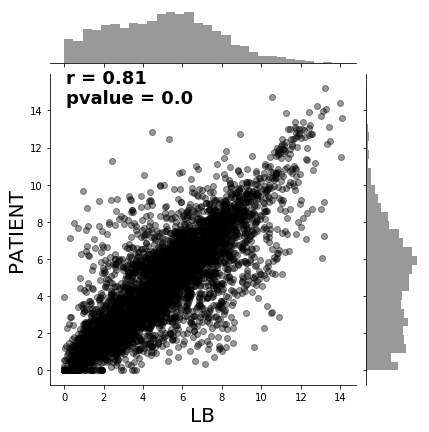

In [30]:
r, p_val = stats.pearsonr(log_norm_cnts["HM43_LB"], log_norm_cnts["HM43_UTI"])
s = sns.jointplot( x = "HM43_LB", y ="HM43_UTI", data=cnts, color = 'black', alpha=0.4, height=6)
s.set_axis_labels("LB", "PATIENT", fontsize=20)
s.fig.text(0.15, 0.75, "r = {}\npvalue = {}".format(round(r, 2), p_val), 
           horizontalalignment='left', fontsize=18, color='black', weight='semibold')
#s.savefig(Path(fig_dir).joinpath("LB_vs_UTI.png"), dpi=150, bbox_inches="tight")

In [ ]:
###### 
#    #
#HERE#
#    #
######

In [81]:



counts = pd.DataFrame(tpms)
pcounts = counts[[c for c in counts.columns if "UTI" in c and 'seq' not in c]]
ucounts = counts[[c for c in counts.columns if 'UR' in c and 'seq' not in c]]
#uncnts = ucounts.apply(ut.invnorm)
#pnorm_counts = pcounts.apply(ut.invnorm) # Raises a warning, but performs as expected
pnorm_counts = np.log2(pcounts + 1)
unorm_counts = np.log2(ucounts + 1)

(15420, 20)


In [ ]:
tpms = process_counts.normalize_counts_to_tpm(raw_counts_dir, gff, out_dir)

In [82]:
pnorm_counts.describe()

,HM56_UTI,HM07_UTI,HM43_UTI,HM54_UTI,HM86_UTI,HM68_UTI,HM17_UTI,HM60_UTI,HM03_UTI,HM66_UTI,HM01_UTI,HM14_UTI,HM06_UTI,HM57_UTI
count,4741.000000,5014.000000,4711.000000,5449.000000,5123.000000,4780.000000,4912.000000,6073.000000,4406.000000,4956.000000,5013.000000,4879.000000,5213.000000,4845.000000
mean,4.407589,4.440130,4.705056,4.281149,4.334495,4.551006,4.235562,4.375096,4.340860,4.977036,4.042965,4.145906,4.593121,4.985140
std,2.786039,2.881480,2.739474,2.850946,2.867533,2.818594,2.779787,2.566275,2.880934,2.943797,2.937838,2.909607,2.709534,2.427151
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.036233,2.024380,2.490853,1.877943,1.887915,2.223701,2.027694,2.683900,1.789545,3.893879,1.461536,1.574777,2.387808,3.370774
50%,4.247955,4.369796,4.708745,4.113371,4.247598,4.532616,4.110049,4.188081,4.255274,5.477548,3.775003,4.028329,4.517131,4.726106
75%,6.383466,6.581571,6.558397,6.418902,6.404076,6.539003,6.151603,6.067747,6.405734,6.841404,6.245107,6.253961,6.539610,6.510814
max,14.919669,15.068042,15.186608,14.857043,15.271442,14.788826,16.685789,16.300253,15.311729,14.949920,15.683505,15.771039,15.539139,15.082631


In [11]:
# Dropping the reference genomes, only interested in clinical strains
HM_matrix = orth_matrix.drop(ref_genomes, axis=1)
cond1 = HM_matrix.isnull().sum(axis=1) < 14 # at least in one
cond2 = HM_matrix.isnull().sum(axis=1) > 0 # not in all
variable = HM_matrix[cond1 & cond2]
core = HM_matrix[HM_matrix.isnull().sum(axis=1) == 0]

In [13]:
strains = list(HM_matrix.columns)
strains.remove("HM66")
all_strains = list(itertools.combinations(strains, 2))
#b1_strains = config_dict['data']['b1_strains'].split()
#b2_strains = config_dict['data']['b2_strains'].split()
#b2_strains.remove("HM66")
#b1_b2 = [t[0]+"_"+t[1] for t in itertools.product(b1_strains, b2_strains) ]

In [12]:
print("Genes conserved across 14 strains: {}".format(core.shape[0])) #2488
print("Genes variable across 14 strains: {}".format(variable.shape[0]))#10843

Genes conserved across 14 strains: 2488
Genes variable across 14 strains: 10843


Text(0,0.5,'# of genes')

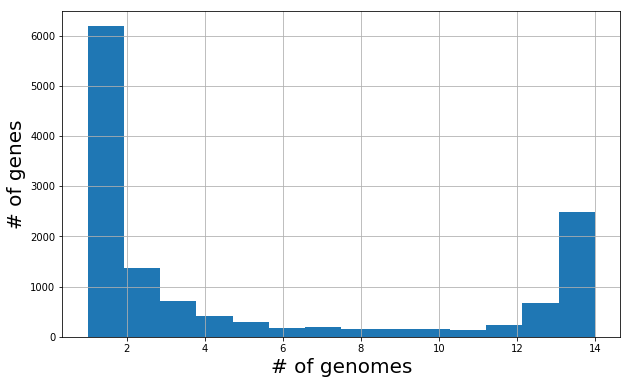

In [213]:
# Gene distribution across 14 clinical UTI genomes
plt.figure(figsize=(10,6))
HM_matrix[cond1].notnull().sum(axis=1).hist(bins=14)
plt.xlabel("# of genomes", fontsize=20)
plt.ylabel("# of genes", fontsize=20)

In [49]:
def get_expression(matrix, strains, counts, prefix="_UTI"):
    d = matrix[strains].T.to_dict()
    nd = {}
    for gene, strain_dict in d.items():
        nd[gene] = {}
        for k,v in strain_dict.items():
            if v is np.nan:
                expr = np.nan
            elif len(v.split())>1:
                expr = np.nan
            else:
                expr = counts.loc[v][k+prefix]
            nd[gene][k] = expr
    df = pd.DataFrame(nd).T
    return df

In [83]:
pcore_counts = get_expression(core, strains, pnorm_counts).dropna()
ucore_counts = get_expression (core, strains, unorm_counts, "_UR").dropna()

In [84]:
print("Patient core counts mean {}".format(pcore_counts.mean().mean()))
print("Urine core counts mean {}".format(ucore_counts.mean().mean()))

Patient core counts mean 5.333665891384656
Urine core counts mean 6.088594639494319


In [86]:
pvar_counts = get_expression(variable, strains, pnorm_counts)
uvar_counts = get_expression (variable, strains, unorm_counts, "_UR")

In [87]:
print("Patient variable counts mean {}".format(pvar_counts.mean().mean()))
print("Urine variable counts mean {}".format(uvar_counts.mean().mean()))

Patient variable counts mean 3.7466044738827784
Urine variable counts mean 4.570299125105818


In [91]:
pcore_counts.corr()

,HM01,HM03,HM06,HM07,HM14,HM17,HM43,HM54,HM56,HM57,HM60,HM68,HM86
HM01,1.000000,0.949666,0.930577,0.908740,0.900396,0.921625,0.884026,0.953275,0.945879,0.915715,0.916538,0.936813,0.919595
HM03,0.949666,1.000000,0.916335,0.947527,0.942940,0.933626,0.902048,0.947982,0.960906,0.924241,0.928899,0.947104,0.942113
HM06,0.930577,0.916335,1.000000,0.898891,0.859143,0.902414,0.915222,0.938796,0.941845,0.909489,0.889338,0.933207,0.914501
HM07,0.908740,0.947527,0.898891,1.000000,0.903398,0.912407,0.913971,0.910889,0.933877,0.894034,0.896522,0.917395,0.924922
HM14,0.900396,0.942940,0.859143,0.903398,1.000000,0.909673,0.883574,0.900650,0.906068,0.879049,0.894195,0.903938,0.907617
HM17,0.921625,0.933626,0.902414,0.912407,0.909673,1.000000,0.913319,0.938234,0.951264,0.935798,0.919415,0.944556,0.944759
HM43,0.884026,0.902048,0.915222,0.913971,0.883574,0.913319,1.000000,0.906197,0.932875,0.891541,0.882830,0.922270,0.941725
HM54,0.953275,0.947982,0.938796,0.910889,0.900650,0.938234,0.906197,1.000000,0.957703,0.935722,0.930230,0.956078,0.942520
HM56,0.945879,0.960906,0.941845,0.933877,0.906068,0.951264,0.932875,0.957703,1.000000,0.944292,0.933588,0.958872,0.962636
HM57,0.915715,0.924241,0.909489,0.894034,0.879049,0.935798,0.891541,0.935722,0.944292,1.000000,0.936104,0.936562,0.918505


In [92]:
pvar_counts.corr()

,HM01,HM03,HM06,HM07,HM14,HM17,HM43,HM54,HM56,HM57,HM60,HM68,HM86
HM01,1.000000,0.946467,0.904435,0.876241,0.886658,0.876188,0.849065,0.925883,0.923224,0.888960,0.856428,0.919781,0.870829
HM03,0.946467,1.000000,0.896855,0.927855,0.926893,0.918146,0.899937,0.918145,0.938725,0.905383,0.866266,0.941455,0.926455
HM06,0.904435,0.896855,1.000000,0.841821,0.831822,0.887470,0.878480,0.917309,0.908071,0.860123,0.840974,0.906387,0.874579
HM07,0.876241,0.927855,0.841821,1.000000,0.889218,0.888993,0.892703,0.851133,0.897153,0.846204,0.791730,0.885397,0.929697
HM14,0.886658,0.926893,0.831822,0.889218,1.000000,0.903770,0.825758,0.864009,0.848274,0.833787,0.776064,0.863173,0.855878
HM17,0.876188,0.918146,0.887470,0.888993,0.903770,1.000000,0.895486,0.896793,0.926331,0.859391,0.845037,0.917385,0.903401
HM43,0.849065,0.899937,0.878480,0.892703,0.825758,0.895486,1.000000,0.850825,0.925917,0.841830,0.820531,0.919151,0.938329
HM54,0.925883,0.918145,0.917309,0.851133,0.864009,0.896793,0.850825,1.000000,0.915550,0.879508,0.849754,0.920829,0.888326
HM56,0.923224,0.938725,0.908071,0.897153,0.848274,0.926331,0.925917,0.915550,1.000000,0.908297,0.868530,0.934483,0.943374
HM57,0.888960,0.905383,0.860123,0.846204,0.833787,0.859391,0.841830,0.879508,0.908297,1.000000,0.886194,0.877799,0.859399


In [23]:
def phylogroup_correlations(strain_tuples, cnts, prefix="_UTI"): # REFACTOR
    names = []
    var_correlations = []
    core_correlations = []
    num_genes = []
    for l in strain_tuples:
        name = "_".join(l)
        names.append(name)
        df = two_strain_correlation((l[0], l[1]), variable, cnts, prefix)
        vcor = pearsonr(df[l[0]+ prefix], df[l[1] + prefix])
       
        num_genes.append(df.shape[0])
        var_correlations.append(vcor[0])
        
        df2 = two_strain_correlation((l[0], l[1]), core, cnts, prefix)
        
        ccor = pearsonr(df2[l[0] + prefix], df2[l[1] + prefix])
        
        core_correlations.append(ccor[0])
    cdf = pd.DataFrame({"Variable": var_correlations, "Core": core_correlations, }, index=names)
    ndf = pd.DataFrame({"Correlatin": var_correlations, "Num_Genes": num_genes}, index=names)
    return cdf, ndf 


In [24]:
pcdf, ndf = phylogroup_correlations(all_strains, pnorm_counts)

In [12]:
#pcdf2, ndf = phylogroup_correlations(all_strains, norm_counts2)

Variable Median: 0.88
Core Median: 0.92


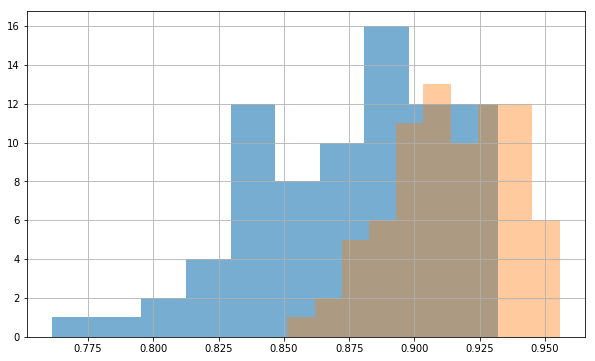

In [25]:
plt.figure(figsize=(10,6))
pcdf.Variable.hist(bins = 10, alpha=0.6)
pcdf.Core.hist(bins = 10, alpha=0.4)
print("Variable Median: {}".format(round(pcdf.Variable.median(),2))) #0.84 - with paralogs
print("Core Median: {}".format(round(pcdf.Core.median(),2)))#0.9 - with paralogs

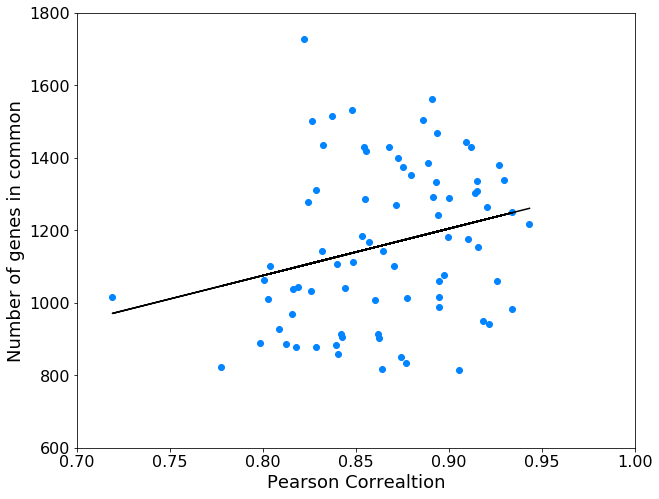

In [15]:
fig = plt.figure(figsize=(10,8))
plt.scatter(ndf.Correlatin, ndf.Num_Genes, color=ut.cols[0])
plt.xlim(0.7, 1)
plt.ylim(600, 1800)
plt.xlabel("Pearson Correaltion", fontsize=18)
plt.ylabel("Number of genes in common", fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

z = np.polyfit(ndf.Correlatin, ndf.Num_Genes, 1)
p = np.poly1d(z)
plt.plot(ndf.Correlatin,p(ndf.Correlatin),"k-")

Text(0.5,0,'')

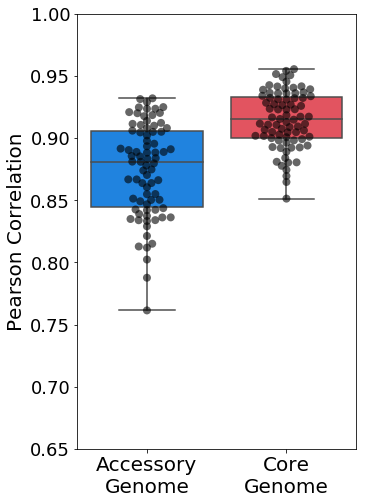

In [26]:
correlation = pcdf.unstack().reset_index()
correlation.columns = ["type", 'name', 'pearsonr']
#correlation['b1_b2'] = ["Y" if c in b1_b2 else "N" for c in correlation.name ]
plt.figure(figsize=(5,8))
sns.boxplot(x = 'type', y = 'pearsonr', data =  correlation, palette= [ut.cols[0], ut.cols[3]])
sns.swarmplot(x='type', y='pearsonr', data=correlation, palette=['black'], alpha=0.6, size=8)
plt.ylim(0.65, 1)
#plt.title("Accessory and Core genomes Expression Correlation\n", fontsize=16)
plt.ylabel("Pearson Correlation", fontsize=20)
plt.yticks(fontsize=18)
plt.gca().set_xticklabels(["Accessory\nGenome", "Core\nGenome"],fontsize=20)
plt.xlabel("")
#plt.savefig(Path(figures_dir/"in_patient_correlation_accessory_vs_core_genome.png"))

In [ ]:
ucdf, undf = phylogroup_correlations(all_strains, uncnts, prefix="_UR")

Variable Median: 0.876811439691315
Core Median: 0.8804576630422755


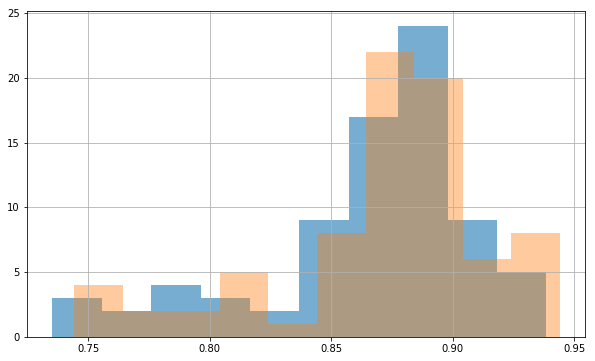

In [73]:
plt.figure(figsize=(10,6))
ucdf.Variable.hist(bins = 10, alpha=0.6)
ucdf.Core.hist(bins = 10, alpha=0.4)
print("Variable Median: {}".format(ucdf.Variable.median()))#0.88
print("Core Median: {}".format(ucdf.Core.median()))#0.88

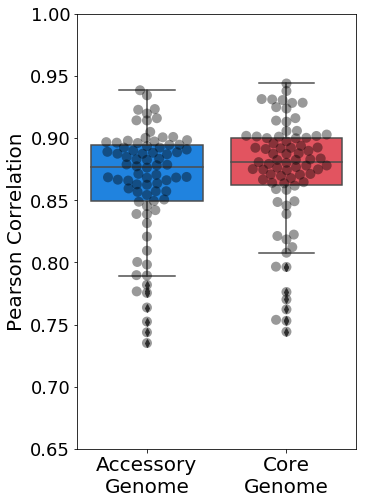

In [74]:
correlation = ucdf.unstack().reset_index()
correlation.columns = ["type", 'name', 'pearsonr']
plt.figure(figsize=(5,8))
sns.boxplot(x = 'type', y = 'pearsonr', data =  correlation, palette= [ut.cols[0], ut.cols[3]])
sns.swarmplot(x='type', y='pearsonr', data=correlation, palette=['black'], alpha=0.4, size=10)
plt.ylim(0.65, 1)
#plt.title("Accessory and Core genomes Expression Correlation\n", fontsize=16)
plt.ylabel("Pearson Correlation", fontsize=20)
plt.yticks(fontsize=18)
plt.gca().set_xticklabels(["Accessory\nGenome", "Core\nGenome"],fontsize=20)
plt.xlabel("")
plt.savefig(Path(figures_dir/"urine_correlation_accessory_vs_core_genome.png"))

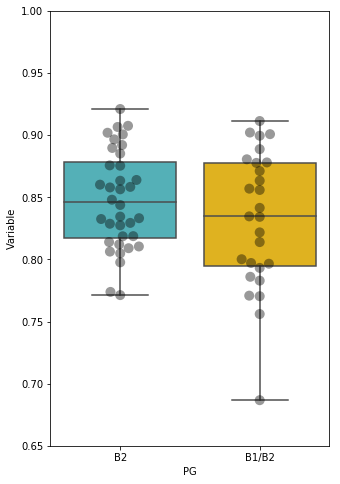

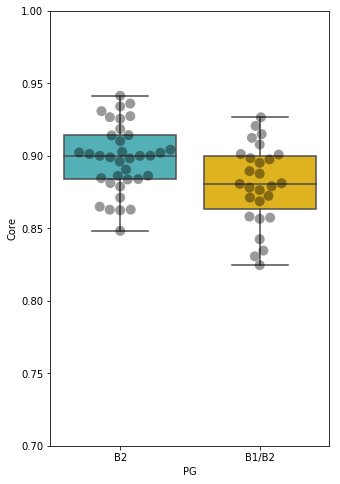

In [76]:
b2pr, _= phylogroup_correlations(itertools.combinations(b2_strains, 2), norm_counts)
b2pr['PG'] = "B2"
b2b1pr, _ = phylogroup_correlations(itertools.product(b1_strains, b2_strains), norm_counts)
b2b1pr["PG"]="B1/B2"
pg_df = pd.concat([b2pr, b2b1pr])
plt.figure(figsize=(5,8))
plt.ylim(0.7, 1)
sns.boxplot(x = 'PG', y = 'Variable', data =  pg_df, palette=[ut.cols[1], ut.cols[2]])
sns.swarmplot(x='PG', y='Variable', data=pg_df, palette=['black'], alpha=0.4, size=10)
plt.ylim(0.65, 1)
plt.figure(figsize=(5,8))
plt.ylim(0.7, 1)
sns.boxplot(x = 'PG', y = 'Core', data =  pg_df, palette= [ut.cols[1], ut.cols[2]])
sns.swarmplot(x='PG', y='Core', data=pg_df, palette=['black'], alpha=0.4, size=10)

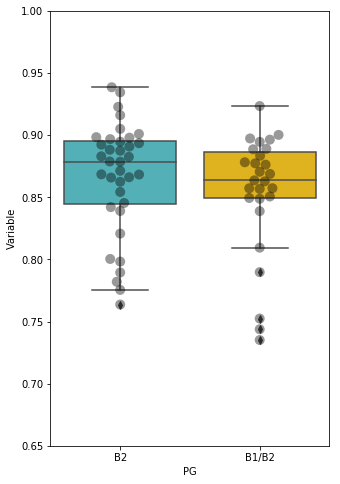

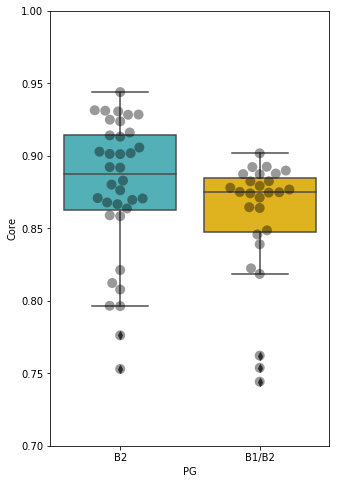

In [77]:
b2pr= phylogroup_correlations(itertools.combinations(b2_strains, 2), uncnts, '_UR')
b2pr['PG'] = "B2"
b2b1pr = phylogroup_correlations(itertools.product(b1_strains, b2_strains), uncnts, "_UR")
b2b1pr["PG"]="B1/B2"
pg_df = pd.concat([b2pr, b2b1pr])
plt.figure(figsize=(5,8))
plt.ylim(0.7, 1)
sns.boxplot(x = 'PG', y = 'Variable', data =  pg_df, palette=[ut.cols[1], ut.cols[2]])
sns.swarmplot(x='PG', y='Variable', data=pg_df, palette=['black'], alpha=0.4, size=10)
plt.ylim(0.65, 1)
plt.figure(figsize=(5,8))
plt.ylim(0.7, 1)
sns.boxplot(x = 'PG', y = 'Core', data =  pg_df, palette= [ut.cols[1], ut.cols[2]])
sns.swarmplot(x='PG', y='Core', data=pg_df, palette=['black'], alpha=0.4, size=10)

# Most Variable Genes

In [10]:
norm_counts.head()

,HM56_UTI,HM07_UTI,HM43_UTI,HM54_UTI,HM86_UTI,HM68_UTI,HM17_UTI,HM60_UTI,HM03_UTI,HM66_UTI,HM01_UTI,HM14_UTI,HM06_UTI,HM57_UTI
PROKKA_00001,-2.321704,-1.748515,-2.188182,-1.834244,-1.900342,-1.885116,-1.745934,-1.667878,-2.158783,-1.285702,-1.771959,-1.925959,-2.072984,-1.997044
PROKKA_00002,-2.321704,NaN,-2.188182,-1.834244,-1.900342,-1.885116,-1.745934,-1.667878,-2.158783,-1.285702,-1.771959,-1.925959,-2.072984,-1.997044
PROKKA_00003,-2.321704,NaN,-2.188182,-1.834244,-1.900342,-1.885116,-1.745934,-1.667878,NaN,-1.285702,-1.771959,-1.925959,-2.072984,NaN
PROKKA_00004,-2.321704,NaN,-2.188182,-1.834244,-1.900342,-1.885116,-1.745934,-1.236688,-2.158783,-1.285702,-1.771959,-1.925959,-2.072984,-1.997044
PROKKA_00005,-2.321704,NaN,-2.188182,-1.834244,-1.900342,-1.885116,-1.745934,-1.667878,-2.158783,-1.285702,-1.771959,-1.925959,-2.072984,-1.997044


In [25]:
test = get_expression(orth_matrix, strains, norm_counts, prefix="_UTI")

In [26]:
test2 = test[test.notnull().sum(axis=1) >4]
test2.shape

(4471, 13)

In [99]:
test2.head()

,HM01,HM03,HM06,HM07,HM14,HM17,HM43,HM54,HM56,HM57,HM60,HM68,HM86
76482_pgaA,NaN,-1.431481,-1.193464,NaN,-1.060783,NaN,NaN,NaN,-0.389224,-0.799245,-0.540763,-1.313804,-0.962226
76643_dadX,-0.036510,-0.065187,-0.218096,0.065788,0.035457,-0.475307,0.021285,-0.085668,-0.359169,-0.754125,-0.852909,-0.234169,-0.031320
76701_oppF,0.571112,-0.007111,0.438213,-0.035002,0.292329,0.548028,0.431798,0.464202,0.175370,0.322111,0.089894,0.456670,0.507854
77034_ydfA,-0.064548,0.142998,NaN,0.343327,NaN,NaN,0.044177,0.645746,NaN,NaN,-0.130176,NaN,NaN
78396_hybA,0.205447,0.118898,-0.009136,-0.171563,0.234874,0.530324,-0.284185,0.011501,0.121373,0.024836,-0.090516,-0.159302,-0.124601


In [27]:
res = []
for strain in all_strains:
    strain1=strain[0]
    strain2=strain[1]
    
    data = test2[[strain1, strain2]].dropna()
    model = sm.OLS.from_formula("{} ~ {}".format(strain1, strain2), data=data)# ordinary least squares
    result = model.fit()
    r = result.resid
    r.name = strain1+"_"+strain2
    res.append(result.resid)
residuals = pd.DataFrame(res).T

[10.0, 15.0, 21.0, 28.0, 36.0, 45.0, 55.0, 66.0, 78.0]

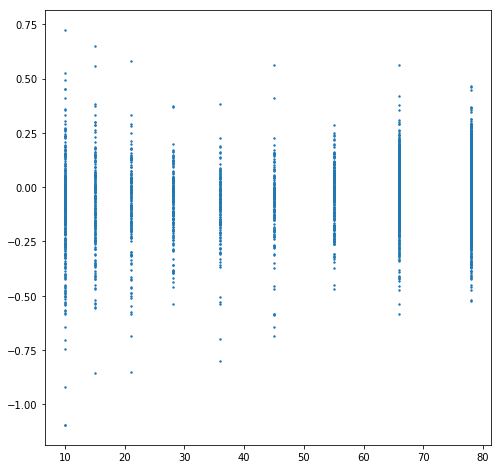

In [36]:
x = pd.DataFrame([residuals.mean(axis=1), residuals.notnull().sum(axis=1)]).T
f = plt.figure(figsize=(8,8))
plt.scatter(x[1], x[0], marker='.',s=8)

sorted(x[1].unique())

In [37]:
fres = abs(residuals)

In [38]:
fres.mean(axis=1).std()

0.16898864227326379

In [122]:
fres.head()

,0,1,2,3,4,5,6,7,8,9,...,68,69,70,71,72,73,74,75,76,77
76643_dadX,0.088440,0.121919,0.162252,0.120647,0.288967,0.147164,0.056944,0.187846,0.506455,0.699008,...,0.338551,0.511314,0.136763,0.281210,0.125612,0.553976,0.697321,0.748748,0.891127,0.169000
77263_yeaV,0.290596,NaN,0.606449,0.649349,NaN,NaN,NaN,NaN,NaN,0.953532,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
76701_oppF,0.466496,0.138109,0.534448,0.257515,0.002136,0.116297,0.146386,0.319932,0.189991,0.469888,...,0.128274,0.160203,0.264326,0.278401,0.308652,0.108447,0.116843,0.419732,0.427740,0.007010
77034_ydfA,0.305348,NaN,0.435579,NaN,NaN,0.194394,0.660356,NaN,NaN,0.029541,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
78396_hybA,0.013488,0.175572,0.289474,0.056828,0.352253,0.350889,0.207332,0.002304,0.079574,0.264337,...,0.094322,0.275679,0.272026,0.291326,0.182294,0.156634,0.167411,0.052872,0.045791,0.005063


In [39]:
th = 2* fres.mean(axis=1).std()
th

0.33797728454652759

In [40]:
residuals.mean(axis=1).min()

-1.0934130798627459

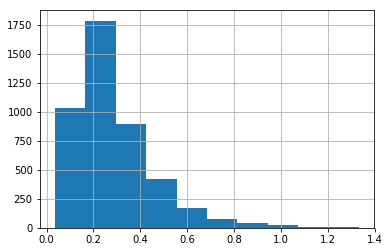

In [121]:
fres.mean(axis=1).hist()

In [42]:
conserved = fres.mean(axis=1).nsmallest(100)
conserved = orth_matrix.loc[conserved.index].merge(pd.DataFrame(conserved), left_index=True, right_index=True)
conserved
conserved.sort_values(['K-12', 'CFT073', '536', 'F11'])[ref_genomes+[0]].to_csv(results_dir/Path("human_conserved.csv"))

In [134]:
var = fres[fres.mean(axis=1) > 0.8]
var.shape

(80, 78)

In [137]:
var.mean(axis=1).sort_values(ascending=False).to_csv(results_dir/Path("human_variable.csv"))

In [127]:
var_genes = var.index

In [141]:
human_variable = orth_matrix.loc[var_genes].merge(pd.DataFrame(var.mean(axis=1)), left_index=True, right_index=True)

In [143]:
human_variable.to_csv(results_dir/Path("human_variable.csv"))


In [149]:
human_variable.sort_values(['K-12', 'CFT073', '536', 'F11'])[ref_genomes].to_csv(results_dir/Path("human_variable.csv"))

In [298]:
residuals.mean(axis=1).max()

3.8918263651247398

In [288]:
t2 = pd.DataFrame([residuals, residuals2]).T
t2

,0,1
76643_dadX,-0.100023,0.114516
77263_yeaV,-0.340221,NaN
76701_oppF,0.456219,0.141891
77034_ydfA,-0.312245,NaN
78396_hybA,-0.020928,0.171730
75919_ybaV,0.071633,0.279541
75873_araJ,0.167016,0.244463
75974_ybbP,0.248000,0.288276
77929_bepA,0.147952,-0.230149
77404_fliM,-0.898618,0.055723


In [260]:
test.corr()

,HM01,HM03,HM06,HM07,HM14,HM17,HM43,HM54,HM56,HM57,HM60,HM68,HM86
HM01,1.000000,0.923536,0.906004,0.876950,0.857746,0.892453,0.862855,0.892925,0.912482,0.871936,0.883601,0.904555,0.883505
HM03,0.923536,1.000000,0.893690,0.913101,0.906391,0.911293,0.882243,0.879101,0.923921,0.880605,0.892036,0.913557,0.917409
HM06,0.906004,0.893690,1.000000,0.865680,0.818578,0.883545,0.893081,0.882629,0.908216,0.864961,0.859485,0.901669,0.884781
HM07,0.876950,0.913101,0.865680,1.000000,0.869304,0.884375,0.891049,0.831054,0.885210,0.843764,0.853865,0.885074,0.905274
HM14,0.857746,0.906391,0.818578,0.869304,1.000000,0.882207,0.843782,0.822782,0.850482,0.819796,0.822217,0.861409,0.856062
HM17,0.892453,0.911293,0.883545,0.884375,0.882207,1.000000,0.901120,0.875514,0.921106,0.872354,0.886946,0.918756,0.905809
HM43,0.862855,0.882243,0.893081,0.891049,0.843782,0.901120,1.000000,0.844097,0.915628,0.850133,0.857866,0.911907,0.933991
HM54,0.892925,0.879101,0.882629,0.831054,0.822782,0.875514,0.844097,1.000000,0.888058,0.854211,0.848343,0.883094,0.873148
HM56,0.912482,0.923921,0.908216,0.885210,0.850482,0.921106,0.915628,0.888058,1.000000,0.887938,0.882419,0.924125,0.932942
HM57,0.871936,0.880605,0.864961,0.843764,0.819796,0.872354,0.850133,0.854211,0.887938,1.000000,0.889041,0.878857,0.867246


In [243]:
test = orth_matrix.merge(norm_counts[['HM56_UTI']], how='outer',left_on="HM56", right_index=True)
test[['HM56', 'HM56_UTI']].tail()

,HM56,HM56_UTI
19198_hypothetical_protein,PROKKA_06366,NaN
19198_hypothetical_protein,PROKKA_06367,NaN
19198_hypothetical_protein,PROKKA_06368,NaN
19198_hypothetical_protein,PROKKA_06369,NaN
19198_hypothetical_protein,PROKKA_06370,NaN


# Functional Groups

In [12]:
fgroups = pd.read_csv(functional_groups_file, index_col=0)
to_keep = ['Functional Group', "Description", "CFT073", "UTI89", "536"]
fgroups = fgroups[to_keep]


In [13]:
def get_category_genes(fgroup, panmatrix, refs, strains=strains):
    subsets = []
    for ref in refs:
        if ref in fgroup.columns:
            ref_df = fgroup.dropna(subset=[ref]).reset_index()
            
            ref_df = ref_df.merge(panmatrix[strains+[ref]], how='left', left_on = ref, right_on=ref)
            subsets.append(ref_df)            
    fdf = pd.concat(subsets, sort=False).drop_duplicates().set_index('index')
    return fdf


def get_all_functional_groups(fgroups, panmatrix, refs=['CFT073', 'UTI89'], function='Functional Group', description='Description' ):
    gene_sets = {}
    for i, g in fgroups.groupby(function):
        fdf  = get_category_genes(g, panmatrix, refs ) 
        gene_sets[i] = fdf
    return gene_sets
    



In [14]:
gene_sets = get_all_functional_groups(fgroups, orth_matrix)

In [176]:
# Iron Acquisition
iron_df = gene_sets['Iron Acquisition']
iron_df.head()

,Functional Group,Description,CFT073,UTI89,536,HM01,HM03,HM06,HM07,HM14,HM17,HM43,HM54,HM56,HM57,HM60,HM68,HM86
index,,,,,,,,,,,,,,,,,,
FepA,Iron Acquisition,Other,c0669,UTI89_C0584,ECP_RS03065,PROKKA_00076,PROKKA_03541,PROKKA_04259,PROKKA_05052,PROKKA_00465,PROKKA_01166,PROKKA_00957,PROKKA_02334,PROKKA_04099,PROKKA_04272,PROKKA_00297,PROKKA_04790,PROKKA_04330
Iha,Iron Acquisition,Other,c3610,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PROKKA_04915,NaN,NaN,NaN,NaN,NaN
IreA,Iron Acquisition,Other,c5174,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PROKKA_03269,NaN,NaN,NaN
Fiu,Iron Acquisition,Other,c0890,NaN,ECP_RS04120,PROKKA_00301,PROKKA_03767,PROKKA_04489,PROKKA_00067,PROKKA_00701,PROKKA_00948,PROKKA_00725,PROKKA_02554,PROKKA_03878,PROKKA_04487,NaN,PROKKA_00040,PROKKA_04112
CirA,Iron Acquisition,Enterobactin,c2690,UTI89_C2429,NaN,PROKKA_01924,PROKKA_00513,PROKKA_00956,PROKKA_01741,PROKKA_02202,PROKKA_04375,PROKKA_04034,PROKKA_04187,PROKKA_02443,PROKKA_00990,PROKKA_02485,PROKKA_01618,PROKKA_02518


In [156]:
norm_counts2.head()

,HM56_UTI,HM07_UTI,HM43_UTI,HM54_UTI,HM86_UTI,HM68_UTI,HM17_UTI,HM60_UTI,HM03_UTI,HM66_UTI,HM01_UTI,HM14_UTI,HM06_UTI,HM57_UTI
PROKKA_00001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
PROKKA_00002,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
PROKKA_00003,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.000000,NaN,0.0,0.0,0.0,0.0,NaN
PROKKA_00004,0.0,NaN,0.0,0.0,0.0,0.0,0.0,1.233388,0.0,0.0,0.0,0.0,0.0,0.0
PROKKA_00005,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
def expression_in_all_strains(group_df, strains, norm_counts, prefix="_UTI"):
    
    

,HM43_UTI,HM86_UTI
HM43_UTI,1.000000,0.969657
HM86_UTI,0.969657,1.000000


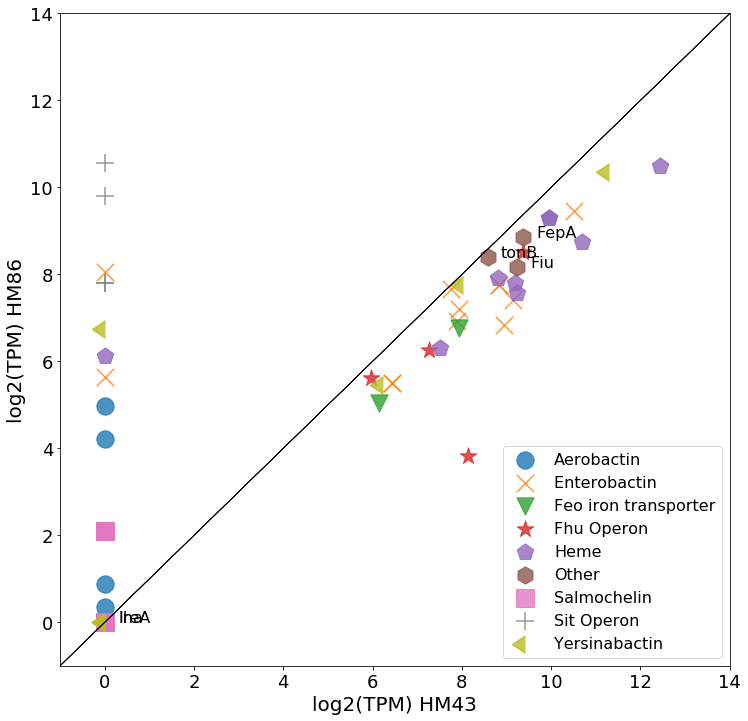

In [177]:
def graph_group_expression_by_description(group_df, strain1, strain2, norm_counts, prefix="_UTI", d="Description"):
    m_list = ['o', 'x', 'v', '*', 'p', 'h', 's','+', 8, '>']
  
    df = (two_strain_correlation((strain1, strain2), group_df, norm_counts, prefix, withna=True)
      .fillna(0)
      .merge(group_df, left_index=True, right_index=True))
    f = plt.figure(figsize=(12,12))
    if d:
        for i, group in enumerate(df.groupby(d)):
            x = group[1][strain1+prefix].values
            y = group[1][strain2+prefix].values

            plt.scatter(x,y, marker=m_list[i], s=300, label=group[0], alpha=0.8, )
            plt.xlabel("log2(TPM) {}".format(strain1), fontsize=20)
            plt.ylabel("log2(TPM) {}".format(strain2), fontsize=20)
            if group[0] == "Other":
                for i, txt in enumerate(group[1].index):
                    plt.gca().annotate(txt, (x[i], y[i]), xytext=(x[i]+0.3, y[i]), fontsize=16)

            plt.xlim(-1,14)
            plt.ylim(-1,14)
            plt.xticks(fontsize=18)
            plt.yticks(fontsize=18)
            plt.plot([-2, 20], [-2, 20], 'k-', linewidth=0.5)
            plt.legend(fontsize=16)
    else: 
        x = nor
    return f, df

f, d = graph_group_expression_by_description(iron_df, "HM43", "HM86", norm_counts2)
d.iloc[:, 0:2].replace(0, np.nan).dropna().tail().corr()

,HM43_UR,HM86_UR
HM43_UR,1.000000,0.921157
HM86_UR,0.921157,1.000000


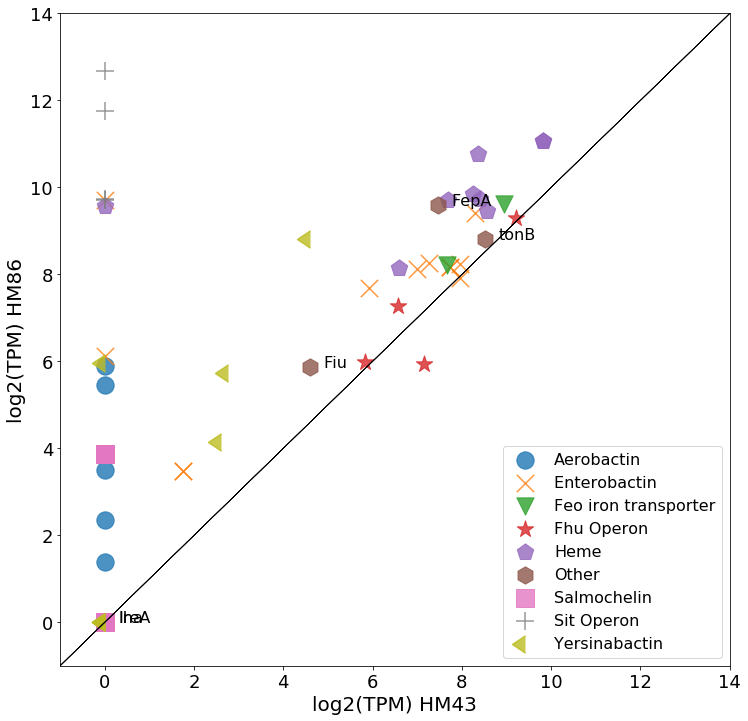

In [34]:
f, d = graph_group_expression_by_description(iron_df, "HM43", "HM86", unorm_counts2, prefix= "_UR")
d.iloc[:, 0:2].replace(0, np.nan).dropna().tail().corr()

,HM43_UTI,HM56_UTI
HM43_UTI,1.000000,0.597985
HM56_UTI,0.597985,1.000000


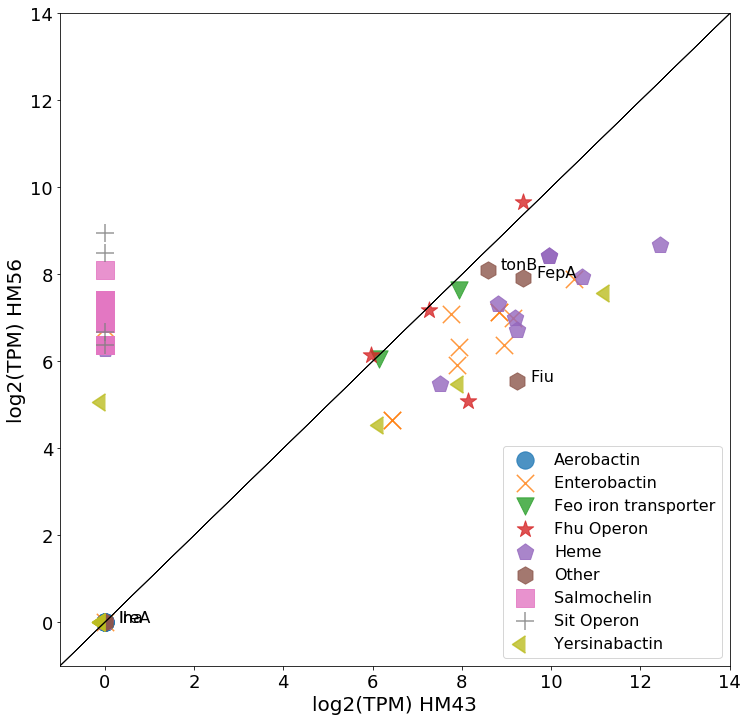

In [35]:
f,g = graph_group_expression_by_description(iron_df, "HM43", "HM56", norm_counts2)
g.iloc[:, 0:2].replace(0, np.nan).dropna().tail().corr()

,HM43_UR,HM56_UR
HM43_UR,1.000000,0.987194
HM56_UR,0.987194,1.000000


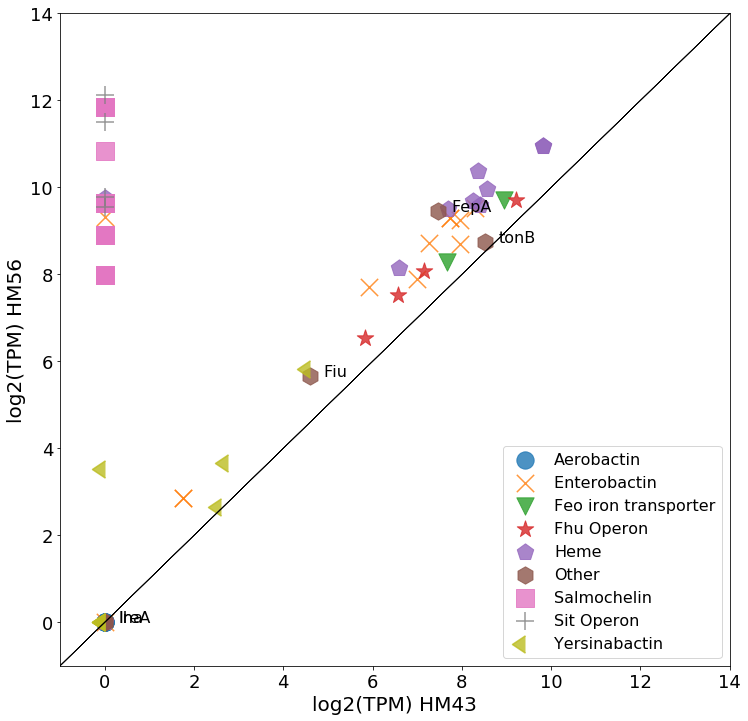

In [36]:
f,g = graph_group_expression_by_description(iron_df, "HM43", "HM56", unorm_counts2, prefix="_UR")
g.iloc[:, 0:2].replace(0, np.nan).dropna().tail().corr()

,HM56_UTI,HM86_UTI
HM56_UTI,1.000000,0.830851
HM86_UTI,0.830851,1.000000


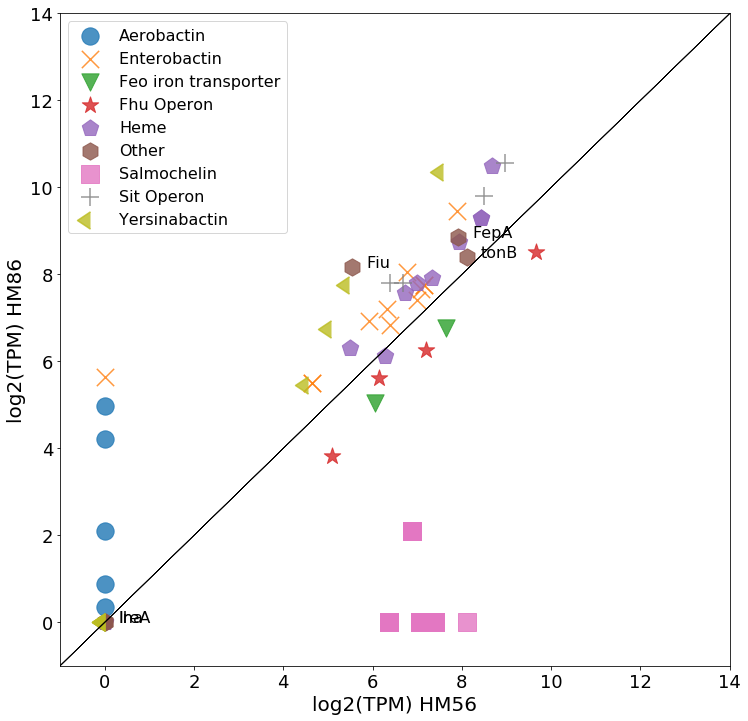

In [37]:
f,g = graph_group_expression_by_description(iron_df, "HM56", "HM86", norm_counts2)
g.iloc[:, 0:2].replace(0, np.nan).dropna().tail().corr()

,HM56_UR,HM86_UR
HM56_UR,1.000000,0.985322
HM86_UR,0.985322,1.000000


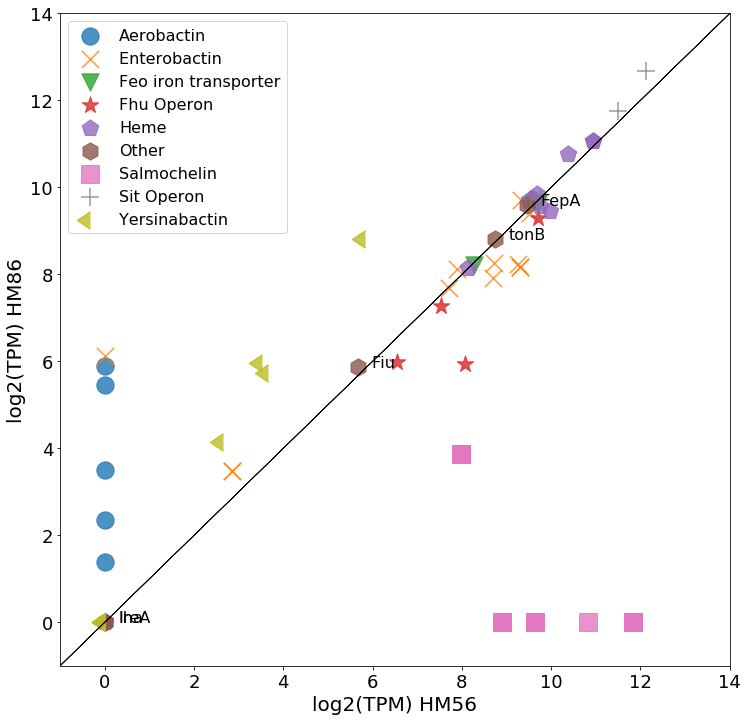

In [38]:
f,g = graph_group_expression_by_description(iron_df, "HM56", "HM86", unorm_counts2, prefix="_UR")
g.iloc[:, 0:2].replace(0, np.nan).dropna().tail().corr()

In [418]:
test = ic[["HM56_UTI", "Description"]]
test = test[test.HM56_UTI != 0]
test.Description.nunique()
#test = test[test.Description.isin(["Heme", "Salmochelin", "Enterobactin", "Yersinabactin", "Aerobactin"])]
test.Description.unique()

array(['Heme', 'Enterobactin ', 'Feo iron transporter', 'Other',
       'Fhu Operon', 'Yersinabactin', 'Salmochelin ', 'Sit Operon'], dtype=object)

In [16]:
def exprs_vs_redundancy(strains, matrix, cnts, prefix="_UTI", withna=False):
    s = []
    expr = []
    sch = []
    he = []
    nunq = []
    f = pd.DataFrame(index=matrix.index)
    for strain in strains:
        s.append(strain)
        strain_subset = pd.DataFrame()
     
        # Pick a random out of paralogs
        strain_subset[strain] = matrix[strain].str.split(" ", n=1, expand=True)[0]
       
        #two_strain_subset[strain2] = matrix[strain2].str.split(" ", n=1, expand=True)[0]# Randomly picks first of the paralogs
        if not withna:
            strain_subset = strain_subset.dropna()
            t = (strain_subset.join(cnts[strain+prefix],on=strain, how='left')
                .drop([strain], axis=1).merge(matrix, left_index=True, right_index=True))
            #t = t[t.Description.isin(["Fhu Operon","Sit Operon",
             #                         "Heme", "Salmochelin ", "Enterobactin", "Yersinabactin", "Aerobactin", "Other"])]
            f = f.merge(pd.DataFrame(t[strain+prefix]), how='outer', left_index=True, right_index=True)
            expr.append(t[strain+prefix].mean())
            he.append(t[t.Description == "Heme"][strain+prefix].mean())
            sch.append(t[t.Description == "Salmochelin "][strain+prefix].mean())
            nunq.append("Aerobactin" in list(t["Description"].unique()))
            #nunq.append(t["Description"].nunique())
        else:
            pass
    return pd.DataFrame({"Expr":expr, "nunq":nunq, "Heme":he, 'sch':sch}, index=s), f
       
    

#df, f = exprs_vs_redundancy(strains, iron_df, norm_counts2, )


#df2 = two_strain_correlation(("HM43", "HM56"), core, uncnts, "_UR" )

In [17]:
def get_expression(matrix, strains, counts, prefix="_UTI"):
    d = matrix[strains].T.to_dict()
    nd = {}
    for gene, strain_dict in d.items():
        nd[gene] = {}
        for k,v in strain_dict.items():
            if v is np.nan:
                expr = np.nan
            elif len(v.split())>1:
                expr = np.nan
            else:
                expr = counts.loc[v][k+prefix]
            nd[gene][k] = expr
    df = pd.DataFrame(nd).T
    return df

#x = get_expression(iron_df, strains, norm_counts2)
#x = x.merge(iron_df[['Functional Group', "Description"]], how='outer', left_index=True, right_index=True)
    #print(counts[[c+prefix for c in strains]].head())

In [157]:
x = x.reset_index()
y = pd.melt(x, id_vars=['index', 'Description'], value_vars=strains, value_name='Expr')


/anaconda/envs/biology/lib/python3.6/site-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


,Functional Group,Description,CFT073,UTI89,536,HM01,HM03,HM06,HM07,HM14,HM17,HM43,HM54,HM56,HM57,HM60,HM68,HM86
index,,,,,,,,,,,,,,,,,,
FepA,Iron Acquisition,Other,c0669,UTI89_C0584,ECP_RS03065,PROKKA_00076,PROKKA_03541,PROKKA_04259,PROKKA_05052,PROKKA_00465,PROKKA_01166,PROKKA_00957,PROKKA_02334,PROKKA_04099,PROKKA_04272,PROKKA_00297,PROKKA_04790,PROKKA_04330
Iha,Iron Acquisition,Other,c3610,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PROKKA_04915,NaN,NaN,NaN,NaN,NaN
IreA,Iron Acquisition,Other,c5174,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PROKKA_03269,NaN,NaN,NaN
Fiu,Iron Acquisition,Other,c0890,NaN,ECP_RS04120,PROKKA_00301,PROKKA_03767,PROKKA_04489,PROKKA_00067,PROKKA_00701,PROKKA_00948,PROKKA_00725,PROKKA_02554,PROKKA_03878,PROKKA_04487,NaN,PROKKA_00040,PROKKA_04112
CirA,Iron Acquisition,Enterobactin,c2690,UTI89_C2429,NaN,PROKKA_01924,PROKKA_00513,PROKKA_00956,PROKKA_01741,PROKKA_02202,PROKKA_04375,PROKKA_04034,PROKKA_04187,PROKKA_02443,PROKKA_00990,PROKKA_02485,PROKKA_01618,PROKKA_02518


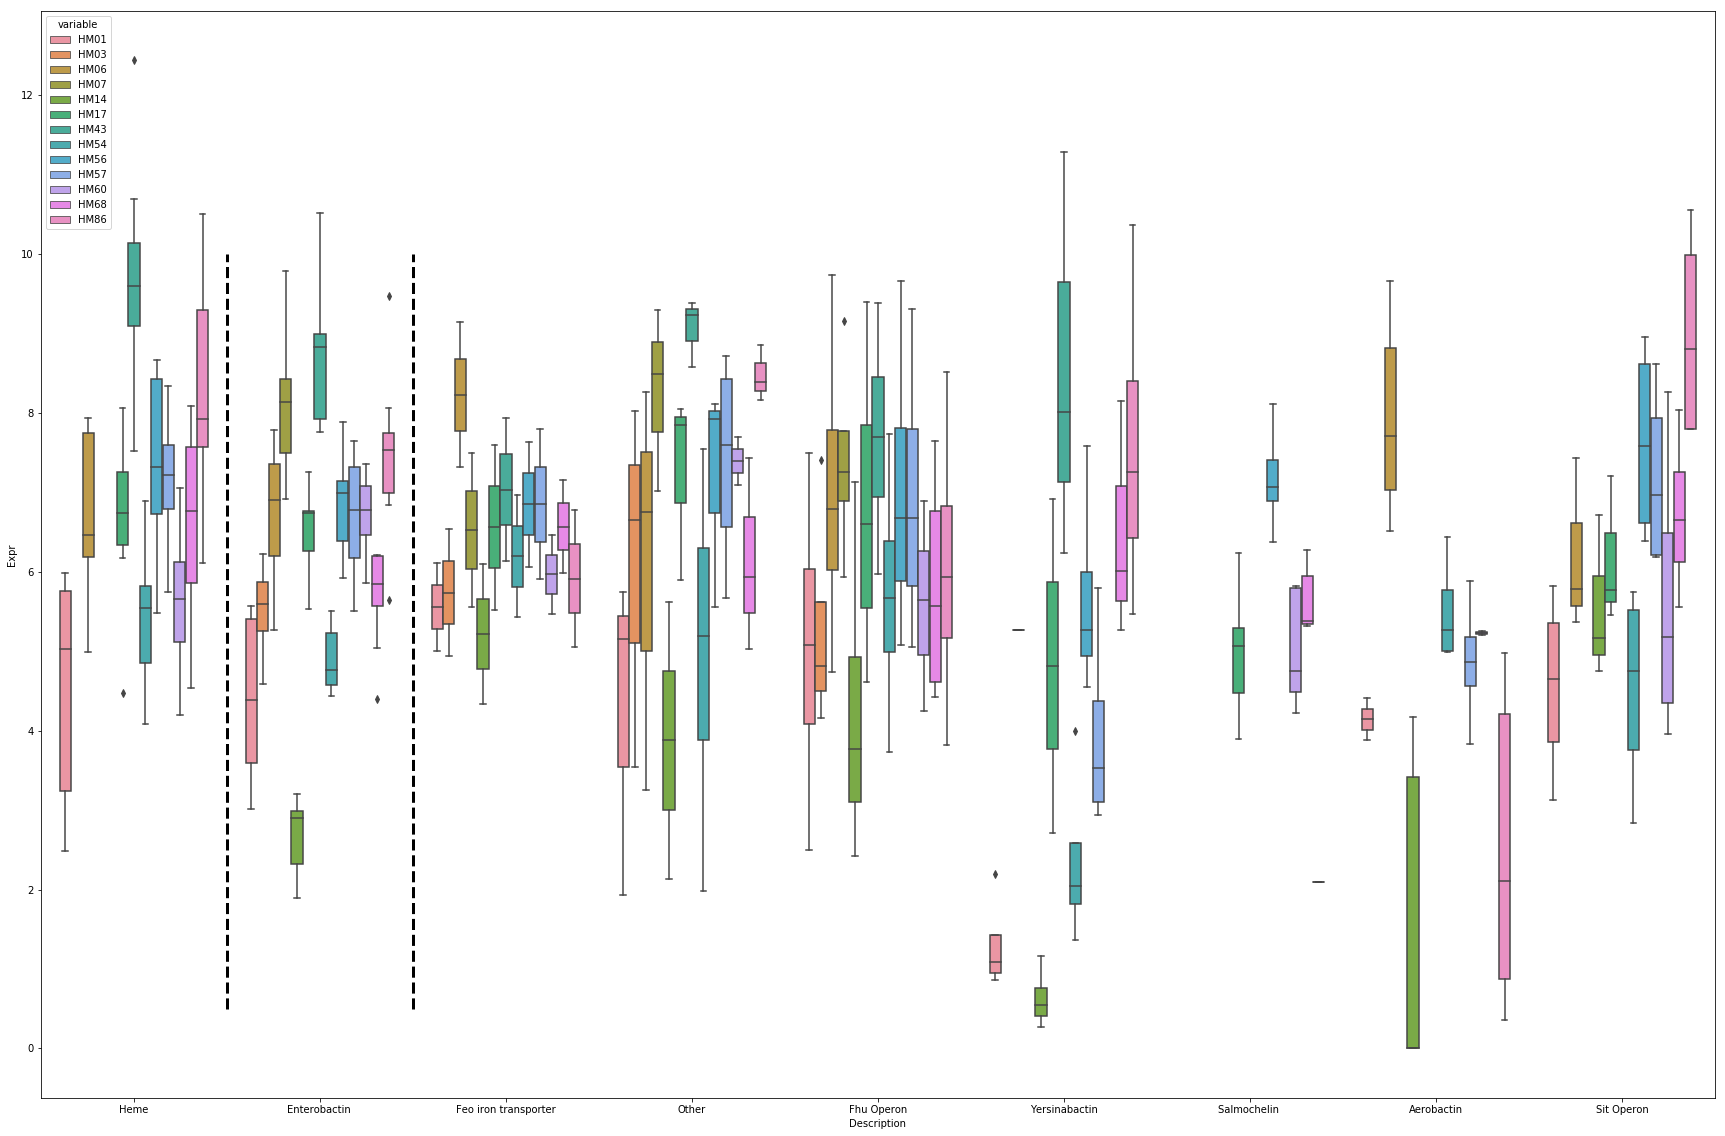

In [185]:
plt.figure(figsize=(30,20))
sns.boxplot(x='Description', y='Expr', hue='variable', data=y)
plt.plot((0.5,0.5), (0.5, 10), 'k--', linewidth=3)
plt.plot((1.5,1.5), (0.5, 10), 'k--', linewidth=3)

In [42]:
df

,Expr,nunq,Heme,sch
HM01,4.030075,True,4.475057,NaN
HM03,5.590736,False,NaN,NaN
HM06,6.607605,True,6.677893,NaN
HM07,7.770056,False,NaN,NaN
HM14,2.833589,True,NaN,NaN
HM17,5.879697,False,6.702586,4.863289
HM43,8.602041,False,9.723477,NaN
HM54,4.770466,True,5.514286,NaN
HM56,6.903689,False,7.364140,7.000360
HM57,6.343017,True,7.196353,NaN


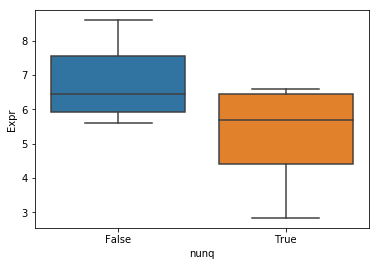

In [48]:
# Effect of aerobaction on iron system expression

sns.boxplot(x='nunq', y='Expr', data=df)

(-0.52713779412814876, 0.064154766548776263)

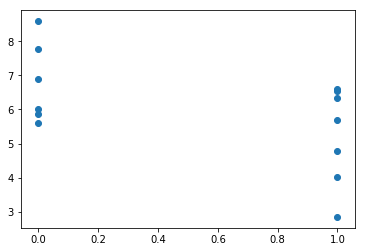

In [46]:
plt.scatter(df.nunq, df.Expr)
pearsonr(df.nunq, df.Expr)

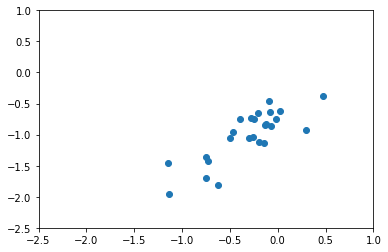

In [92]:
x = gene_sets['motility'].drop_duplicates()
y = x[['HM43', 'HM56']].dropna()
z1 = norm_counts.loc[y.HM43.values]['HM43_UTI']
z2 = norm_counts.loc[y.HM56.values]["HM56_UTI"]
plt.xlim(-2.5,1)
plt.ylim(-2.5, 1)
plt.scatter(z1, z2)

In [229]:
# Adhesion
ad_df = gene_sets['adherence']
ad_df.Description.nunique()

10

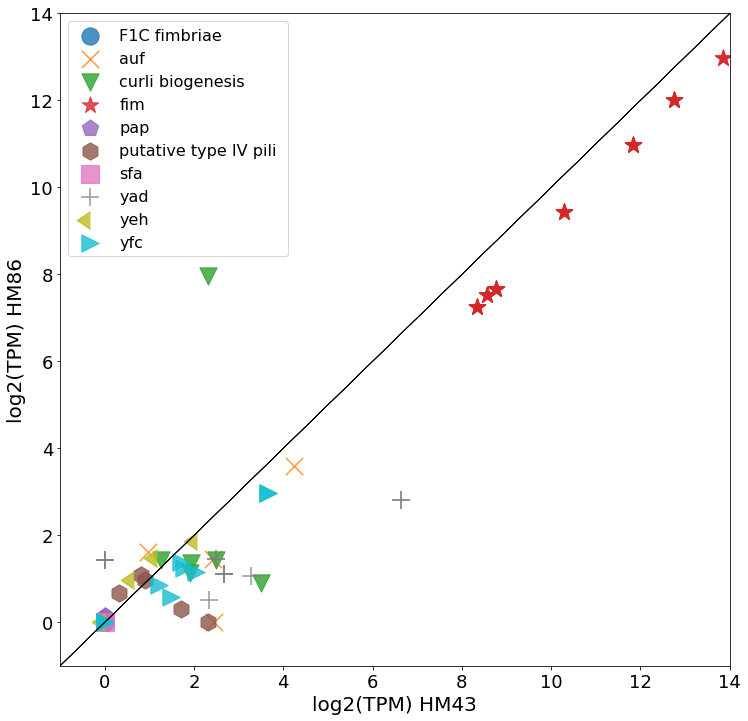

In [230]:
f, d = graph_group_expression_by_description(ad_df, "HM43", "HM86", norm_counts2)


In [233]:
ad_df

,Functional Group,Description,CFT073,UTI89,536,HM01,HM03,HM06,HM07,HM14,HM17,HM43,HM54,HM56,HM57,HM60,HM68,HM86
index,,,,,,,,,,,,,,,,,,
yfcO,adherence,yfc,c2878,UTI89_C2617,NaN,NaN,NaN,NaN,NaN,NaN,PROKKA_04191,PROKKA_03854,PROKKA_04490,NaN,PROKKA_01171,NaN,PROKKA_01798,PROKKA_02330
yfcP,adherence,yfc,c2879,UTI89_C2618,NaN,NaN,NaN,PROKKA_01140,NaN,NaN,PROKKA_04190,PROKKA_03853,PROKKA_04491,PROKKA_02263,PROKKA_01172,NaN,PROKKA_01799,PROKKA_02329
yfcQ,adherence,yfc,c2880,UTI89_C2619,NaN,NaN,NaN,PROKKA_01141,NaN,NaN,PROKKA_04189,PROKKA_03852,PROKKA_04492,PROKKA_02262,PROKKA_01173,NaN,PROKKA_01800,PROKKA_02328
yfcR,adherence,yfc,c2881,UTI89_C2620,NaN,NaN,NaN,NaN,NaN,NaN,PROKKA_04188,PROKKA_03851,PROKKA_04493,NaN,PROKKA_01174,NaN,PROKKA_01801,PROKKA_02327
yfcS,adherence,yfc,c2882,UTI89_C2621,NaN,NaN,NaN,PROKKA_01143,NaN,NaN,PROKKA_04187,PROKKA_03850,PROKKA_04494,PROKKA_02260,PROKKA_01175,PROKKA_02722,PROKKA_01802,PROKKA_02326
yfcU,adherence,yfc,c2883,UTI89_C2622,NaN,NaN,PROKKA_00683,PROKKA_01144,PROKKA_01929,PROKKA_02378,PROKKA_04186,PROKKA_03849,PROKKA_04495,PROKKA_02259,PROKKA_01176,PROKKA_02723,PROKKA_01803,PROKKA_02325
yfcV,adherence,yfc,c2884,UTI89_C2623,NaN,NaN,NaN,PROKKA_01145,NaN,NaN,PROKKA_04184,PROKKA_03848,PROKKA_04497,PROKKA_02258,PROKKA_01179,NaN,PROKKA_01804,PROKKA_02324
yadN,adherence,yad,c0172,UTI89_C0155,NaN,NaN,PROKKA_03071,PROKKA_03823,PROKKA_04510,PROKKA_04758,PROKKA_01699,PROKKA_01407,PROKKA_01865,NaN,PROKKA_03816,PROKKA_03266,PROKKA_04325,PROKKA_04749
htrE,adherence,yad,c0170,UTI89_C0153,NaN,NaN,PROKKA_03069,PROKKA_03821,PROKKA_04508,PROKKA_04756,PROKKA_01701,NaN,PROKKA_01863,NaN,PROKKA_03814,PROKKA_03269,PROKKA_04323,PROKKA_04751


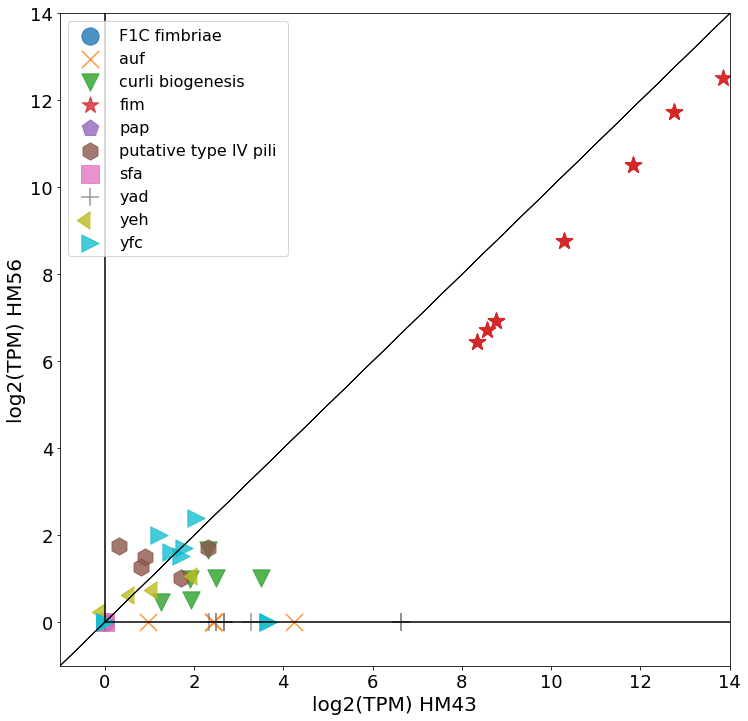

In [231]:
f, d = graph_group_expression_by_description(ad_df, "HM43", "HM56", norm_counts2)
plt.plot((0,0), (0,14), "k-")
plt.plot((14,0), (0,0), 'k-')

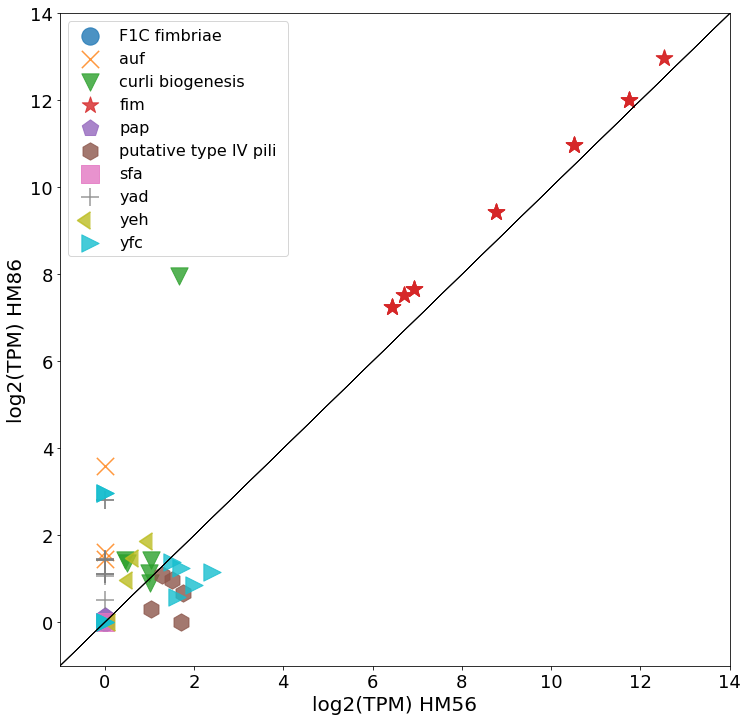

In [232]:
f, d = graph_group_expression_by_description(ad_df, "HM56", "HM86", norm_counts2)

In [209]:
fgroups['Functional Group'].unique()

array(['Iron Acquisition', 'Iron Acquistion', 'adherence', 'toxin',
       'motility', 'efflux pumps', 'transporter', 'metabolism'], dtype=object)

In [18]:
mot_df = gene_sets['motility']
mot_expr = get_expression(mot_df, strains, norm_counts2, prefix="_UTI")

mot_expr.head()

/anaconda/envs/biology/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  


,HM01,HM03,HM06,HM07,HM14,HM17,HM43,HM54,HM56,HM57,HM60,HM68,HM86
flgB,0.000000,4.920680,2.052678,8.671196,8.330137,5.334613,5.622242,0.998679,1.490233,2.543353,3.086314,3.003512,4.399320
flgC,1.064826,5.554314,1.256738,8.845195,9.298951,5.127262,4.495603,1.439905,1.655221,3.080539,3.496684,3.040541,3.622920
flgE,1.189859,6.547148,2.614618,9.961902,9.875980,5.864951,6.049362,2.327771,2.876264,3.923306,4.046251,3.099783,4.433136
flgF,1.116743,4.376326,1.897758,7.856023,6.263369,4.169531,3.815932,0.242850,1.330146,2.660372,1.248681,2.132325,3.573266
flgG,0.884533,4.652463,1.762525,8.036815,7.657419,4.167848,4.313225,1.162848,1.720379,NaN,1.219539,2.243107,3.173176


In [19]:
mot_expr = mot_expr.reset_index()
mot_expr = pd.melt(mot_expr, id_vars=['index'], value_vars=strains, value_name='Expr')


In [20]:
mot_expr = mot_expr.sort_values('Expr')

In [107]:
fim_genes = 'c5393 c5394 c5395 c5396 c5397 c5399'.split()
fim_df = orth_matrix[orth_matrix['CFT073'].isin(fim_genes)]

In [108]:
fim_expr = get_expression(fim_df, strains, norm_counts2, prefix="_UTI").reset_index()
x = pd.melt(fim_expr, id_vars=['index'], value_vars=strains, value_name='Expr')

(array([  0.,   2.,   4.,   6.,   8.,  10.,  12.,  14.,  16.]),
 <a list of 9 Text yticklabel objects>)

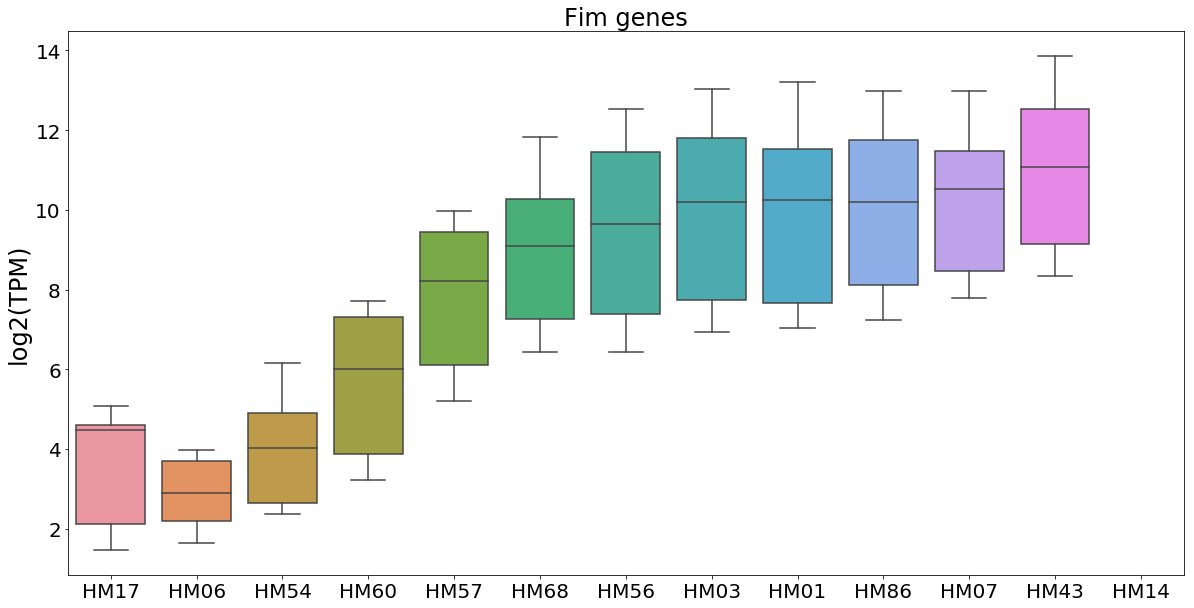

In [110]:
plt.figure(figsize=(20,10))
sns.boxplot(x='variable', y='Expr', data=x.sort_values('Expr'))
plt.title("Fim genes", fontsize=24)
plt.ylabel("log2(TPM)", fontsize=24)
plt.xlabel("")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

In [113]:
t = fim_expr.mean()

(array([ -2.,   0.,   2.,   4.,   6.,   8.,  10.,  12.]),
 <a list of 8 Text yticklabel objects>)

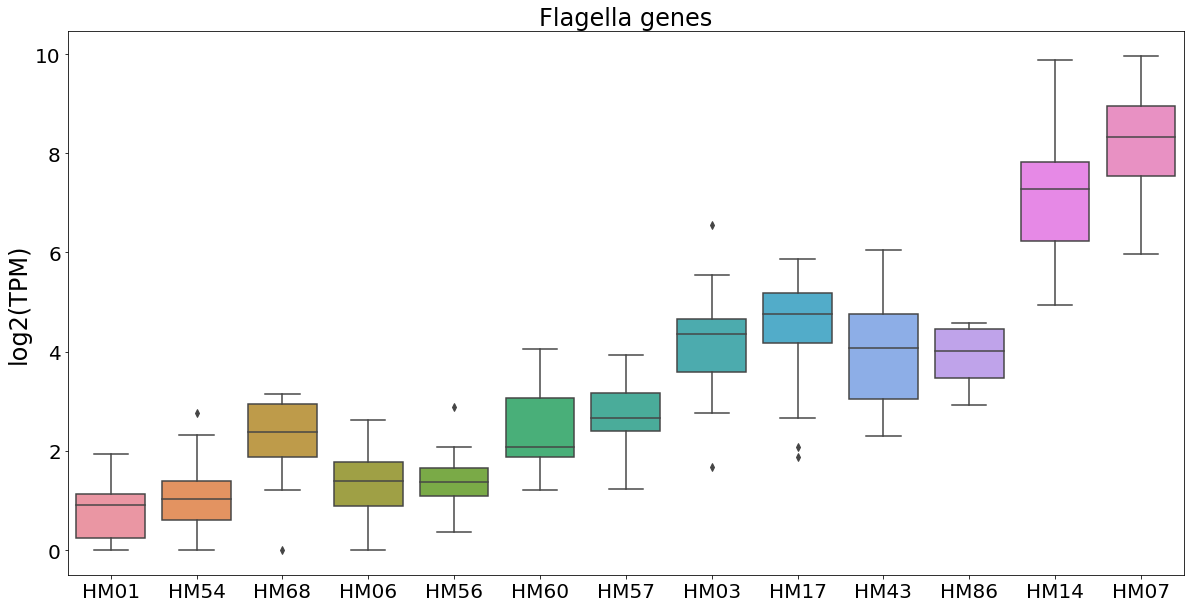

In [114]:
#Flagella
fim_genes = "c1342 c1343 c1344 c1345 c1346 c1347 c2336 c2337 c2353 c2354 c2355 c2357 c2358 c2359 c2360 c2361 c2362 c2363 c2364 c2365".split()
fim_df = orth_matrix[orth_matrix['CFT073'].isin(fim_genes)]
fim_expr = get_expression(fim_df, strains, norm_counts2, prefix="_UTI").reset_index()
x = pd.melt(fim_expr, id_vars=['index'], value_vars=strains, value_name='Expr')
plt.figure(figsize=(20,10))
sns.boxplot(x='variable', y='Expr', data=x.sort_values('Expr'))
plt.title("Flagella genes", fontsize=24)
plt.ylabel("log2(TPM)", fontsize=24)
plt.xlabel("")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

(array([  0.,   2.,   4.,   6.,   8.,  10.,  12.]),
 <a list of 7 Text yticklabel objects>)

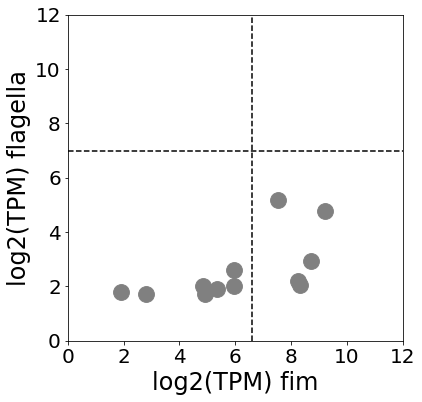

In [220]:
# flg in ur
fim_genes = "c1342 c1343 c1344 c1345 c1346 c1347 c2336 c2337 c2353 c2354 c2355 c2357 c2358 c2359 c2360 c2361 c2362 c2363 c2364 c2365".split()
fim_df = orth_matrix[orth_matrix['CFT073'].isin(fim_genes)]
fim_expr = get_expression(fim_df, strains, unorm_counts2, prefix="_UR").reset_index()
flg = fim_expr.mean()

fim_genes = 'c5393 c5394 c5395 c5396 c5397 c5399'.split()
fim_df = orth_matrix[orth_matrix['CFT073'].isin(fim_genes)]
fim_expr = get_expression(fim_df, strains, unorm_counts2, prefix="_UR").reset_index()
fim = fim_expr.mean()
plt.figure(figsize=(6,6))

q2 = pd.DataFrame([fim, flg], index=('fim', 'flg')).T
plt.scatter(q2.fim, q2.flg, color='grey', s=250)
plt.plot((6.6,6.6), (0,14), 'k--')
#plt.plot((9.96,9.96), (0,14), 'k--')
#plt.plot((0,14), (9.96,9.96), 'k--')
plt.plot((0,14), (7,7), 'k--')
plt.ylim(0,12)
plt.xlim(0,12)
plt.ylabel("log2(TPM) flagella", fontsize=24)
plt.xlabel("log2(TPM) fim", fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

In [132]:
s = fim_expr.mean()

In [175]:
q

,fim,flg
HM01,5.948714,2.026809
HM03,7.537871,5.185342
HM06,2.792663,1.710032
HM07,5.972343,2.618007
HM14,NaN,1.631953
HM17,8.725833,2.922118
HM43,9.209459,4.766213
HM54,4.934247,1.712894
HM56,8.322002,2.066115
HM57,5.353356,1.893591


,Fim,Flagella
HM01,9.907656,0.686901
HM03,9.932665,3.741976
HM06,2.889263,1.131413
HM07,10.229409,7.903789
HM14,NaN,6.614267
HM17,3.551837,4.156585
HM43,10.972741,3.595960
HM54,3.989089,0.986206
HM56,9.487457,1.159528
HM57,7.812615,2.612620


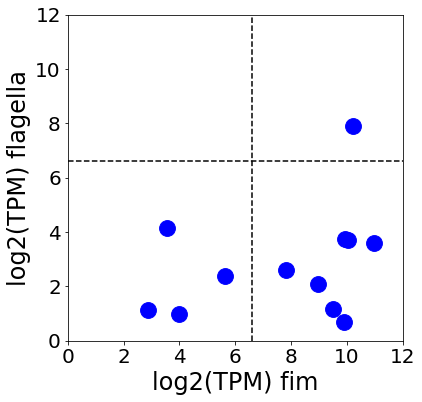

In [219]:
q = pd.DataFrame([t, s], index=['Fim', 'Flagella']).T
plt.figure(figsize=(6,6))
plt.scatter(q.Fim, q.Flagella, color='blue', s=250)
plt.plot((6.6,6.6), (0,14), 'k--')
#plt.plot((9.96,9.96), (0,14), 'k--')
plt.plot((0,14), (6.6,6.6), 'k--')
#plt.plot((0,14), (9.96,9.96), 'k--')
#plt.plot(7.5,4.3, 'ro', markersize=15, label='LB')
#plt.plot(6.9,2.5, 'ko', markersize=15, label='UR')
#plt.plot(10.6,3.7, 'go', markersize=15, label='UTI')
plt.ylim(0,12)
plt.xlim(0,12)
plt.ylabel("log2(TPM) flagella", fontsize=24)
plt.xlabel("log2(TPM) fim", fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

q

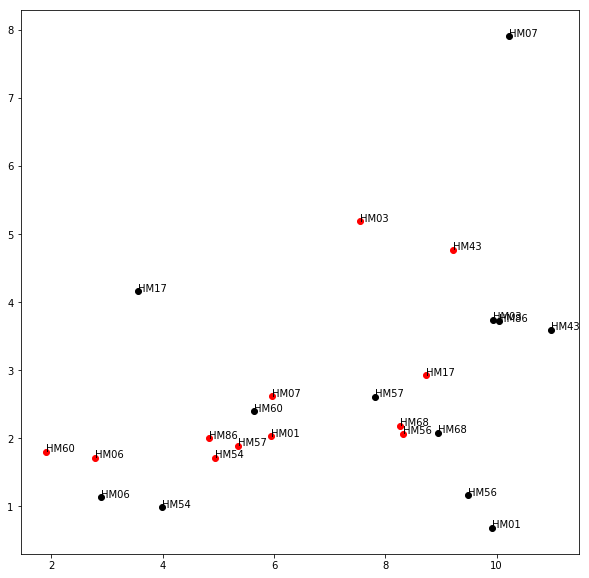

In [210]:
last=q.merge(q2, left_index=True, right_index=True).dropna()
last.columns = ['fim_uti', 'flg_uti', 'fim_ur', 'flg_ur']
last
plt.figure(figsize=(10,10))
x = last.fim_ur.values
y = last.flg_ur.values
w = last.fim_uti.values
z = last.flg_uti.values
plt.scatter(last.fim_ur, last.flg_ur, color='red')
plt.scatter(last.fim_uti, last.flg_uti, color='black')
for i, txt in enumerate(last.index):
    plt.annotate( txt, (x[i], y[i]),)
    plt.annotate(txt, (w[i], z[i]))

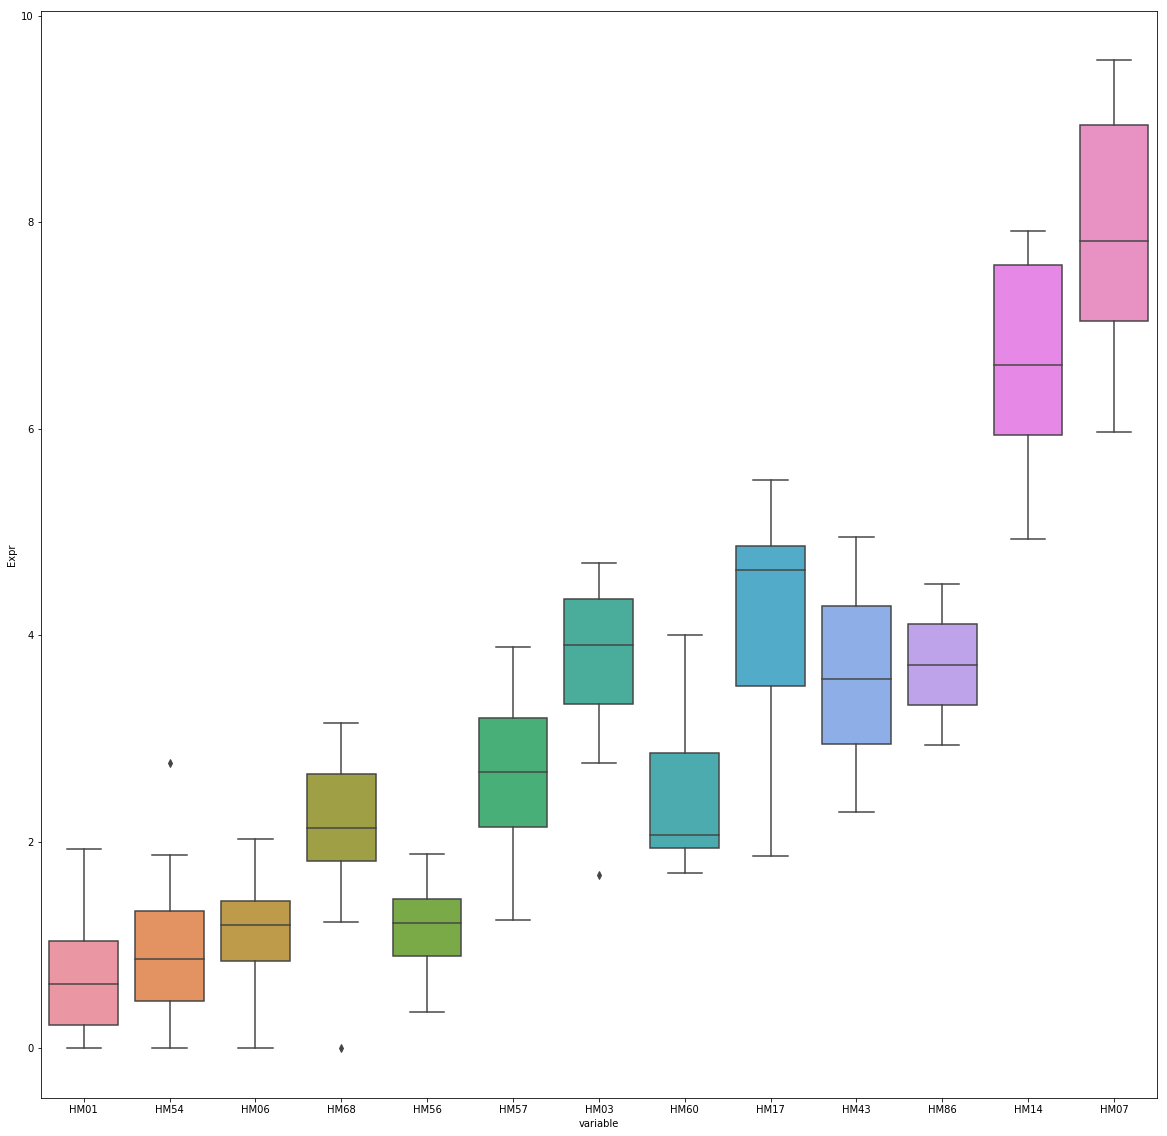

In [131]:
fim_genes = "c2336 c2337 c2353 c2354 c2355 c2357 c2358 c2359 c2360 c2361 c2362 c2363 c2364 c2365".split()
fim_df = orth_matrix[orth_matrix['CFT073'].isin(fim_genes)]
fim_expr = get_expression(fim_df, strains, norm_counts2, prefix="_UTI").reset_index()
x = pd.melt(fim_expr, id_vars=['index'], value_vars=strains, value_name='Expr')
plt.figure(figsize=(20,20))
sns.boxplot(x='variable', y='Expr', data=x.sort_values('Expr'))

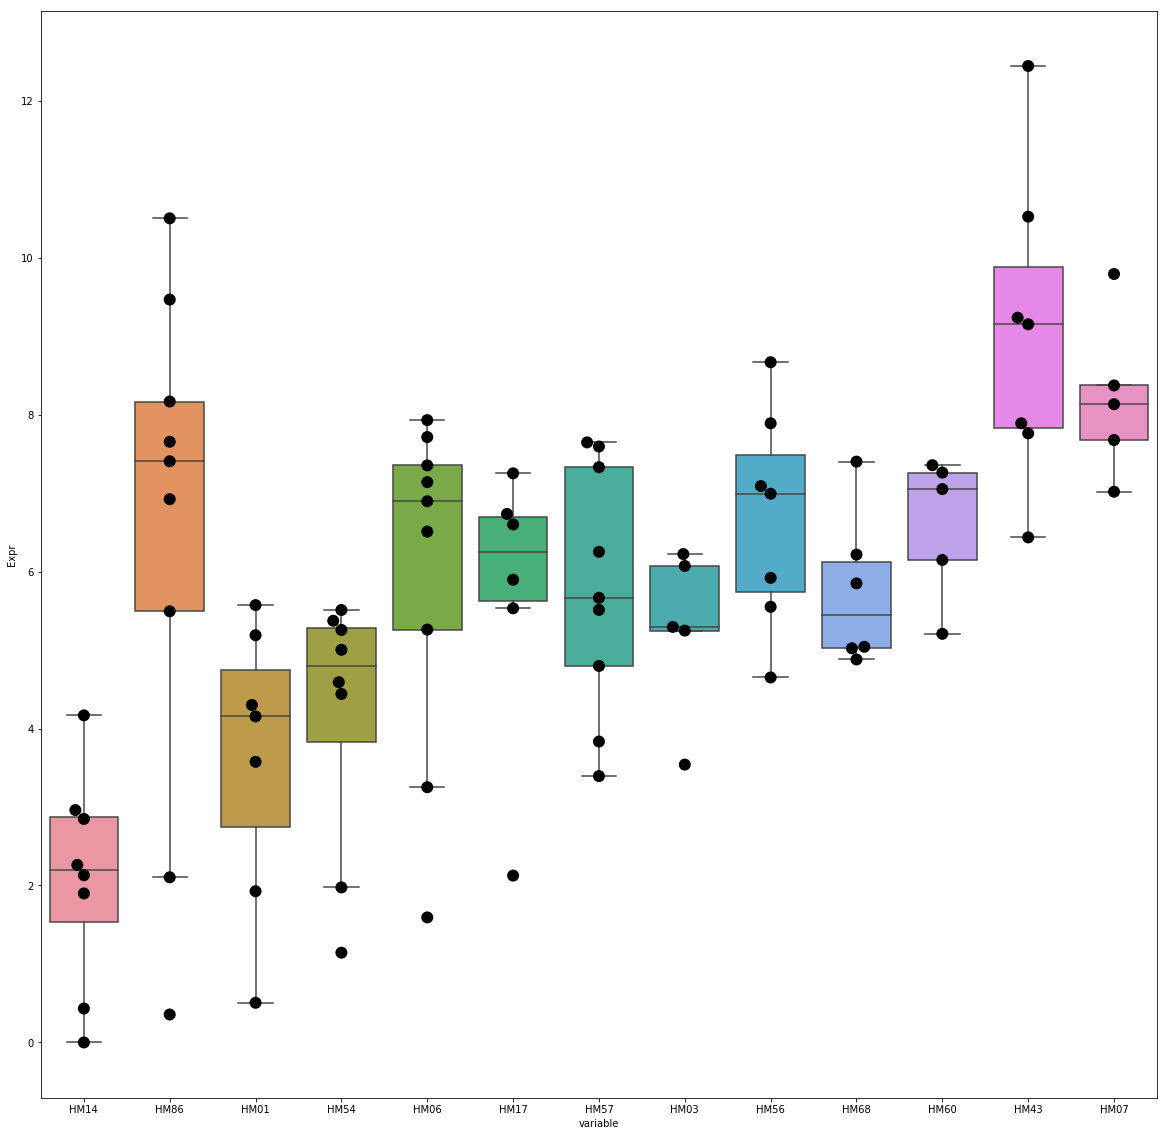

In [21]:
#Iron
fim_genes = 'c0890 c2690 c2433 c3625 c3627 c4308 c0682 c0680 c0668'.split()
fim_df = orth_matrix[orth_matrix['CFT073'].isin(fim_genes)]
fim_expr = get_expression(fim_df, strains, norm_counts2, prefix="_UTI").reset_index()
x = pd.melt(fim_expr, id_vars=['index'], value_vars=strains, value_name='Expr')
plt.figure(figsize=(20,20))
#sns.boxplot(x='variable', y='Expr', data=x.sort_values('Expr'))
X = x.sort_values('Expr').variable.values

Y = x.sort_values('Expr').Expr.values
sns.boxplot(x='variable', y='Expr', data=x.sort_values('Expr'))
sns.swarmplot(x='variable', y='Expr', data=x.sort_values('Expr'), color='black', size=12)

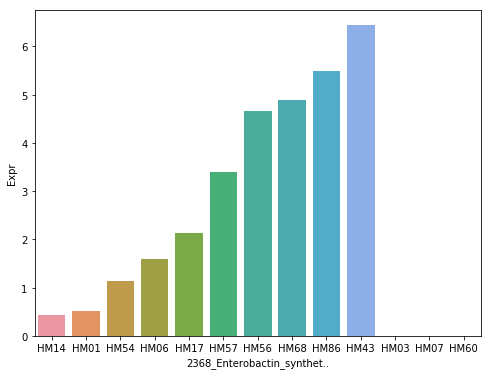

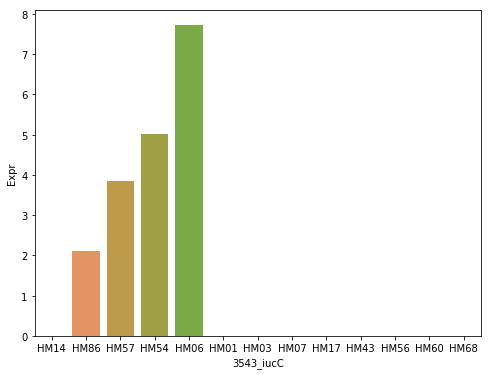

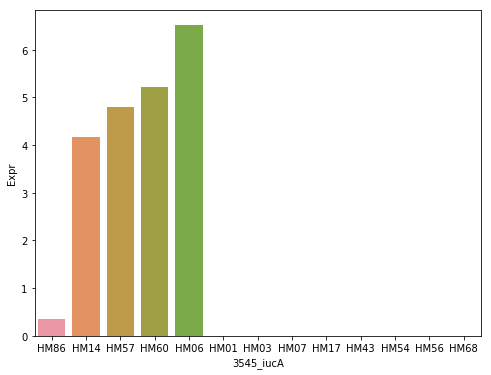

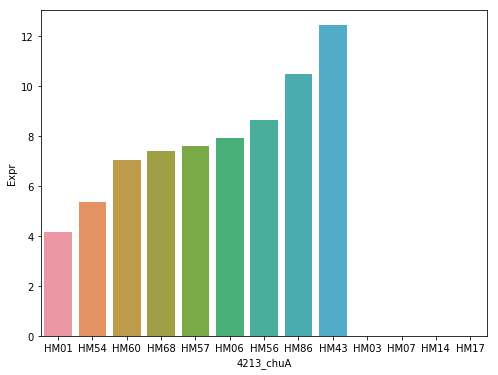

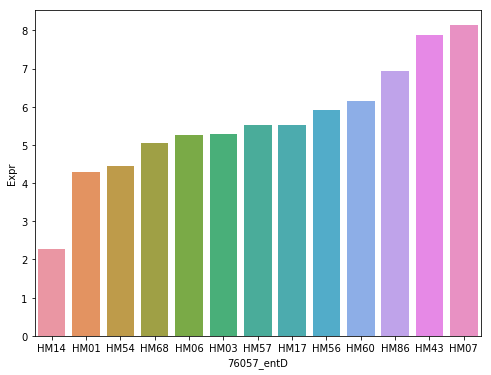

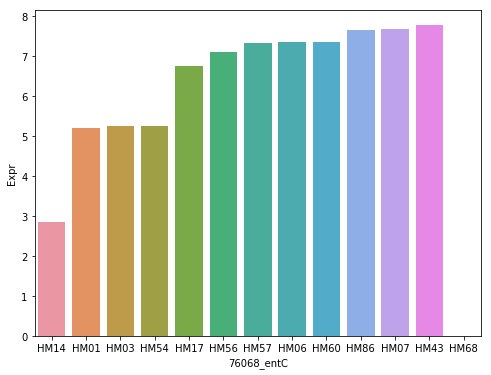

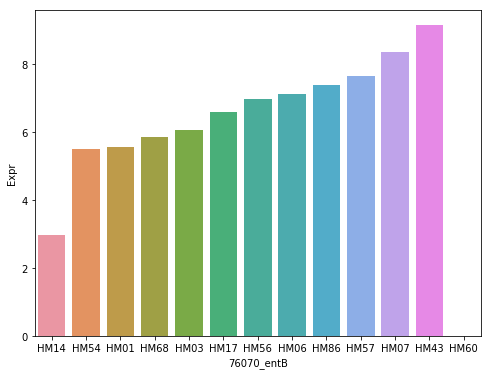

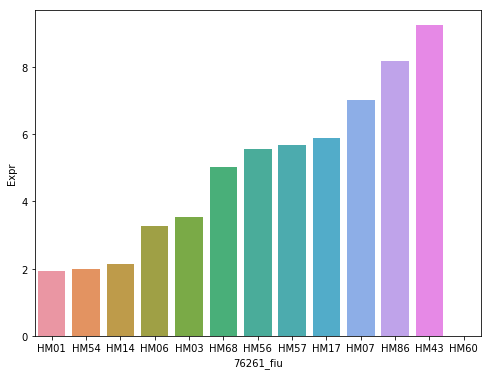

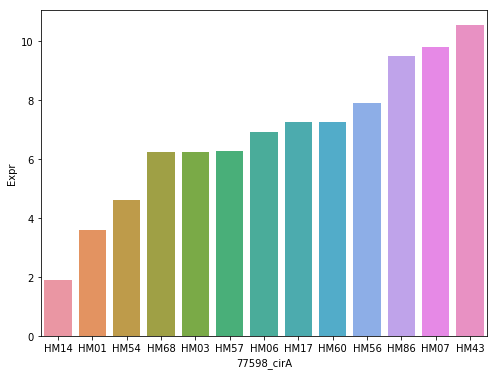

In [24]:

for i,g in x.groupby('index'):
    plt.figure(figsize=(8,6))
    s =sns.barplot(x='variable', y='Expr', data=g.sort_values('Expr'))
    plt.xlabel(i)

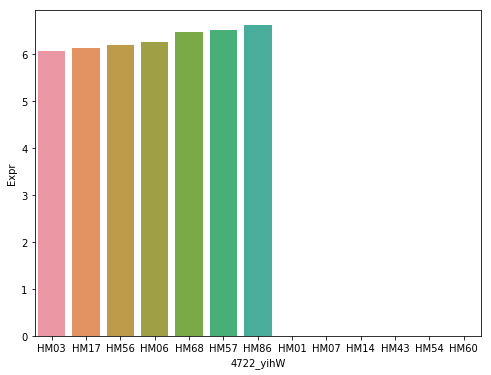

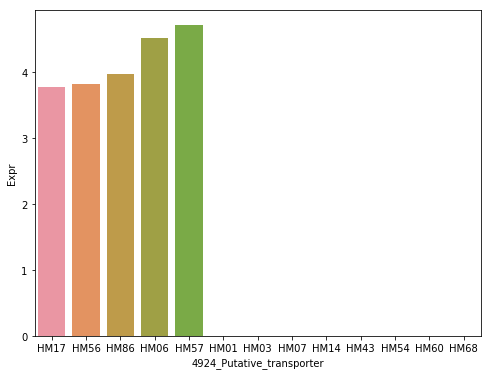

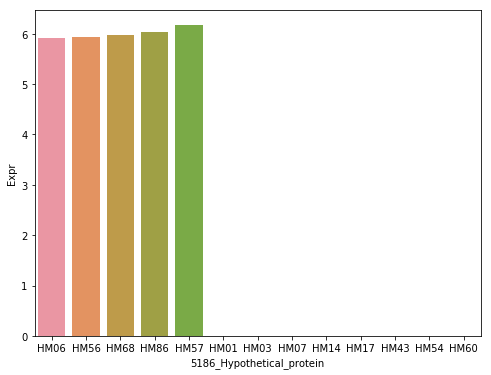

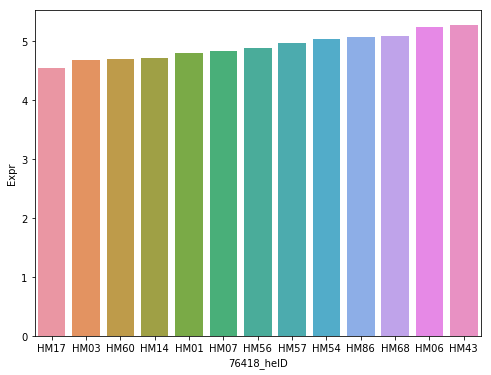

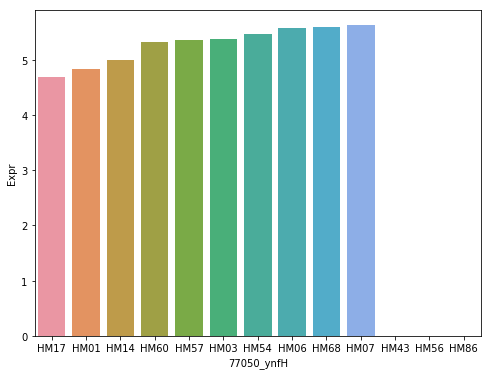

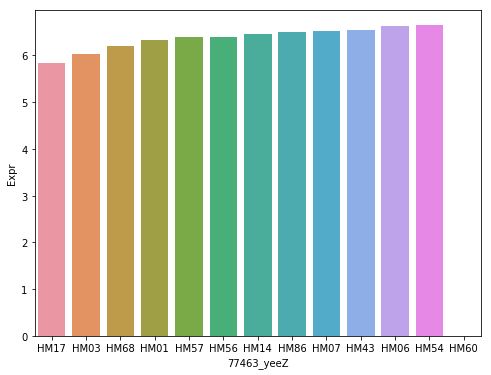

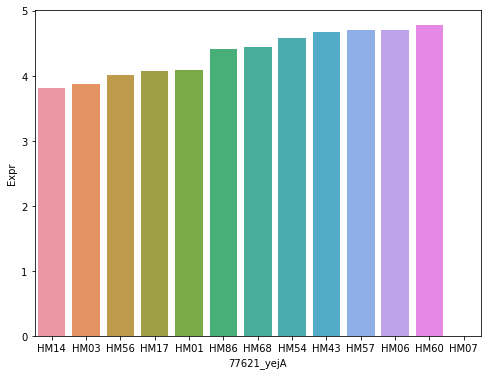

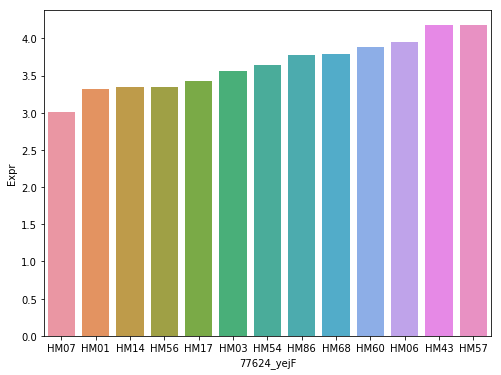

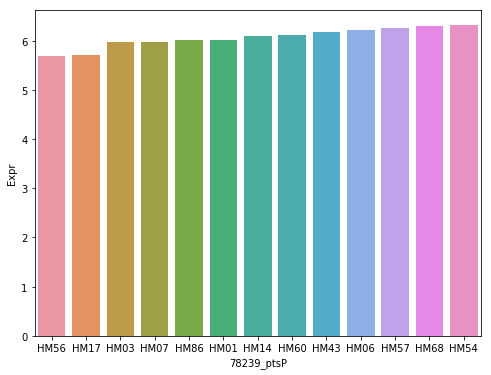

In [44]:
fim_genes = "c1099 c5029 c3424 c4824 c2714 c5296 c1981 c2717 c2543".split()
fim_df = orth_matrix[orth_matrix['CFT073'].isin(fim_genes)]
fim_expr = get_expression(fim_df, strains, norm_counts2, prefix="_UTI").reset_index()
x = pd.melt(fim_expr, id_vars=['index'], value_vars=strains, value_name='Expr')
for i,g in x.groupby('index'):
    plt.figure(figsize=(8,6))
    s =sns.barplot(x='variable', y='Expr', data=g.sort_values('Expr'))
    plt.xlabel(i)

In [30]:
mot_expr[mot_expr['index']=="flgG"]

,index,variable,Expr
4,flgG,HM01,0.884533
186,flgG,HM54,1.162848
264,flgG,HM60,1.219539
212,flgG,HM56,1.720379
56,flgG,HM06,1.762525
290,flgG,HM68,2.243107
316,flgG,HM86,3.173176
134,flgG,HM17,4.167848
160,flgG,HM43,4.313225
30,flgG,HM03,4.652463


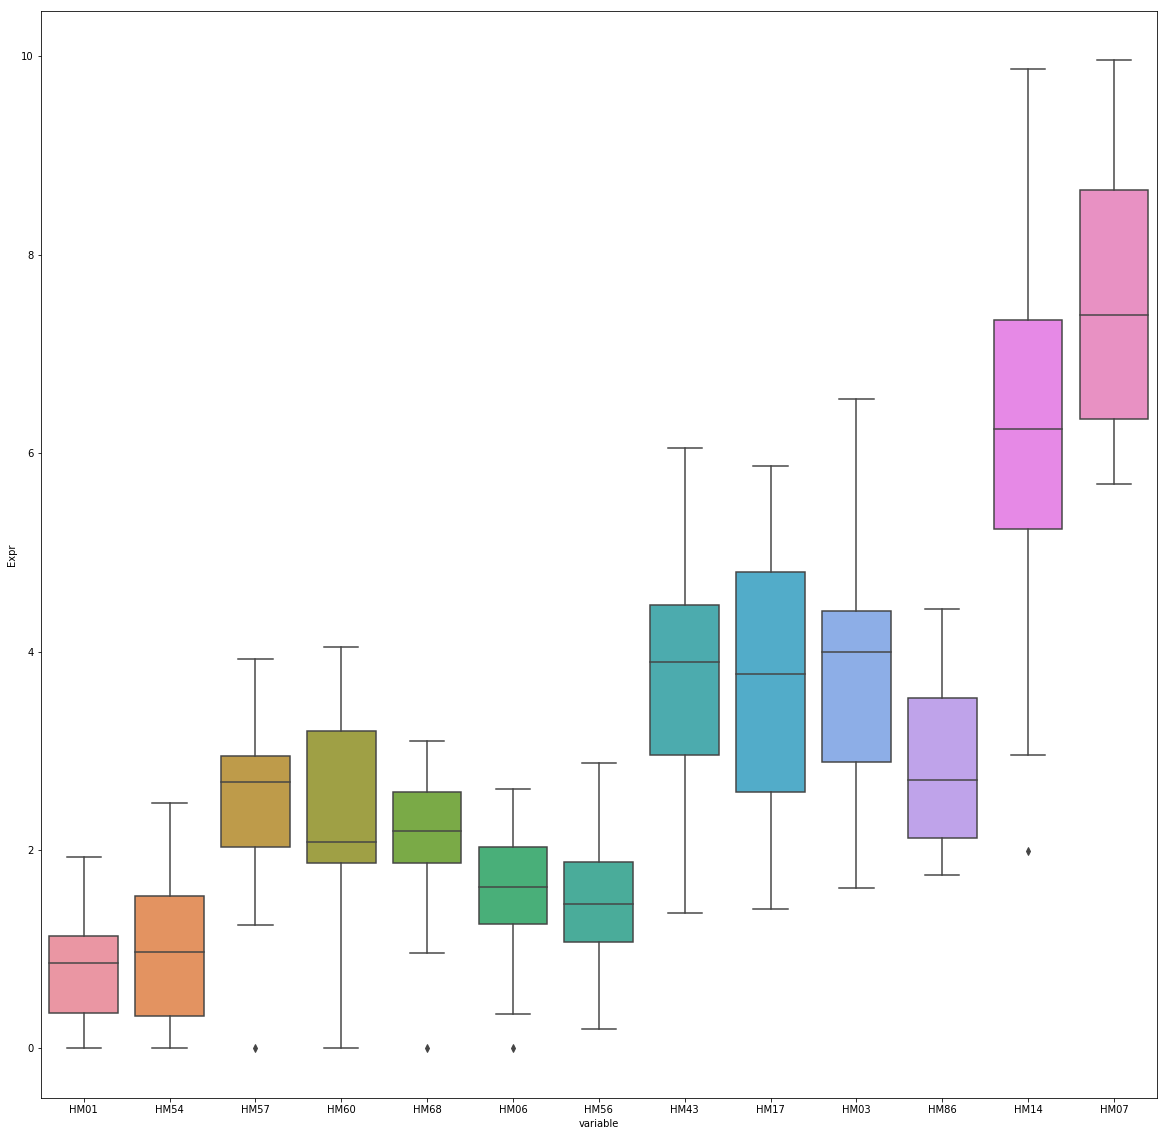

In [25]:
plt.figure(figsize=(20,20))
sns.boxplot(x='variable', y='Expr', data=mot_expr)
#plt.plot((0.5,0.5), (0.5, 10), 'k--', linewidth=3)
#plt.plot((1.5,1.5), (0.5, 10), 'k--', linewidth=3)

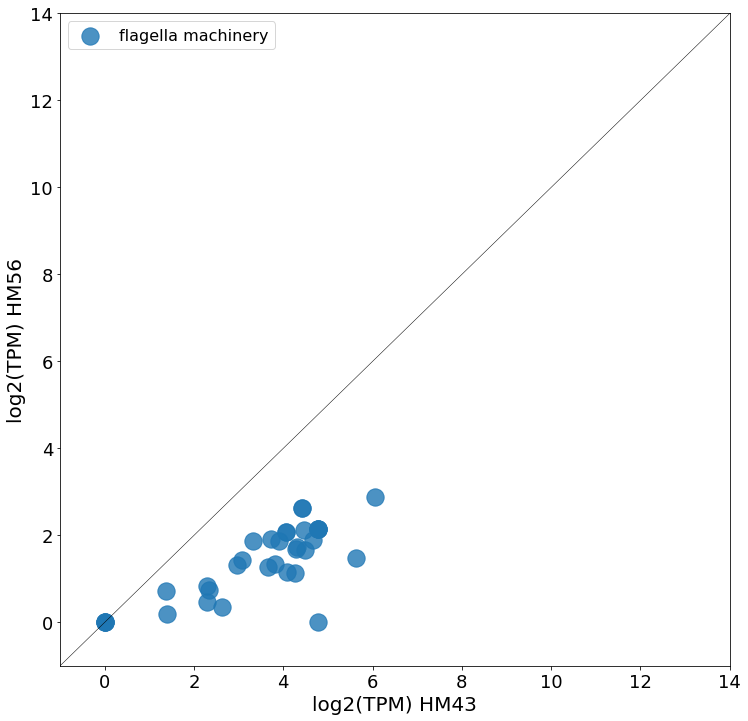

In [206]:
f, d = graph_group_expression_by_description(mot_df, "HM43", "HM56", norm_counts2)

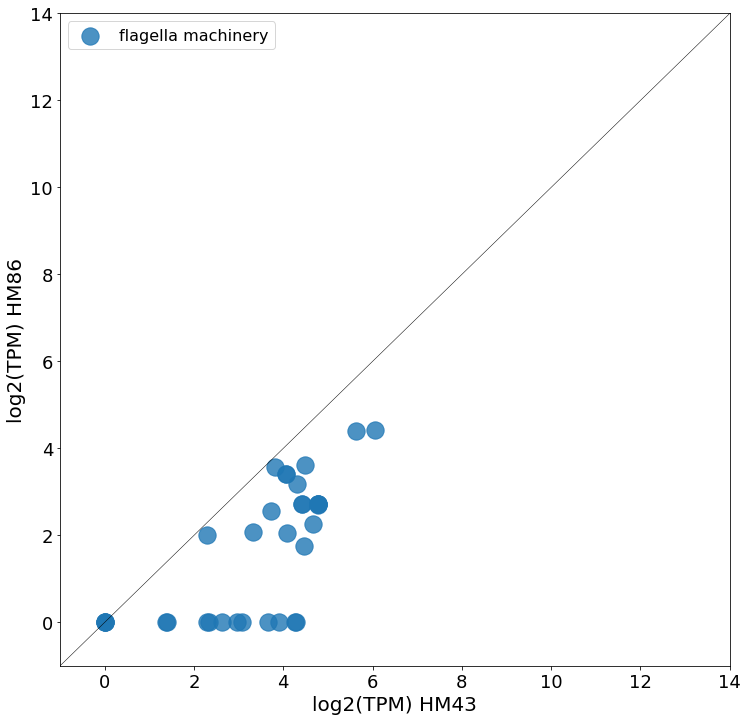

In [207]:
f, d = graph_group_expression_by_description(mot_df, "HM43", "HM86", norm_counts2)

In [26]:
x = test_matrix.join(functions[functions.genome == "UTI89"], on='UTI89')
x[x.UTI89 == "UTI89_C5035"]

,536,CFT073,F11,HM01,HM03,HM06,HM07,HM14,HM17,HM43,...,HM60,HM66,HM68,HM86,K-12,UMN026,UTI89,gene,function,genome
36534_FAD_dependent_oxidor..,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PROKKA_01659,...,NaN,PROKKA_03327,PROKKA_04087,NaN,NaN,NaN,UTI89_C5035,ibeA,Other,UTI89


In [30]:
functions.genome


c3623          CFT073
c4308          CFT073
c2482          CFT073
c1250          CFT073
c0185          CFT073
c3610          CFT073
c5174          CFT073
c4186          CFT073
c3625          CFT073
c1646          CFT073
UTI89_C2188     UTI89
c3570          CFT073
c0393          CFT073
c0350          CFT073
c3619          CFT073
UTI89_C4921     UTI89
c5393          CFT073
c5400          CFT073
c1245          CFT073
c1936          CFT073
c0166          CFT073
c2635          CFT073
c4207          CFT073
c4210          CFT073
c2884          CFT073
c2883          CFT073
c2394          CFT073
c2395          CFT073
c0400          CFT073
c0405          CFT073
c2302          CFT073
c2297          CFT073
c1340          CFT073
c2304          CFT073
c2305          CFT073
c4293          CFT073
c3990          CFT073
c5430          CFT073
c0652          CFT073
UTI89_C5035     UTI89
Name: genome, dtype: object

In [198]:
for name, g in functions.groupby(['function','genome']):
    function = name[0]
    genome = name[1]
    genes = g.index
    
    print(name)
    #df = matrix[matrix[genome].isin(genes)].join(g['gene'], on=genome, how='left')
    
    


('Adhesins', 'CFT073')
('Iron Acquisition', 'CFT073')
('Iron Acquisition', 'UTI89')
('Motility', 'CFT073')
('Other', 'CFT073')
('Other', 'UTI89')
('Toxins', 'CFT073')
('Toxins', 'UTI89')


In [196]:
df

,536,CFT073,F11,HM01,HM03,HM06,HM07,HM14,HM17,HM43,...,HM56,HM57,HM60,HM66,HM68,HM86,K-12,UMN026,UTI89,gene
75778_ecpR,ECP_RS01795,c0405,AS527_RS03395,PROKKA_04780,PROKKA_03267,PROKKA_03988,PROKKA_04732,PROKKA_00112,PROKKA_01430,PROKKA_01213,...,PROKKA_04348,PROKKA_04024,PROKKA_03026,PROKKA_03822,PROKKA_04539,PROKKA_04602,b0294,ECUMN_0328,UTI89_C0310,matA
4114_Putative_fimbrial_ad..,ECP_RS17920,c4207,AS527_RS07440,PROKKA_03261,NaN,NaN,NaN,NaN,PROKKA_02993,PROKKA_02708,...,NaN,PROKKA_02416,NaN,PROKKA_02299,PROKKA_02906,PROKKA_01062,NaN,ECUMN_3885,NaN,aufA
2329_PilV-like_protein,ECP_RS09790,c2394,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PROKKA_04298,...,PROKKA_02701,PROKKA_00638,NaN,PROKKA_00638,PROKKA_01346,NaN,NaN,NaN,NaN,pilV-like
77552_yehA,ECP_RS10920,c2635,AS527_RS13020,PROKKA_01870,PROKKA_00464,PROKKA_00904,PROKKA_01678,PROKKA_02152,PROKKA_04427,PROKKA_04085,...,PROKKA_02492,PROKKA_00941,NaN,PROKKA_00921,PROKKA_01568,PROKKA_02572,b2108,ECUMN_2440,UTI89_C2382,yehA
2330_Putative_type_IV_pil..,ECP_RS09795,c2395,NaN,NaN,NaN,NaN,NaN,NaN,PROKKA_04679,PROKKA_04297,...,PROKKA_02700,PROKKA_00639,NaN,PROKKA_00639,PROKKA_01347,PROKKA_02819,NaN,NaN,NaN,pilin
1202_focH,ECP_RS01505,c1245,NaN,NaN,NaN,NaN,NaN,NaN,PROKKA_00650,NaN,...,NaN,NaN,NaN,PROKKA_04598,PROKKA_00353 PROKKA_03892,NaN,NaN,NaN,UTI89_C1115,focH


In [172]:
df

,536,CFT073,F11,HM01,HM03,HM06,HM07,HM14,HM17,HM43,HM54,HM56,HM57,HM60,HM66,HM68,HM86,K-12,UMN026,UTI89
75778_ecpR,ECP_RS01795,c0405,AS527_RS03395,PROKKA_04780,PROKKA_03267,PROKKA_03988,PROKKA_04732,PROKKA_00112,PROKKA_01430,PROKKA_01213,PROKKA_02061,PROKKA_04348,PROKKA_04024,PROKKA_03026,PROKKA_03822,PROKKA_04539,PROKKA_04602,b0294,ECUMN_0328,UTI89_C0310
4114_Putative_fimbrial_ad..,ECP_RS17920,c4207,AS527_RS07440,PROKKA_03261,NaN,NaN,NaN,NaN,PROKKA_02993,PROKKA_02708,PROKKA_00443,NaN,PROKKA_02416,NaN,PROKKA_02299,PROKKA_02906,PROKKA_01062,NaN,ECUMN_3885,NaN
2329_PilV-like_protein,ECP_RS09790,c2394,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PROKKA_04298,NaN,PROKKA_02701,PROKKA_00638,NaN,PROKKA_00638,PROKKA_01346,NaN,NaN,NaN,NaN
77552_yehA,ECP_RS10920,c2635,AS527_RS13020,PROKKA_01870,PROKKA_00464,PROKKA_00904,PROKKA_01678,PROKKA_02152,PROKKA_04427,PROKKA_04085,PROKKA_04136,PROKKA_02492,PROKKA_00941,NaN,PROKKA_00921,PROKKA_01568,PROKKA_02572,b2108,ECUMN_2440,UTI89_C2382
2330_Putative_type_IV_pil..,ECP_RS09795,c2395,NaN,NaN,NaN,NaN,NaN,NaN,PROKKA_04679,PROKKA_04297,NaN,PROKKA_02700,PROKKA_00639,NaN,PROKKA_00639,PROKKA_01347,PROKKA_02819,NaN,NaN,NaN
1202_focH,ECP_RS01505,c1245,NaN,NaN,NaN,NaN,NaN,NaN,PROKKA_00650,NaN,NaN,NaN,NaN,NaN,PROKKA_04598,PROKKA_00353 PROKKA_03892,NaN,NaN,NaN,UTI89_C1115


In [175]:
[c for c in matrix.index if 'fim' in c]

['88494_type_1_fimbrial_prot..',
 '18445_fimC_2',
 '2823_Type_1_fimbriae_Regu..',
 '8832_fimA_3',
 '58318_fimD_4',
 '18444_fimA_3',
 '86218_type_1_fimbrial_prot..',
 '79647_fimE',
 '49537_putative_fimbrial-li..',
 '56268_fimD_3',
 '87666_type_1_fimbrial_prot..',
 '4121_Putative_major_fimbr..',
 '4114_Putative_fimbrial_ad..',
 '26582_fimD_3',
 '31766_fimD_6',
 '53010_F17d-G_fimbrial_adhe..',
 '2822_Type_1_fimbriae_Regu..',
 '88489_type_1_fimbrial_prot..',
 '65115_fimD_5',
 '87662_fimbrial_protein',
 '24197_putative_fimbrial_ou..',
 '88492_fimbrial_biogenesis_..',
 '23460_fimD_2']

In [185]:
matrix[matrix["HM03"] == "PROKKA_02808"]

,536,CFT073,F11,HM01,HM03,HM06,HM07,HM14,HM17,HM43,HM54,HM56,HM57,HM60,HM66,HM68,HM86,K-12,UMN026,UTI89


In [176]:
pa_table

,HM01,HM03,HM06,HM07,HM14,HM17,HM43,HM54,HM56,HM57,HM60,HM66,HM68,HM86
c0166,NaN,NaN,NaN,NaN,NaN,PROKKA_01705,PROKKA_01414,PROKKA_01859,NaN,PROKKA_03810,PROKKA_03273,PROKKA_03558,PROKKA_04319,PROKKA_04755
c0185,PROKKA_04585,PROKKA_03080,PROKKA_03836,PROKKA_04519,PROKKA_04767,PROKKA_01690,PROKKA_01398,PROKKA_01874,PROKKA_04563,PROKKA_03825,PROKKA_03253,PROKKA_03574,PROKKA_04334,PROKKA_04737
c0350,NaN,NaN,PROKKA_03318,NaN,NaN,PROKKA_01536,NaN,NaN,PROKKA_00261,PROKKA_03975,NaN,PROKKA_03718,NaN,NaN
c0393,NaN,NaN,NaN,NaN,NaN,PROKKA_01439,NaN,PROKKA_02050,PROKKA_04358,PROKKA_04013,NaN,PROKKA_03810,PROKKA_04527,PROKKA_04613
c0400,PROKKA_04774,PROKKA_03259,PROKKA_03982,PROKKA_04727,PROKKA_00106,PROKKA_01435,PROKKA_01218,PROKKA_02055,PROKKA_04353,PROKKA_04018,PROKKA_03030,PROKKA_03815,PROKKA_04533,PROKKA_04607
c0405,PROKKA_04780,PROKKA_03267,PROKKA_03988,PROKKA_04734,PROKKA_00112,PROKKA_01430,PROKKA_01213,PROKKA_02061,PROKKA_04348,PROKKA_04024,PROKKA_03026,PROKKA_03822,PROKKA_04539,PROKKA_04602
c0652,PROKKA_00034,NaN,PROKKA_04226,PROKKA_02659,PROKKA_00433,PROKKA_01185,PROKKA_00977,PROKKA_02302,PROKKA_04964,PROKKA_04253,NaN,PROKKA_04058,PROKKA_04770,PROKKA_04352
c1245,NaN,NaN,NaN,NaN,NaN,PROKKA_00650,NaN,NaN,NaN,NaN,NaN,PROKKA_04597,PROKKA_00352,NaN
c1250,NaN,NaN,NaN,NaN,NaN,PROKKA_00644,NaN,NaN,PROKKA_04968,NaN,PROKKA_06070,PROKKA_04602,PROKKA_00357,PROKKA_03864
c1646,PROKKA_00749,NaN,PROKKA_05024,NaN,NaN,PROKKA_00310,PROKKA_00363,PROKKA_03014,PROKKA_03463,PROKKA_05006,PROKKA_01172,PROKKA_04931,PROKKA_00604,PROKKA_03563


In [118]:
matrix.head()

,536,CFT073,F11,HM01,HM03,HM06,HM07,HM14,HM17,HM43,HM54,HM56,HM57,HM60,HM66,HM68,HM86,K-12,UMN026,UTI89
10586_hypothetical_protein,NaN,NaN,NaN,NaN,PROKKA_00202,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
53065_hypothetical_protein,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PROKKA_03537,PROKKA_04257,NaN,NaN,NaN,NaN,NaN,NaN
2117_Hypothetical_protein,NaN,c2180,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
76482_pgaA,ECP_RS05180,c1163,AS527_RS02460,NaN,PROKKA_03993,PROKKA_04812,NaN,PROKKA_00994,NaN,NaN,NaN,PROKKA_03670,PROKKA_04695,PROKKA_01001,PROKKA_04518,PROKKA_00324,PROKKA_03894,b1024,NaN,UTI89_C1087
5423_hypothetical_protein,NaN,NaN,NaN,PROKKA_00045,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ECUMN_0649,NaN


In [113]:
pa_table = pd.read_csv(pa_path, index_col = 0)

In [115]:
pa_table.replace('0', np.nan, inplace=True)

In [116]:
pa_table

,HM01,HM03,HM06,HM07,HM14,HM17,HM43,HM54,HM56,HM57,HM60,HM66,HM68,HM86
c0166,NaN,NaN,NaN,NaN,NaN,PROKKA_01705,PROKKA_01414,PROKKA_01859,NaN,PROKKA_03810,PROKKA_03273,PROKKA_03558,PROKKA_04319,PROKKA_04755
c0185,PROKKA_04585,PROKKA_03080,PROKKA_03836,PROKKA_04519,PROKKA_04767,PROKKA_01690,PROKKA_01398,PROKKA_01874,PROKKA_04563,PROKKA_03825,PROKKA_03253,PROKKA_03574,PROKKA_04334,PROKKA_04737
c0350,NaN,NaN,PROKKA_03318,NaN,NaN,PROKKA_01536,NaN,NaN,PROKKA_00261,PROKKA_03975,NaN,PROKKA_03718,NaN,NaN
c0393,NaN,NaN,NaN,NaN,NaN,PROKKA_01439,NaN,PROKKA_02050,PROKKA_04358,PROKKA_04013,NaN,PROKKA_03810,PROKKA_04527,PROKKA_04613
c0400,PROKKA_04774,PROKKA_03259,PROKKA_03982,PROKKA_04727,PROKKA_00106,PROKKA_01435,PROKKA_01218,PROKKA_02055,PROKKA_04353,PROKKA_04018,PROKKA_03030,PROKKA_03815,PROKKA_04533,PROKKA_04607
c0405,PROKKA_04780,PROKKA_03267,PROKKA_03988,PROKKA_04734,PROKKA_00112,PROKKA_01430,PROKKA_01213,PROKKA_02061,PROKKA_04348,PROKKA_04024,PROKKA_03026,PROKKA_03822,PROKKA_04539,PROKKA_04602
c0652,PROKKA_00034,NaN,PROKKA_04226,PROKKA_02659,PROKKA_00433,PROKKA_01185,PROKKA_00977,PROKKA_02302,PROKKA_04964,PROKKA_04253,NaN,PROKKA_04058,PROKKA_04770,PROKKA_04352
c1245,NaN,NaN,NaN,NaN,NaN,PROKKA_00650,NaN,NaN,NaN,NaN,NaN,PROKKA_04597,PROKKA_00352,NaN
c1250,NaN,NaN,NaN,NaN,NaN,PROKKA_00644,NaN,NaN,PROKKA_04968,NaN,PROKKA_06070,PROKKA_04602,PROKKA_00357,PROKKA_03864
c1646,PROKKA_00749,NaN,PROKKA_05024,NaN,NaN,PROKKA_00310,PROKKA_00363,PROKKA_03014,PROKKA_03463,PROKKA_05006,PROKKA_01172,PROKKA_04931,PROKKA_00604,PROKKA_03563


In [16]:
iron = functions[functions.function == "Adhesins"].iloc[:-1,:]

In [17]:
iron

,gene,function
,,
c5393,fimA,Adhesins
c5400,fimH,Adhesins
c1245,focH,Adhesins
c1936,ydeA,Adhesins
c0166,yadC,Adhesins
c2635,yehA,Adhesins
c4207,aufA,Adhesins
c4210,aufD,Adhesins
c2884,yfcV,Adhesins


In [18]:
t = pd.merge(iron[['gene']], pa_table, how="left", left_index=True, right_index=True).set_index(["gene"])

In [19]:
f = t.T.to_dict()

In [20]:
f['aufA']['HM01'] is np.nan

True

In [23]:
cnts["HM17_UTI"]["PROKKA_02993"]

-0.5719055062567975

In [49]:
def get_counts_for_matrix(matrix, cnts_dict):
    f = matrix.T.to_dict()
    fd = {}
    for gene, strain_dict in f.items():
        for strain, prk in strain_dict.items():
            if prk is np.nan :
                c = prk
            elif prk == "PARALOGS":
                c = np.nan
            else:
                c = cnts[strain +"_UTI"][prk]
            if gene in fd.keys():
                fd[gene][strain] = c
            else:
                fd[gene] = {strain:c}
    return pd.DataFrame(fd).T

In [51]:
var_counts = get_counts_for_matrix(variable, cnts)
var_counts.head()

,HM01,HM03,HM06,HM07,HM14,HM17,HM43,HM54,HM56,HM57,HM60,HM66,HM68,HM86
21_Putative_conserved_p...faa,NaN,NaN,0.035109,NaN,NaN,-1.061468,-0.931239,-0.241063,-1.329399,-0.922151,-0.257057,-1.285702,-1.084275,-0.914354
34_Hypothetical_protein.faa,NaN,NaN,-0.124377,NaN,NaN,-0.766116,-0.295283,NaN,-0.028554,-0.564908,NaN,-0.145160,-0.552285,NaN
40_Conserved_hypothetic...faa,-1.771959,-2.158783,-2.072984,-1.748515,-1.925959,NaN,NaN,NaN,-1.552053,NaN,-1.667878,NaN,NaN,-1.900342
76_Hypothetical_protein.faa,NaN,NaN,NaN,NaN,NaN,-0.664274,NaN,-0.743551,NaN,-1.997044,NaN,-1.285702,-0.821981,-0.912868
130_Hypothetical_protein.faa,NaN,NaN,-0.038958,NaN,NaN,0.174125,NaN,NaN,-0.027232,-0.605433,NaN,NaN,0.296647,-0.076894


In [60]:
var_counts.T.std().describe()

count    2248.000000
mean        0.360687
std         0.261739
min         0.001301
25%         0.172143
50%         0.299616
75%         0.486415
max         1.931625
dtype: float64

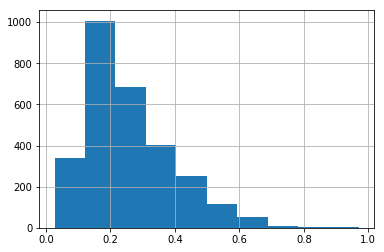

In [73]:
core_counts =  get_counts_for_matrix(core, cnts)
core_counts.T.std().hist()

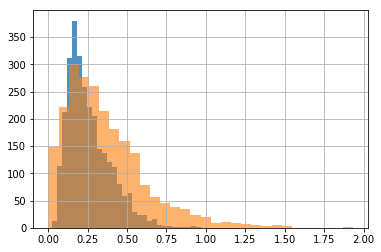

In [81]:
core_counts.T.std().hist(bins = 30, alpha=0.8)
var_counts.T.std().hist(bins = 30, alpha=0.6)

In [86]:
var_counts.isnull().sum(axis=1)


21_Putative_conserved_p...faa      4
34_Hypothetical_protein.faa        7
40_Conserved_hypothetic...faa      6
76_Hypothetical_protein.faa        8
130_Hypothetical_protein.faa       8
135_Putative_Transposase...faa    11
245_Hypothetical_protein.faa      11
248_Unknown_in_ISEc8.faa          11
253_Putative_Transposase.faa      11
256_Hypothetical_protein.faa      13
259_Hypothetical_protein.faa       8
264_Hypothetical_protein.faa       9
268_Hypothetical_protein.faa      11
269_Hypothetical_protein.faa      11
273_Conserved_hypothetic...faa     7
274_Conserved_hypothetic...faa     7
278_Hypothetical_protein.faa      12
280_Hypothetical_protein.faa      11
282_Hypothetical_protein.faa       8
283_Hypothetical_protein.faa       8
306_Putative_sugar-phosp...faa    10
307_Putative_oligogalact...faa    10
310_Putative_oligogalact...faa    10
311_Putative_exopolygala...faa    10
313_Hypothetical_protein.faa      10
314_Hypothetical_protein.faa      12
315_Conserved_hypothetic...faa    10
3

In [111]:
d

1.0
0.304786667538
2.0
0.280374649025
3.0
0.458239370634
4.0
0.278865342706
5.0
0.382381993177
6.0
0.348834899516
7.0
0.366629769704
8.0
0.33235939471
9.0
0.302155682208
10.0
0.341215805623
11.0
0.304499664697
12.0
0.23763587265
13.0
nan
14.0
nan


/anaconda/envs/biology/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:990: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


In [32]:
df = pd.DataFrame(fd).T
df.loc['fimH'].std()

0.70089984293373431

In [33]:
variable.head()

,HM07,HM03,HM60,HM43,HM54,HM57,HM66,HM68,HM86,HM14,HM17,HM01,HM06,HM56
21_Putative_conserved_p...faa,NaN,NaN,PROKKA_03416,PROKKA_01541,PROKKA_01734,PROKKA_03682,PROKKA_03429,PROKKA_04191,PROKKA_04882,NaN,PROKKA_01837,NaN,PROKKA_03681,PROKKA_04714
34_Hypothetical_protein.faa,NaN,NaN,NaN,PROKKA_01528,NaN,PROKKA_03695,PROKKA_03442,PROKKA_04203,NaN,NaN,PROKKA_01824,NaN,PROKKA_03695,PROKKA_04700
40_Conserved_hypothetic...faa,PROKKA_04391,PROKKA_02961,PROKKA_03390,NaN,NaN,NaN,NaN,NaN,PROKKA_04866,PROKKA_04645,NaN,PROKKA_04465,PROKKA_03700,PROKKA_04695
76_Hypothetical_protein.faa,NaN,NaN,NaN,NaN,PROKKA_01782,PROKKA_03731,PROKKA_03481,PROKKA_04241,PROKKA_04832,NaN,PROKKA_01786,NaN,NaN,NaN
130_Hypothetical_protein.faa,NaN,NaN,NaN,NaN,PARALOGS,PROKKA_03783,PARALOGS,PROKKA_04293,PROKKA_04780,NaN,PROKKA_01732,NaN,PROKKA_03790,PROKKA_04608


In [94]:
x, y = correlation_two_strains(t, tpms, ("HM17", "HM43"))
w,z = correlation_two_strains(t, tpms, ("HM54", "HM06"))

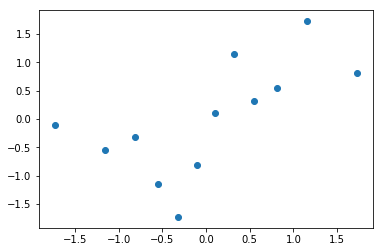

In [95]:
plt.scatter(x,y)
#plt.scatter(w,z)

In [89]:
functions

,gene,function
,,
c3623,iutA,Iron Acquisition
c4308,chuA,Iron Acquisition
c2482,hma,Iron Acquisition
c1250,iroN,Iron Acquisition
c0185,fhuA,Iron Acquisition
c3610,iha,Iron Acquisition
c5174,ireA,Iron Acquisition
c4186,feoB,Iron Acquisition
c3625,iucC,Iron Acquisition


In [125]:
l = [ c for c in orth_matrix.index if 'fim' in c]

In [128]:
orth_matrix.loc[l].HM14.dropna()

['76009_fimZ','26581_fimD_2', '8832_fimA_3', '26582_fimD_3']

76009_fimZ                      PROKKA_00365
26581_fimD_2                    PROKKA_01497
8832_fimA_3                     PROKKA_03860
13278_putative_fimbrial-li..    PROKKA_04752
25497_fimD_1                    PROKKA_00362
411_Type_1_fimbriae_Regu..      PROKKA_00133
26582_fimD_3                    PROKKA_01498
1875_Type-1_fimbrial_prot..     PROKKA_01501
24197_putative_fimbrial_ou..    PROKKA_04633
Name: HM14, dtype: object

In [59]:
df = (two_strain_correlation(("HM43", "HM14"), orth_matrix, norm_counts)
      .fillna(0)
      .merge(orth_matrix, left_index=True, right_index=True))

In [78]:
?plt.scatter

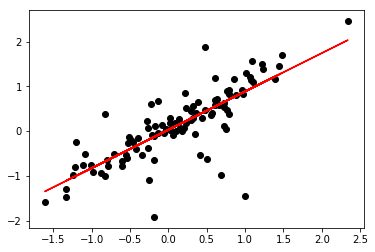

In [83]:
plt.scatter(df.HM43_UTI[0:100], df.HM14_UTI[0:100], color='black', )
plt.plot(data.HM43_UTI, test_result.predict(), color='red')

In [66]:
def get_residuals(x, y, data, pg = orth_matrix, rg = ref_genomes, th=2, gene_info=''):
    genome_abbr = {'UTI89':'eci', 'K-12':'eco', 'CFT073':'ecc', '536':'ecp', 'UMN026':'eum'}
    model = sm.OLS.from_formula("{} ~ {}".format(y, x), data=data)# ordinary least squares
    result = model.fit()
    print(result.params)
    residuals = result.resid
    threshold = result.resid.std()*th

    outliers = pd.DataFrame(result.resid[abs(result.resid)> threshold])
    out_df = pg.join(outliers,how='right').rename(columns={0:'Residual'})
    out_df = out_df.dropna(subset=rg, how='all')
    outliers_dict = out_df.T.to_dict()
    if not gene_info:
        gene_info = get_gene_info_from_dict(outliers_dict)
    elif gene_info == 'ignore':
        return out_df, result
    gene_info_df = pd.DataFrame(gene_info).T
    gene_info_df.columns = ["Gene Name", "Description"]
    out_df = out_df.merge(gene_info_df, left_index=True, right_index=True).sort_values(['Residual'])
    return out_df, result
#LB_outliers, LB_result  = get_residuals('HM43_LB', 'HM43_UTI', cnts, gene_info='ignore')

In [96]:
def plot_residuals(result,  th=2):   
    fig = plt.figure(figsize=(10,8))
    threshold = th*result.resid.std()
    plt.axhline(threshold, color='black', linewidth=0.5)
    plt.axhline(-threshold, color='black', linewidth=0.5)
    plt.scatter(result.predict(), result.resid, edgecolors='white', color='black', s=80)
    plt.ylabel("Residuals", fontsize=20)
    plt.xlabel("Predicted gene expression", fontsize=20)
    return fig

In [69]:
data = df[["HM43_UTI", "HM14_UTI"]].iloc[:100,]

In [71]:
test_out, test_result = get_residuals('HM43_UTI', 'HM14_UTI', data, gene_info='ignore')

Intercept    0.031116
HM43_UTI     0.856114
dtype: float64


(-1.5, 2.5)

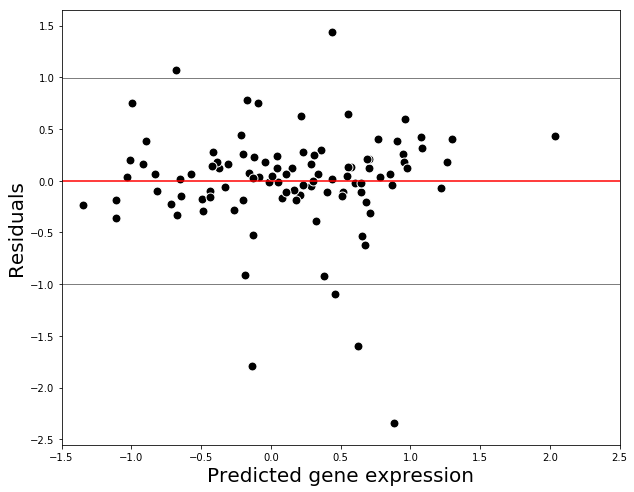

In [97]:
f = plot_residuals(test_result)
plt.plot((-10,30), (0,0), color='red')
plt.xlim(-1.5, 2.5)

array([ 0.04933841,  0.40078434, -0.21217887,  0.28819782, -0.08448091,
       -0.48774603,  0.70760344, -0.08907952,  0.07851458,  0.37840721,
       -0.41094567, -0.36929741,  0.65413458, -0.43876818,  0.76714216,
        0.68481207, -0.57130491, -1.10837331,  1.22117171, -0.12832197,
        2.03388008, -0.49048547,  0.2179866 ,  0.04751596,  0.6007172 ,
        0.88342702,  0.20634097,  0.22966691,  0.94467559,  0.16374591,
       -0.11906134, -1.01001038,  0.70573774, -1.10947885, -0.18667161,
        1.29764196, -0.04185542, -0.38665849,  1.0818505 ,  0.57706132,
       -0.91783556,  0.70201593, -0.71751422,  0.11049042, -0.81337923,
        0.95114132, -0.26194162,  0.55381514,  0.17759445, -0.13249528,
        0.33773547,  0.9015632 , -1.34801968,  0.28772133,  0.55052589,
       -0.68016706, -0.16837051, -0.9981821 ,  0.3039677 ,  0.62307941,
        1.26457918,  0.64939518,  0.51911202,  0.46331807,  0.96093951,
       -0.67183805, -1.03083319, -0.41981771,  1.07799158,  0.35

In [79]:
dir(test_result)

['HC0_se',
 'HC1_se',
 'HC2_se',
 'HC3_se',
 '_HCCM',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_cache',
 '_data_attr',
 '_get_robustcov_results',
 '_is_nested',
 '_wexog_singular_values',
 'aic',
 'bic',
 'bse',
 'centered_tss',
 'compare_f_test',
 'compare_lm_test',
 'compare_lr_test',
 'condition_number',
 'conf_int',
 'conf_int_el',
 'cov_HC0',
 'cov_HC1',
 'cov_HC2',
 'cov_HC3',
 'cov_kwds',
 'cov_params',
 'cov_type',
 'df_model',
 'df_resid',
 'eigenvals',
 'el_test',
 'ess',
 'f_pvalue',
 'f_test',
 'fittedvalues',
 'fvalue',
 'get_influence',
 'get_prediction',
 'get_robustcov_results',
 'initialize',
 'k_constant',
 'llf',
 'load',
 'model',
 'mse_mode

### Mouse RNA seq data analysis: exploratory

* Look at correlation between replicates/conditions
* PCA

In [2]:
def get_gene_info_from_dict(outliers_dict):
    gene_info = {}
    for key, val in outliers_dict.items():
        gene_info[key] = ('', '')
        for ref in reference_genomes:
        
            if val[ref] is np.nan:
                continue
            else:
                gene_id = '{}:{}'.format(genome_abbr[ref], val[ref])
                gene = Gene(gene_id)
                gene.kegg_get()
                _, gene_name, description = gene.get_short_info().split('\t')
                if gene_name or description:
                    gene_info[key] = (gene_name, description)
                    break
    return gene_info

In [3]:
# Set porper paths
raw_counts_dir = "/Users/annasintsova/git_repos/mouse_model/data/raw_count"
out_dir = "/Users/annasintsova/git_repos/mouse_model/results/"
gff = "/Users/annasintsova/git_repos/HUTI-RNAseq/data/annotations/gff_files/HM43.gff"

fig_dir = "/Users/annasintsova/git_repos/mouse_model/figures"
cols = ["#0084ff", "#44bec7", "#ffc300", "#fa3c4c", "#d696bb"]
pangenome_path = "/Users/annasintsova/git_repos/mouse_model/results/find_pangenome/pangenome.csv"
pangenome_OMCL_path = "/Users/annasintsova/git_repos/mouse_model/results/find_pangenome/pangenome_OMCL.csv"
reference_genomes = ['K-12', 'CFT073', 'UTI89', 'UMN026', '536']

In [ ]:

#crp_path = "/Users/annasintsova/git_repos/HUTI-RNAseq/shared_data/crp_genes.csv"
#ribo_path = "/Users/annasintsova/git_repos/HUTI-RNAseq/shared_data/ribo_genes.csv"

In [6]:
# Convert raw counts to TPMs
# raw_counts_dir has count data for one strain (ex. HM43)


Text(0.2,0.75,'r = 0.82')

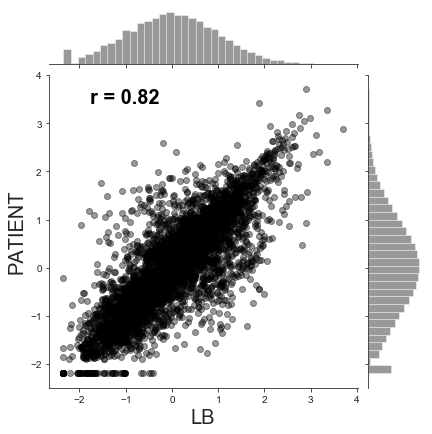

In [13]:
s = sns.jointplot( x = "HM43_LB", y ="HM43_UTI", data=cnts, color = 'black', alpha=0.4, height=6)
s.set_axis_labels("LB", "PATIENT", fontsize=20)
s.fig.text(0.2, 0.75, "r = 0.82", horizontalalignment='left', fontsize=20, color='black', weight='semibold')
#s.savefig(Path(fig_dir).joinpath("LB_vs_UTI.png"), dpi=150, bbox_inches="tight")

In [14]:
def get_residuals(x, y, data, pg = panHM43_OMCL, rg = reference_genomes, th=2, gene_info=''):
    genome_abbr = {'UTI89':'eci', 'K-12':'eco', 'CFT073':'ecc', '536':'ecp', 'UMN026':'eum'}
    model = sm.OLS.from_formula("{} ~ {}".format(y, x), data=data)# ordinary least squares
    result = model.fit()
    print(result.params)
    residuals = result.resid
    threshold = result.resid.std()*th

    outliers = pd.DataFrame(result.resid[abs(result.resid)> threshold])
    out_df = pg.join(outliers,how='right').rename(columns={0:'Residual'})
    out_df = out_df.dropna(subset=rg, how='all')
    outliers_dict = out_df.T.to_dict()
    if not gene_info:
        gene_info = get_gene_info_from_dict(outliers_dict)
    elif gene_info == 'ignore':
        return out_df, result
    gene_info_df = pd.DataFrame(gene_info).T
    gene_info_df.columns = ["Gene Name", "Description"]
    out_df = out_df.merge(gene_info_df, left_index=True, right_index=True).sort_values(['Residual'])
    return out_df, result
LB_outliers, LB_result  = get_residuals('HM43_LB', 'HM43_UTI', cnts, gene_info='ignore')

Intercept    0.001358
HM43_LB      0.816882
dtype: float64


(-3.5, 3.5)

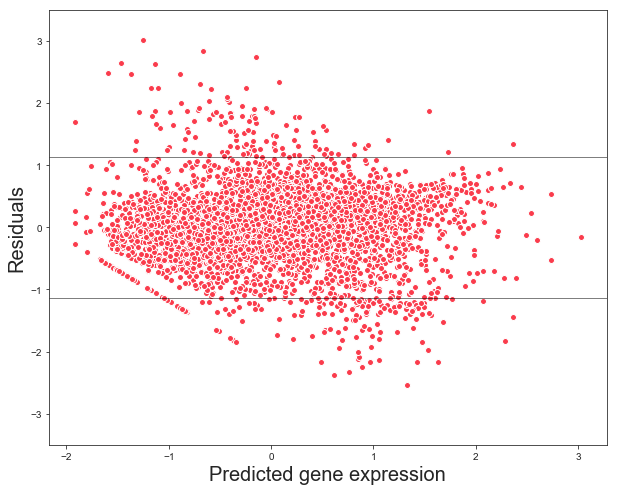

In [15]:
def plot_residuals(result,  th=2):   
    fig = plt.figure(figsize=(10,8))
    threshold = th*result.resid.std()
    plt.axhline(threshold, color='black', linewidth=0.5)
    plt.axhline(-threshold, color='black', linewidth=0.5)
    plt.scatter(result.predict(), result.resid, color=cols[3], edgecolors='white')
    plt.ylabel("Residuals", fontsize=20)
    plt.xlabel("Predicted gene expression", fontsize=20)
    return fig

g = plot_residuals(LB_result)
plt.ylim(-3.5,3.5)
#g.savefig(Path(fig_dir).joinpath("LB_residuals.png"), dpi=150, bbox_inches="tight")

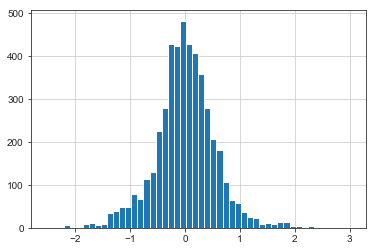

In [16]:
LB_result.resid.hist(bins=50)

In [260]:
###
out_df.to_csv(Path(out_dir)/"LB_outliers.csv")

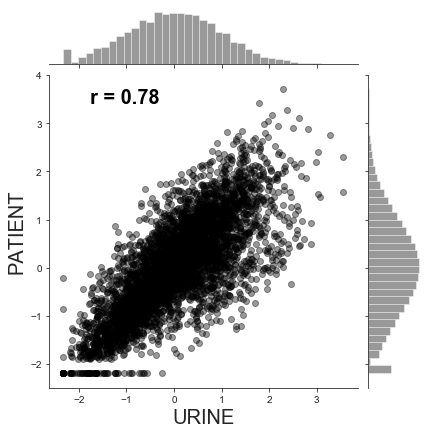

In [67]:
s = sns.jointplot( x = "HM43_UR", y ="HM43_UTI", data=cnts, color = 'black', alpha=0.4, height=6)
s.set_axis_labels("URINE", "PATIENT", fontsize=20)
s.fig.text(0.2, 0.75, "r = 0.78", horizontalalignment='left', fontsize=20, color='black', weight='semibold')
s.savefig(Path(fig_dir).joinpath("UR_vs_UTI.png"), dpi=150, bbox_inches="tight")

In [17]:
urine_outliers, urine_result = get_residuals('HM43_UR', 'HM43_UTI', cnts, th=2, gene_info='ignore')

Intercept    0.001324
HM43_UR      0.782720
dtype: float64


In [285]:
###
urine_outliers.to_csv(Path(out_dir)/"UR_outliers.csv")

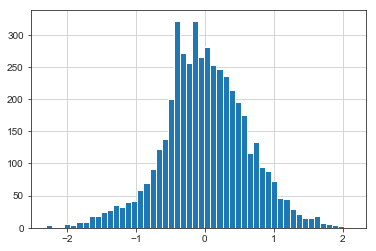

In [25]:
urine_result.resid.hist(bins=50)

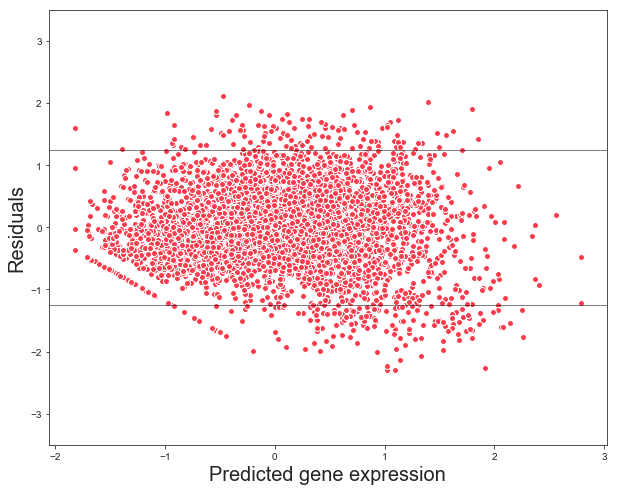

In [27]:
g = plot_residuals(urine_result)
plt.ylim(-3.5,3.5)
g.savefig(Path(fig_dir).joinpath("Urine_residuals.png"), dpi=150, bbox_inches="tight")

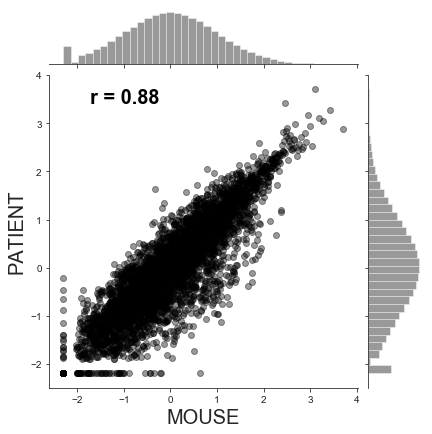

In [68]:
s = sns.jointplot( x = "HM43_mouse", y ="HM43_UTI", data=cnts, color = 'black', alpha=0.4, height=6)
s.set_axis_labels("MOUSE", "PATIENT", fontsize=20)
s.fig.text(0.2, 0.75, "r = 0.88", horizontalalignment='left', fontsize=20, color='black', weight='semibold')
s.savefig(Path(fig_dir).joinpath("Mouse_vs_UTI.png"), dpi=150, bbox_inches="tight")

In [18]:
mouse_outliers, mouse_result = get_residuals('HM43_mouse', 'HM43_UTI', cnts, th=2, gene_info='ignore')

Intercept     0.001007
HM43_mouse    0.876096
dtype: float64


In [291]:
###
mouse_outliers.to_csv(Path(out_dir)/'Mouse_outliers.csv')


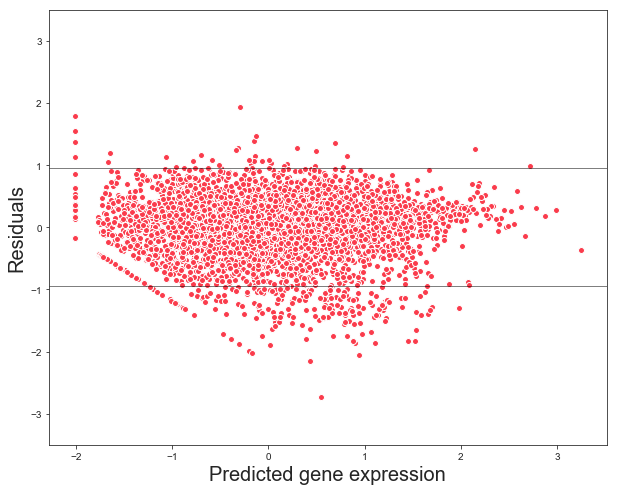

In [31]:
g = plot_residuals(mouse_result)
plt.ylim(-3.5,3.5)
g.savefig(Path(fig_dir).joinpath("Mouse_residuals.png"), dpi=150, bbox_inches="tight")

In [39]:
logTPM = np.log2(tpm_df +1)
logTPM['HM43_LB'] = logTPM[["HM43_LB_rep1", "HM43_LB_rep2"]].mean(axis=1)
logTPM['HM43_UR'] = logTPM[["HM43_UR_rep1", "HM43_UR_rep2"]].mean(axis=1)
logTPM = logTPM[["HM43_LB", "HM43_UR", "HM43_mouse", "HM43_UTI"]]
logTPM.corr().round(2)

,HM43_LB,HM43_UR,HM43_mouse,HM43_UTI
HM43_LB,1.00,0.85,0.78,0.81
HM43_UR,0.85,1.00,0.75,0.76
HM43_mouse,0.78,0.75,1.00,0.87
HM43_UTI,0.81,0.76,0.87,1.00


<Figure size 1440x1440 with 0 Axes>

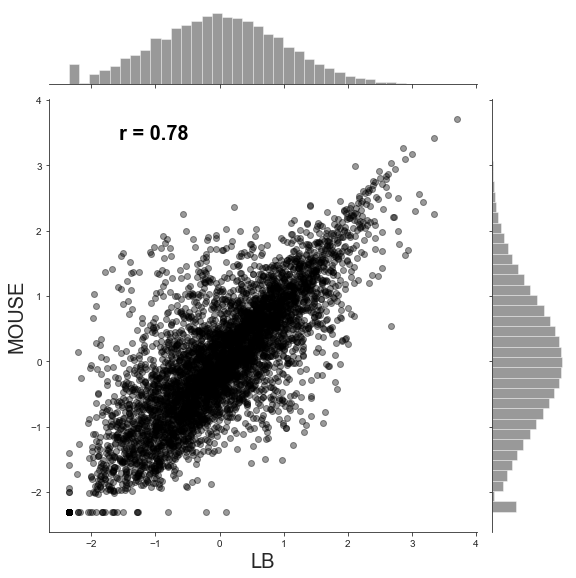

In [54]:
### Don't really need this


plt.figure(figsize=(20,20))

s = sns.jointplot( x = "HM43_LB", y ="HM43_mouse", data=cnts, color = 'black', alpha=0.4, height=8)
s.set_axis_labels("LB", "MOUSE", fontsize=20)
s.fig.text(0.2, 0.75, "r = 0.78", horizontalalignment='left', fontsize=20, color='black', weight='semibold')
s.savefig(Path(fig_dir).joinpath("LB_vs_MOUSE.png"), dpi=150, bbox_inches="tight")

In [20]:
def find_pc1_pc2(df, meta):
    df = df.T
    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(df)
    pDf = (pd.DataFrame(data=principalComponents, columns=['PC1', 'PC2'])
           .set_index(df.index))
    pc1_var = round(pca.explained_variance_ratio_[0] * 100, 2)
    pc2_var = round(pca.explained_variance_ratio_[1] * 100, 2)
    pDf2 = pDf.merge(meta, left_index=True, right_index=True)
    return pDf2, pc1_var, pc2_var


def plotPCA(pDf, pc1_var, pc2_var, colorby, col, nameby="", el=False): 
    sns.set_style("ticks")
    sns.set_context("notebook", font_scale=2.2)
    group = pDf[colorby].unique()
    assert len(group) <= len(col)
    fig = plt.figure(figsize=(8, 8))
    for g, c in zip(group, col):
        df = pDf[pDf[colorby] == g]
        x, y = df[["PC1"]].values, df[["PC2"]].values
        ax = plt.scatter(x, y, c=c, s=150, label=g)  
        if el:
            pts = np.asarray([[float(a), float(b)] for a, b in zip(x, y)])
            plot_point_cov(pts, nstd=2, alpha=0.1, color=c)
        if nameby:
            labels = df[nameby]
            for label, pc1, pc2 in zip(labels, x, y):
                plt.annotate(label, xy=(pc1, pc2), xytext=(-5, 7), textcoords="offset points",fontsize=14)
        plt.xlabel('Principal Component 1, {} %'.format(pc1_var), )
        plt.ylabel('Principal Component 2, {} %'.format(pc2_var), )
        #plt.xticks(fontsize=16)
        #plt.yticks(fontsize=16)
        plt.legend(fontsize=16, frameon=True)
    return fig

In [50]:
norm_cnts.head()

,HM43_LB_rep2,HM43_UR_rep1,HM43_UTI,HM43_UR_rep2,HM43_LB_rep1,HM43_mouse,HM43_LB,HM43_UR
PROKKA_00001,-2.339366,-2.360402,-2.188182,-2.30016,-2.364737,-2.30016,-2.352052,-2.330281
PROKKA_00002,-2.339366,-2.360402,-2.188182,-2.30016,-2.364737,-2.30016,-2.352052,-2.330281
PROKKA_00003,-2.339366,-2.360402,-2.188182,-2.30016,-2.364737,-2.30016,-2.352052,-2.330281
PROKKA_00004,-2.339366,-2.360402,-2.188182,-2.30016,-2.364737,-2.30016,-2.352052,-2.330281
PROKKA_00005,-2.339366,-2.360402,-2.188182,-2.30016,-2.364737,-2.30016,-2.352052,-2.330281


In [21]:
strain_info = pd.DataFrame([c.split("_")[1] for c in norm_cnts.columns], index = norm_cnts.columns, columns=["condition"])

In [22]:
strain_info

,condition
HM43_LB_rep2,LB
HM43_UR_rep1,UR
HM43_UTI,UTI
HM43_UR_rep2,UR
HM43_LB_rep1,LB
HM43_mouse,mouse
HM43_LB,LB
HM43_UR,UR


In [23]:
pDf, pc1, pc2 = find_pc1_pc2(norm_cnts, strain_info)

In [24]:
pc2

38.130000000000003

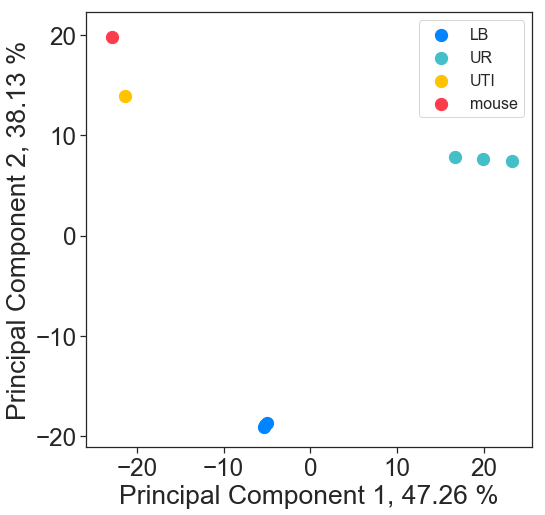

In [25]:
f = plotPCA(pDf, pc1, pc2, "condition", col=cols, nameby="", el=False)
f.savefig(Path(fig_dir).joinpath("PCA.png"), dpi=150, bbox_inches="tight")

In [57]:
os.listdir(raw_counts_dir)

['.DS_Store',
 'HM43_LB_rep2_trimmed_sorted_yes_counts.txt',
 'HM43_UR_rep1_trimmed_sorted_yes_counts.txt',
 'HM43_UTI_trimmed_sorted_yes_counts.txt',
 'HM43_UR_rep2_trimmed_sorted_yes_counts.txt',
 'HM43_LB_rep1_trimmed_sorted_yes_counts.txt',
 'HM43_mouse_trimmed_sorted_yes_counts.txt']

In [6]:
raw_counts = {}
for f in os.listdir(raw_counts_dir):
    if f.endswith('txt'):
        raw_counts[f.split('_trimmed')[0]] = process_counts.process_count_file(os.path.join(raw_counts_dir,f))
        
cnts = pd.DataFrame(raw_counts)
cnts.to_csv("/Users/annasintsova/git_repos/HUTI-RNAseq/shared_data/mouse_lb_raw_counts.csv")

In [63]:
hm43_core = pd.merge(cnts, HM43_ortho, left_index=True, right_on="HM43").iloc[:,:-1]

In [57]:
# Functional Catergories

In [24]:
orth_matrix = pd.read_csv(pangenome_file, index_col=0)
print(orth_matrix.shape) # 15420, 20
tpms = process_counts.normalize_counts_to_tpm(raw_counts_dir, gff_dir, results_dir)
counts = pd.DataFrame(tpms)
pcounts = counts[[c for c in counts.columns if "UTI" in c and 'seq' not in c]]
urine_counts = counts[[c for c in counts.columns if 'UR' in c and 'seq' not in c]]
uncnts = urine_counts.apply(ut.invnorm)
norm_counts = pcounts.apply(ut.invnorm)

(15420, 20)


/anaconda/envs/biology/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1904: RuntimeWarning: invalid value encountered in greater
  cond1 = (0 < q) & (q < 1)
/anaconda/envs/biology/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1904: RuntimeWarning: invalid value encountered in less
  cond1 = (0 < q) & (q < 1)


In [25]:
norm_counts2 = np.log2(pcounts+1)
unorm_counts2 = np.log2(urine_counts+1)

In [26]:
fgroups = pd.read_csv(functional_groups_file, index_col=0)
to_keep = ['Functional Group', "Description", "CFT073", "UTI89", "536"]
fgroups = fgroups[to_keep]
strains = "HM01 HM03 HM06 HM07 HM14 HM17 HM43 HM54 HM56 HM57 HM60 HM68 HM86".split()

def get_category_genes(fgroup, panmatrix, refs, strains=strains):
    subsets = []
    for ref in refs:
        if ref in fgroup.columns:
            ref_df = fgroup.dropna(subset=[ref]).reset_index()
            
            ref_df = ref_df.merge(panmatrix[strains+[ref]], how='left', left_on = ref, right_on=ref)
            subsets.append(ref_df)            
    fdf = pd.concat(subsets, sort=False).drop_duplicates().set_index('index')
    return fdf


def get_all_functional_groups(fgroups, panmatrix, refs=['CFT073', 'UTI89'], function='Functional Group', description='Description' ):
    gene_sets = {}
    for i, g in fgroups.groupby(function):
        fdf  = get_category_genes(g, panmatrix, refs ) 
        gene_sets[i] = fdf
    return gene_sets
    
    
    
gene_sets = get_all_functional_groups(fgroups, orth_matrix)    

In [32]:
fgroups

,Functional Group,Description,CFT073,UTI89,536
FepA,Iron Acquisition,Other,c0669,UTI89_C0584,ECP_RS03065
Iha,Iron Acquisition,Other,c3610,NaN,NaN
IreA,Iron Acquisition,Other,c5174,NaN,NaN
Fiu,Iron Acquisition,Other,c0890,NaN,ECP_RS04120
CirA,Iron Acquisition,Enterobactin,c2690,UTI89_C2429,NaN
fes,Iron Acquisition,Enterobactin,c0671,UTI89_C0586,NaN
entS,Iron Acquisition,Enterobactin,c0678,UTI89_C0593,NaN
entA,Iron Acquisition,Enterobactin,NaN,UTI89_C0598,NaN
entB,Iron Acquisition,Enterobactin,c0682,UTI89_C0597,NaN
entC,Iron Acquisition,Enterobactin,c0680,UTI89_C0595,NaN


In [60]:
categories = (pd.read_csv("/Users/annasintsova/git_repos/mouse_model/data/functional_categories.csv")
              .drop(['Unnamed: 7', 'Unnamed: 8'], axis=1))

In [63]:
categories.at[35, 'CFT073'] = 'c1646'

In [114]:
def category_correlation(data, categories_table, pangenome, refs=reference_genomes ):
    subsets = []
   
    for ref in refs:
        if ref in categories_table.columns:
            names = list(categories_table[ref].dropna().index)
         
            lgenes = categories_table[ref].dropna().values
         
            df = pangenome[pangenome[ref].isin(lgenes)]
            subsets.append(df)
    fdf = pd.concat(subsets)
    t4 = data.loc[fdf.index]
    return fdf.merge(t4, left_index=True, right_index=True).drop_duplicates()

In [128]:
df.head()

,K-12,CFT073,UTI89,UMN026,536,HM43_LB,HM43_UR,HM43_mouse,HM43_UTI
PROKKA_00296,b1252,c1717,UTI89_C1451,ECUMN_1551,ECP_RS06605,6.585071,6.552500,7.627728,8.579484
PROKKA_00440,b1102,c1374,UTI89_C1229,ECUMN_1280,ECP_RS05560,2.760573,6.816064,6.512507,8.134790
PROKKA_00725,b0805,c0890,UTI89_C0808,ECUMN_0949,ECP_RS04120,2.693211,3.285989,4.983867,9.234258
PROKKA_00942,b0596,c0683,UTI89_C0598,ECUMN_0690,ECP_RS03130,4.459110,7.357662,8.712676,8.935180
PROKKA_00943,b0595,c0682,UTI89_C0597,ECUMN_0689,ECP_RS03125,4.304337,6.828344,8.559863,9.150425


           HM43_LB  HM43_UTI
HM43_LB   1.000000  0.356129
HM43_UTI  0.356129  1.000000
           HM43_UR  HM43_UTI
HM43_UR   1.000000  0.702606
HM43_UTI  0.702606  1.000000
            HM43_mouse  HM43_UTI
HM43_mouse    1.000000  0.570965
HM43_UTI      0.570965  1.000000


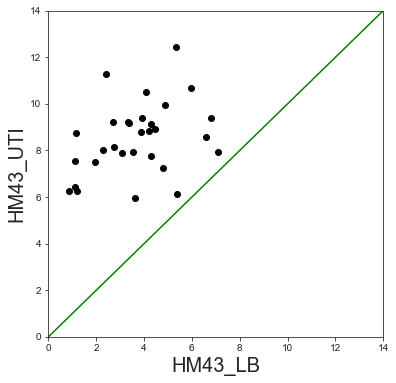

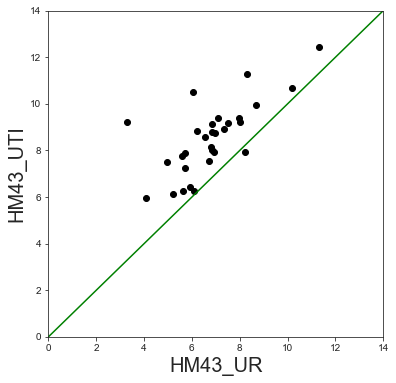

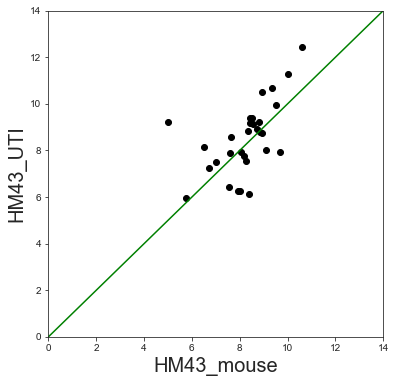

In [134]:
conditions = [("HM43_LB", "HM43_UTI"), ("HM43_UR", "HM43_UTI"), ("HM43_mouse", "HM43_UTI")]

df= category_correlation(logTPM, iron_df, panHM43_OMCL, reference_genomes)
for t in conditions:
    fig = plt.figure(figsize=(6,6))
    plt.scatter( x = t[0], y =t[1], data=df, color = 'black');
    plt.xlabel(t[0], fontsize=20)
    plt.ylabel(t[1],fontsize=20)
    plt.plot([0, 14], [0, 14], 'g-')
    plt.xlim(0, 14)
    plt.ylim(0, 14)
    print(df[[t[0], t[1]]].corr())


In [137]:
fgroups

,Functional Group,Description,CFT073,UTI89,536
FepA,Iron Acquisition,Other,c0669,UTI89_C0584,ECP_RS03065
Iha,Iron Acquisition,Other,c3610,NaN,NaN
IreA,Iron Acquisition,Other,c5174,NaN,NaN
Fiu,Iron Acquisition,Other,c0890,NaN,ECP_RS04120
CirA,Iron Acquisition,Enterobactin,c2690,UTI89_C2429,NaN
fes,Iron Acquisition,Enterobactin,c0671,UTI89_C0586,NaN
entS,Iron Acquisition,Enterobactin,c0678,UTI89_C0593,NaN
entA,Iron Acquisition,Enterobactin,NaN,UTI89_C0598,NaN
entB,Iron Acquisition,Enterobactin,c0682,UTI89_C0597,NaN
entC,Iron Acquisition,Enterobactin,c0680,UTI89_C0595,NaN


           HM43_LB  HM43_UTI
HM43_LB   1.000000  0.926813
HM43_UTI  0.926813  1.000000
           HM43_UR  HM43_UTI
HM43_UR   1.000000  0.863098
HM43_UTI  0.863098  1.000000
            HM43_mouse  HM43_UTI
HM43_mouse    1.000000  0.948576
HM43_UTI      0.948576  1.000000


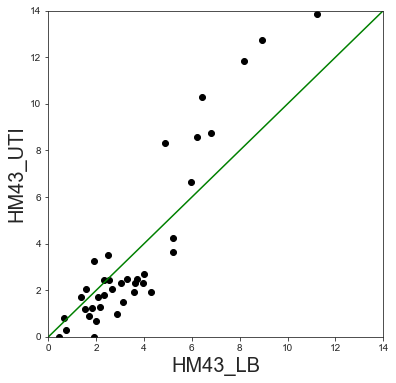

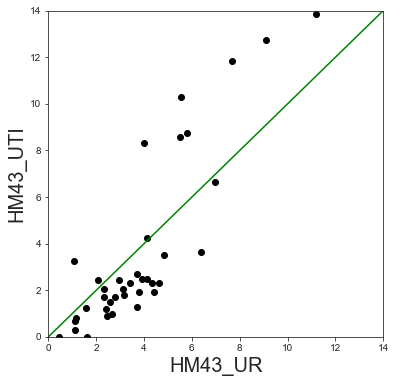

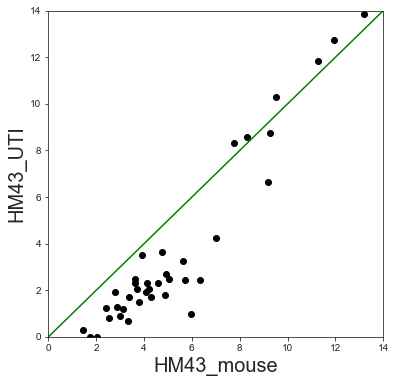

In [135]:
df= category_correlation(logTPM, gene_sets['adherence'], panHM43_OMCL, reference_genomes)
for t in conditions:
    fig = plt.figure(figsize=(6,6))
    plt.scatter( x = t[0], y =t[1], data=df, color = 'black');
    plt.xlabel(t[0], fontsize=20)
    plt.ylabel(t[1],fontsize=20)
    plt.plot([0, 14], [0, 14], 'g-')
    plt.xlim(0, 14)
    plt.ylim(0, 14)
    print(df[[t[0], t[1]]].corr())

In [138]:
gsets2 = get_all_functional_groups(fgroups,orth_matrix, function='Description', description='Description' )


In [149]:
for g in gsets2.keys():
    print(g)

ABC
ABC-2 type
Aerobactin
Arabinose
Capsular polysaccharide
Cationic peptide
Cell division
D-allose
D-xylose
Dipeptide
Enterobactin 
Entner-Doudoroff
Escherichia coli K-12 B0879 pseudogene
F1C fimbriae
Feo iron transporter
Fhu Operon
Gluconeogenesis
Glutathione
Glycolysis
Heme
Lipopolysaccharide
Lipoprotein
Macrolide-specific efflux protein macA precursor
Microcin C
Molybdate
Multidrug efflux channel
Nickel
Oligopeptide
Osmoprotectant
Other
Pentose phosphate pathway
Peptides/nickel
Potassium efflux system kefA
Probable aminoglycoside efflux pump
Proline
Putative
Putative RTX family exoprotein A gene
Putative polyketide synthase
Putrescine
Salmochelin 
Sit Operon
Spermidine
Sulfate
TCA cycle
Thiamin
Yersinabactin
alkanesulfonate
alpha-glucoside
arabinogalactan
arginine
auf
autotransporter serine protease toxin
branched chain
copper eflfux
curli biogenesis
cystine
cytotoxic necrotizing factor 1
enery-coupling
fim
flagella machinery
general L-amino acid
glutamate/aspartate
glutamine
glyce

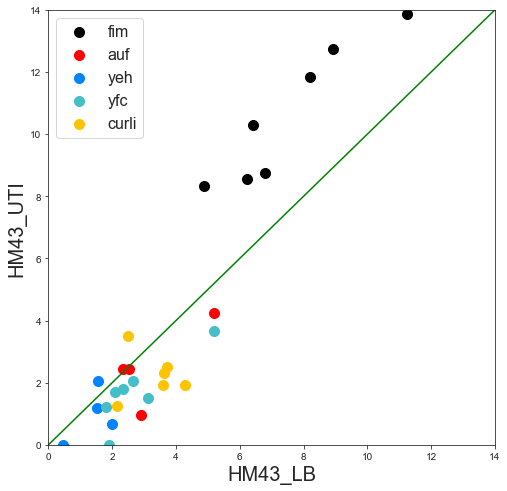

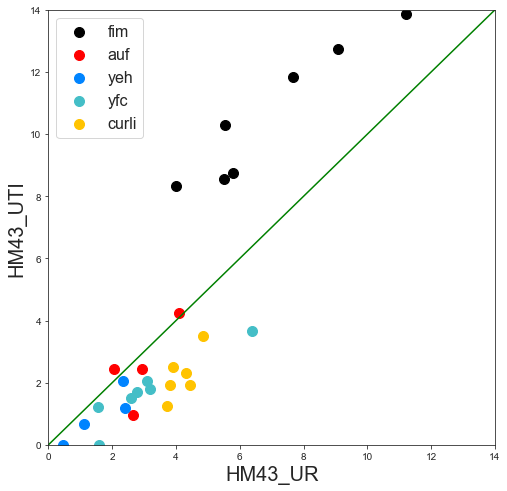

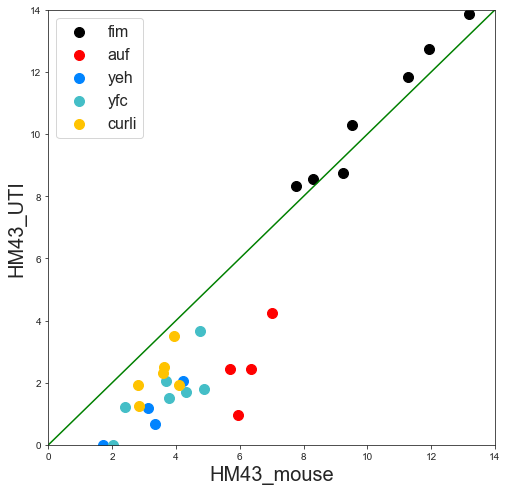

In [164]:
df1= category_correlation(logTPM, gsets2['fim'], panHM43_OMCL, reference_genomes)
df2 = category_correlation(logTPM, gsets2['auf'], panHM43_OMCL, reference_genomes)
df3 = category_correlation(logTPM, gsets2['yeh'], panHM43_OMCL, reference_genomes)
df4 = category_correlation(logTPM, gsets2['yfc'], panHM43_OMCL, reference_genomes)
df5 = category_correlation(logTPM, gsets2['curli biogenesis'], panHM43_OMCL, reference_genomes)

for t in conditions:
    fig = plt.figure(figsize=(8,8))
    plt.scatter( x = t[0], y =t[1], data=df1, color = 'black', label='fim', s=100);
    plt.scatter( x = t[0], y =t[1], data=df2, color = 'red', label='auf', s=100);
    plt.scatter( x = t[0], y =t[1], data=df3, color = ut.cols[0], label='yeh', s=100);
    plt.scatter( x = t[0], y =t[1], data=df4, color = ut.cols[1], label='yfc', s=100);
    plt.scatter( x = t[0], y =t[1], data=df5, color = ut.cols[2], label='curli', s=100);
    plt.xlabel(t[0], fontsize=20)
    plt.ylabel(t[1],fontsize=20)
    plt.plot([0, 14], [0, 14], 'g-')
    plt.xlim(0, 14)
    plt.ylim(0, 14)
    plt.legend(fontsize=16)


In [158]:
ad_df = category_correlation(logTPM, gene_sets['adherence'], panHM43_OMCL, reference_genomes)
ad_df.corr()

,HM43_LB,HM43_UR,HM43_mouse,HM43_UTI
HM43_LB,1.000000,0.943550,0.908869,0.926813
HM43_UR,0.943550,1.000000,0.827974,0.863098
HM43_mouse,0.908869,0.827974,1.000000,0.948576
HM43_UTI,0.926813,0.863098,0.948576,1.000000


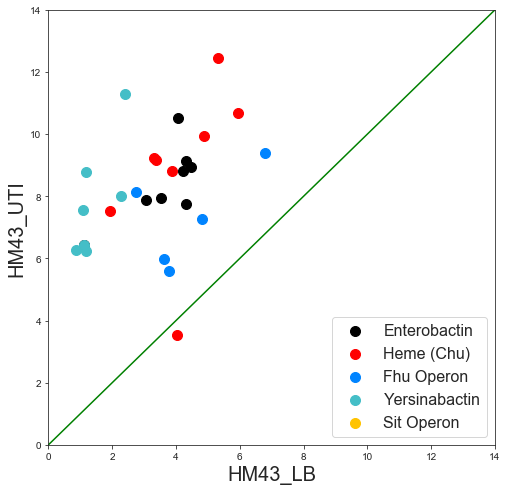

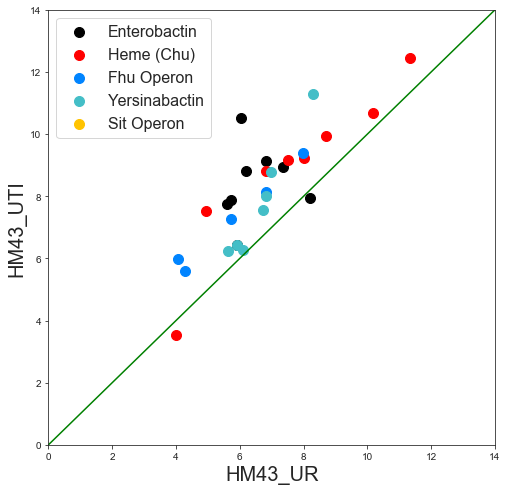

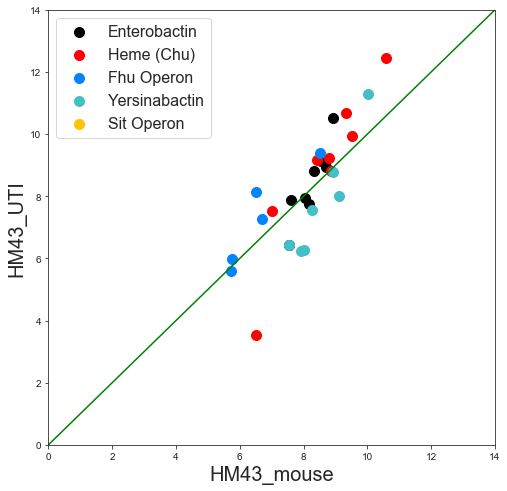

In [168]:
df1= category_correlation(logTPM, gsets2['Enterobactin '], panHM43_OMCL, reference_genomes)
df2 = category_correlation(logTPM, gsets2['Heme'], panHM43_OMCL, reference_genomes)
df3 = category_correlation(logTPM, gsets2['Fhu Operon'], panHM43_OMCL, reference_genomes)
df4 = category_correlation(logTPM, gsets2['Yersinabactin'], panHM43_OMCL, reference_genomes)
df5 = category_correlation(logTPM, gsets2['Sit Operon'], panHM43_OMCL, reference_genomes)
for t in conditions:
    fig = plt.figure(figsize=(8,8))
    plt.scatter( x = t[0], y =t[1], data=df1, color = 'black', label='Enterobactin', s=100);
    plt.scatter( x = t[0], y =t[1], data=df2, color = 'red', label='Heme (Chu)', s=100);
    plt.scatter( x = t[0], y =t[1], data=df3, color = ut.cols[0], label='Fhu Operon', s=100);
    plt.scatter( x = t[0], y =t[1], data=df4, color = ut.cols[1], label='Yersinabactin', s=100);
    plt.scatter( x = t[0], y =t[1], data=df5, color = ut.cols[2], label='Sit Operon', s=100);
    plt.xlabel(t[0], fontsize=20)
    plt.ylabel(t[1],fontsize=20)
    plt.plot([0, 14], [0, 14], 'g-')
    plt.xlim(0, 14)
    plt.ylim(0, 14)
    plt.legend(fontsize=16)


In [174]:
df1.head()

,K-12,CFT073,UTI89,UMN026,536,HM43_LB,HM43_UR,HM43_mouse,HM43_UTI
PROKKA_00193,b1276,c1745,UTI89_C1547,ECUMN_1578,ECP_RS06755,7.790386,8.216000,6.164080,4.237870
PROKKA_00401,b1136,c1517,UTI89_C1266,ECUMN_1380,ECP_RS05735,10.846738,10.964665,8.966247,9.883975
PROKKA_00805,b0729,c0806,UTI89_C0724,ECUMN_0806,ECP_RS03720,12.125673,9.718559,8.426139,8.188124
PROKKA_00806,b0728,c0805,UTI89_C0723,ECUMN_0805,ECP_RS03715,11.764387,9.428394,8.163436,7.333012
PROKKA_00807,b0727,c0804,UTI89_C0722,ECUMN_0804,ECP_RS03710,12.311693,9.627879,8.712709,8.464179


In [173]:
df2

,K-12,CFT073,UTI89,UMN026,536,HM43_LB,HM43_UR,HM43_mouse,HM43_UTI
PROKKA_00765,b0767,c0844,UTI89_C0765,ECUMN_0852,ECP_RS03920,8.313366,8.033480,6.314339,6.156794
PROKKA_00844,b0688,c0775,UTI89_C0693,ECUMN_0774,ECP_RS03565,8.537279,7.593080,7.762818,7.115060
PROKKA_02691,b3437,c4225,UTI89_C3945,ECUMN_3900,ECP_RS18005,3.966739,4.399758,6.485848,7.545555
PROKKA_04426,b1852,c2265,UTI89_C2055,ECUMN_2149,ECP_RS09210,7.481297,7.925071,7.985534,7.408851
PROKKA_04427,b1851,c2264,UTI89_C2054,ECUMN_2148,ECP_RS09205,5.840539,5.075951,7.023403,7.419561
PROKKA_04428,b1850,c2263,UTI89_C2053,ECUMN_2147,ECP_RS09200,6.666621,5.815018,7.185082,7.105433
PROKKA_04526,b1761,c2162,UTI89_C1957,ECUMN_2049,ECP_RS08710,5.507640,6.466042,6.827744,6.728315


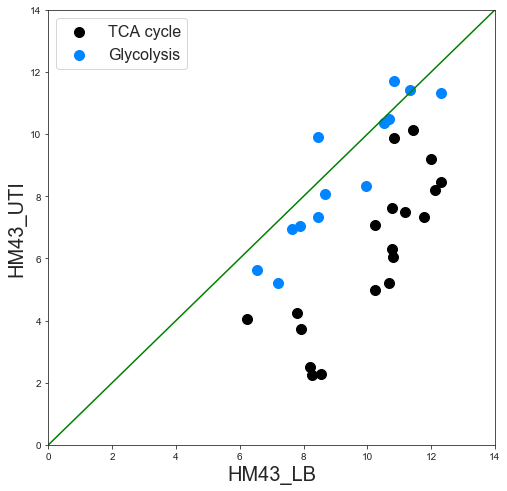

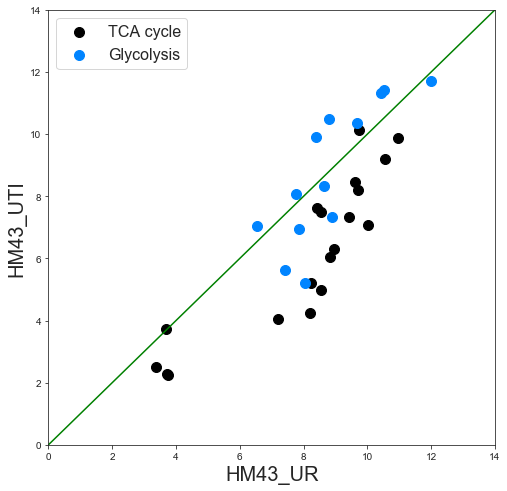

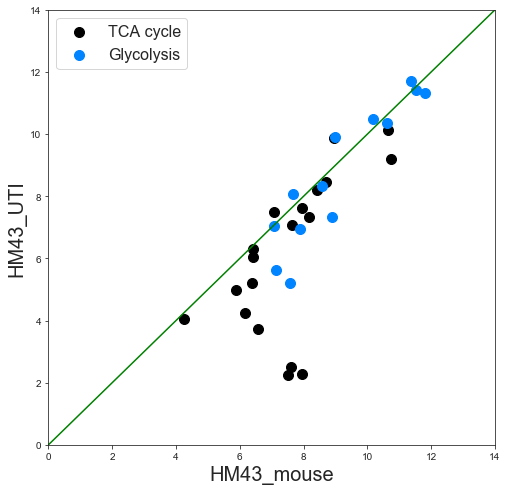

In [184]:
df1= category_correlation(logTPM, gsets2['TCA cycle'], panHM43_OMCL, reference_genomes)
#df2 = category_correlation(logTPM, gsets2['Entner-Doudoroff'], panHM43_OMCL, reference_genomes)
df3 = category_correlation(logTPM, gsets2['Glycolysis'], panHM43_OMCL, reference_genomes)
#df4 = category_correlation(logTPM, gsets2['Pentose phosphate pathway'], panHM43_OMCL, reference_genomes)
for t in conditions:
    fig = plt.figure(figsize=(8,8))
    plt.scatter( x = t[0], y =t[1], data=df1, color = 'black', label='TCA cycle', s=100);
   # plt.scatter( x = t[0], y =t[1], data=df2, color = 'red', label='Entner-Doudoroff', s=100);
    plt.scatter( x = t[0], y =t[1], data=df3, color = ut.cols[0], label='Glycolysis', s=100);
    #plt.scatter( x = t[0], y =t[1], data=df4, color = ut.cols[2], label='Pentose Phosphate', s=100);
    plt.xlabel(t[0], fontsize=20)
    plt.ylabel(t[1],fontsize=20)
    plt.plot([0, 14], [0, 14], 'g-')
    plt.xlim(0, 14)
    plt.ylim(0, 14)
    plt.legend(fontsize=16)

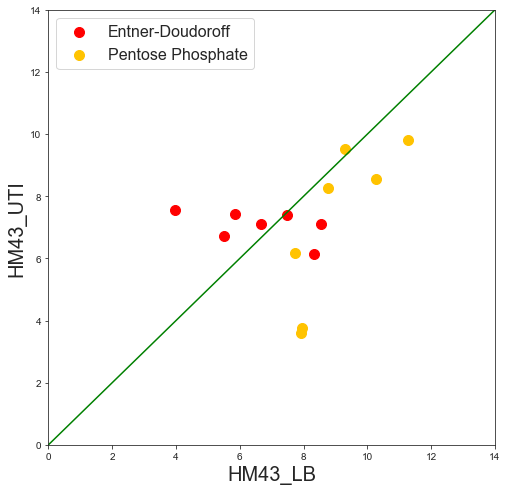

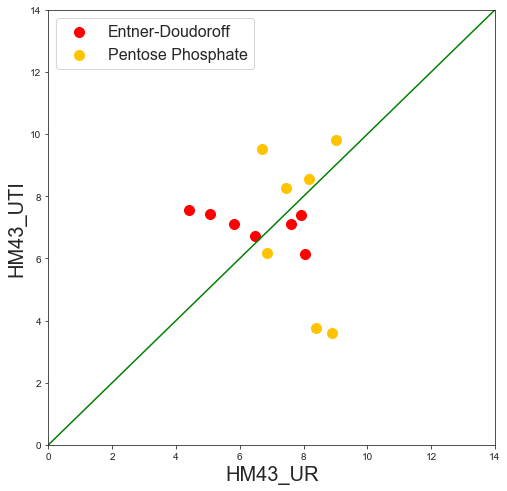

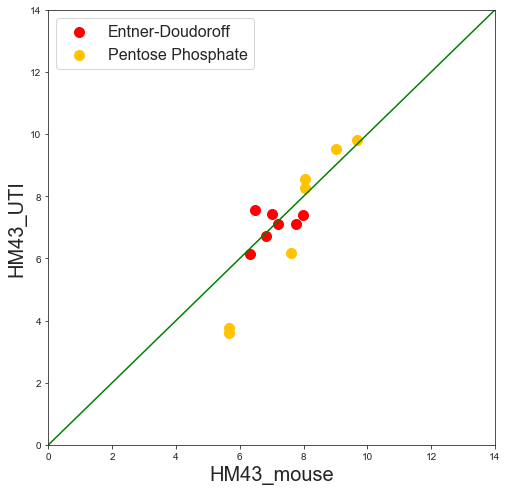

In [185]:
#df1= category_correlation(logTPM, gsets2['TCA cycle'], panHM43_OMCL, reference_genomes)
df2 = category_correlation(logTPM, gsets2['Entner-Doudoroff'], panHM43_OMCL, reference_genomes)
#df3 = category_correlation(logTPM, gsets2['Glycolysis'], panHM43_OMCL, reference_genomes)
df4 = category_correlation(logTPM, gsets2['Pentose phosphate pathway'], panHM43_OMCL, reference_genomes)
for t in conditions:
    fig = plt.figure(figsize=(8,8))
    #plt.scatter( x = t[0], y =t[1], data=df1, color = 'black', label='TCA cycle', s=100);
    plt.scatter( x = t[0], y =t[1], data=df2, color = 'red', label='Entner-Doudoroff', s=100);
    #plt.scatter( x = t[0], y =t[1], data=df3, color = ut.cols[0], label='Glycolysis', s=100);
    plt.scatter( x = t[0], y =t[1], data=df4, color = ut.cols[2], label='Pentose Phosphate', s=100);
    plt.xlabel(t[0], fontsize=20)
    plt.ylabel(t[1],fontsize=20)
    plt.plot([0, 14], [0, 14], 'g-')
    plt.xlim(0, 14)
    plt.ylim(0, 14)
    plt.legend(fontsize=16)

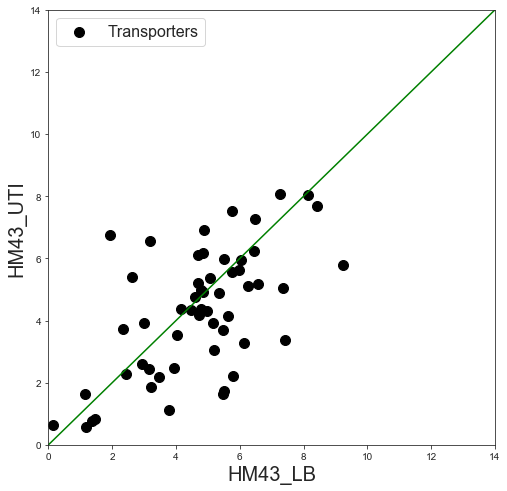

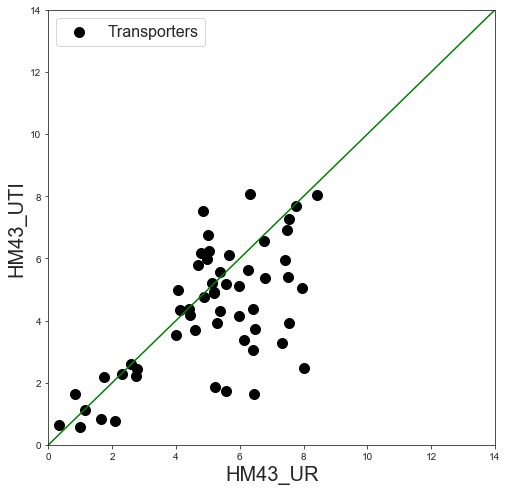

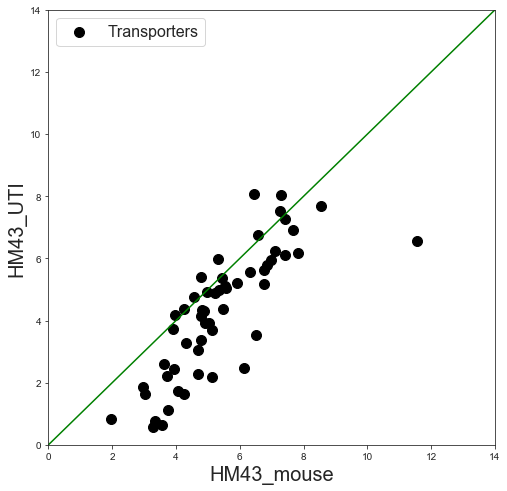

In [186]:
df1= category_correlation(logTPM, gene_sets['transporter'], panHM43_OMCL, reference_genomes)

for t in conditions:
    fig = plt.figure(figsize=(8,8))
    plt.scatter( x = t[0], y =t[1], data=df1, color = 'black', label='Transporters', s=100);
    
    plt.xlabel(t[0], fontsize=20)
    plt.ylabel(t[1],fontsize=20)
    plt.plot([0, 14], [0, 14], 'g-')
    plt.xlim(0, 14)
    plt.ylim(0, 14)
    plt.legend(fontsize=16)

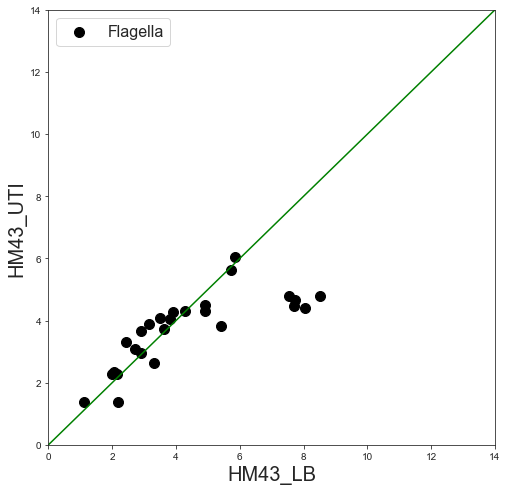

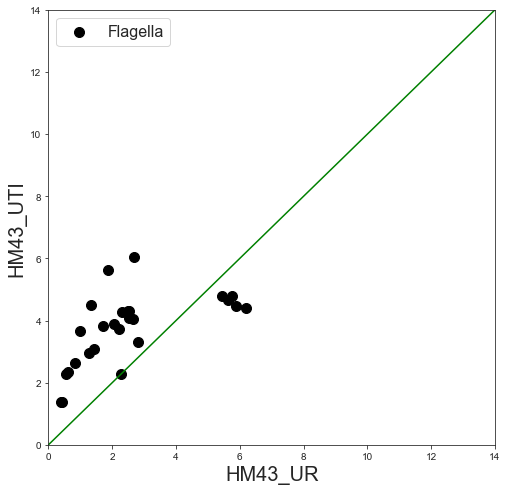

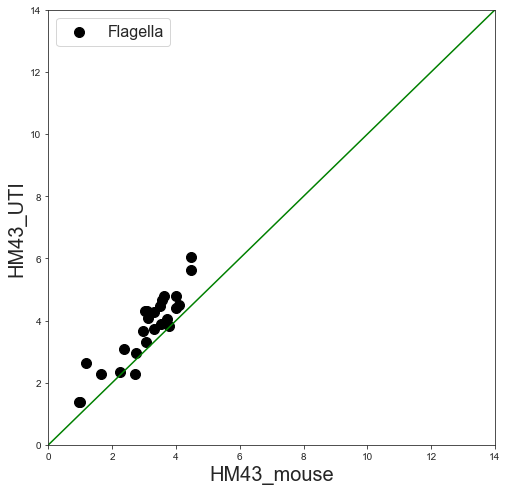

In [199]:
df1= category_correlation(logTPM, gene_sets['motility'], panHM43_OMCL, reference_genomes)

for t in conditions:
    fig = plt.figure(figsize=(8,8))
    plt.scatter( x = t[0], y =t[1], data=df1, color = 'black', label='Flagella', s=100);
    
    plt.xlabel(t[0], fontsize=20)
    plt.ylabel(t[1],fontsize=20)
    plt.plot([0, 14], [0, 14], 'g-')
    plt.xlim(0, 14)
    plt.ylim(0, 14)
    plt.legend(fontsize=16)

In [198]:
df1= category_correlation(logTPM, gene_sets['toxin'], panHM43_OMCL, reference_genomes)
df1

,K-12,CFT073,UTI89,UMN026,536,HM43_LB,HM43_UR,HM43_mouse,HM43_UTI
PROKKA_00977,b0565,c0652,UTI89_C0566,ECUMN_0637,ECP_RS02970,6.809093,9.033819,9.64491,10.868625


In [190]:
fim_df= category_correlation(logTPM, gsets2['fim'], panHM43_OMCL, reference_genomes)
fim_df.HM43_LB.mean()

7.5229100312737716

In [191]:
fim_df.HM43_UR.mean()

6.9721623227118101

In [192]:
fim_df.HM43_UTI.mean()

10.62841254528829

In [194]:
flg_df = category_correlation(logTPM, gene_sets['motility'], panHM43_OMCL, reference_genomes)
flg_df.HM43_LB.mean()

4.3264861688070368

In [195]:
flg_df.HM43_UR.mean()

2.4948208290580993

In [196]:
flg_df.HM43_UTI.mean()

3.730484363477367

          HM43_LB  HM43_UTI
HM43_LB   1.00000   0.99701
HM43_UTI  0.99701   1.00000
           HM43_UR  HM43_UTI
HM43_UR   1.000000  0.953959
HM43_UTI  0.953959  1.000000
            HM43_mouse  HM43_UTI
HM43_mouse    1.000000  0.987932
HM43_UTI      0.987932  1.000000


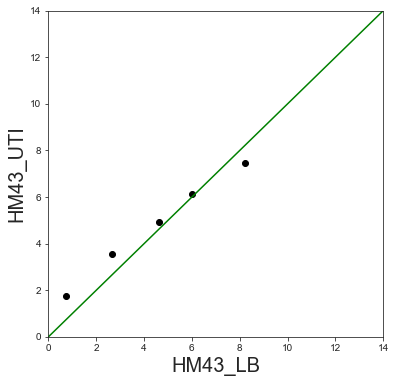

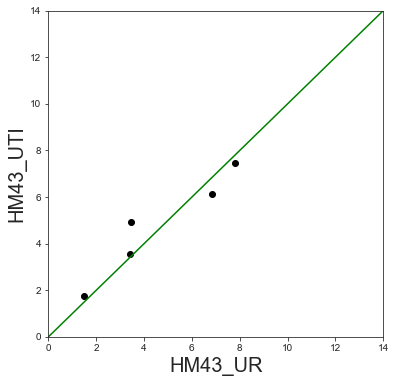

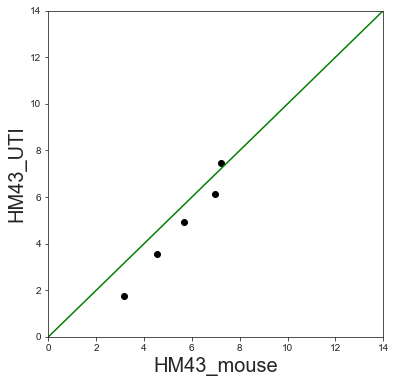

In [136]:
df= category_correlation(logTPM, gene_sets['efflux pumps'], panHM43_OMCL, reference_genomes)
for t in conditions:
    fig = plt.figure(figsize=(6,6))
    plt.scatter( x = t[0], y =t[1], data=df, color = 'black');
    plt.xlabel(t[0], fontsize=20)
    plt.ylabel(t[1],fontsize=20)
    plt.plot([0, 14], [0, 14], 'g-')
    plt.xlim(0, 14)
    plt.ylim(0, 14)
    print(df[[t[0], t[1]]].corr())

In [1]:
# Adherence
print(expression_sets['adherence'].corr())
conditions = [("HM43_LB", "HM43_UTI"), ("HM43_UR", "HM43_UTI"), ("HM43_mouse", "HM43_UTI")]

for t in conditions:
    fig = plt.figure(figsize=(6,6))
    plt.scatter( x = t[0], y =t[1], data=expression_sets['adherence'], color = 'black', s=10);
    plt.xlabel(t[0], fontsize=20)
    plt.ylabel(t[1],fontsize=20)
    plt.plot([-3, 4], [-3, 4], 'g-')
    plt.xlim(-2.5, 4)
    plt.ylim(-2.5, 4)


NameError: name 'expression_sets' is not defined

In [30]:
gene_sets.keys()
df = gene_sets['efflux pumps']
df.head()

,Functional Group,Description,CFT073,UTI89,536,HM01,HM03,HM06,HM07,HM14,HM17,HM43,HM54,HM56,HM57,HM60,HM68,HM86
index,,,,,,,,,,,,,,,,,,
acrD,efflux pumps,Probable aminoglycoside efflux pump,c2997,UTI89_C0883,NaN,PROKKA_02216,PROKKA_00842,PROKKA_01260,PROKKA_02049,PROKKA_02491,PROKKA_04074,PROKKA_03741,PROKKA_04607,PROKKA_02155,PROKKA_01288,PROKKA_02850,PROKKA_01907,PROKKA_02216
macA,efflux pumps,Macrolide-specific efflux protein macA precursor,c1014,UTI89_C0883,NaN,PROKKA_00388,PROKKA_03843,PROKKA_04564,PROKKA_00168,PROKKA_00781,PROKKA_00876,PROKKA_00650,PROKKA_02629,PROKKA_03804,PROKKA_04561,PROKKA_00792,PROKKA_00158,PROKKA_04038
macB,efflux pumps,Escherichia coli K-12 B0879 pseudogene,c1015,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tolC,efflux pumps,Multidrug efflux channel,c3781,UTI89_C3469,NaN,PROKKA_02884,PROKKA_01444,PROKKA_02011,PROKKA_02779,PROKKA_03203,PROKKA_03398,PROKKA_03103,PROKKA_00039,PROKKA_01482,PROKKA_02016,PROKKA_05126,PROKKA_02510,PROKKA_01476
aefA,efflux pumps,Potassium efflux system kefA,c0584,NaN,NaN,PROKKA_04957,PROKKA_03440,PROKKA_04152,PROKKA_04920,PROKKA_00295,PROKKA_01258,PROKKA_01047,PROKKA_02226,PROKKA_04191,PROKKA_04185,PROKKA_00186,PROKKA_04698,PROKKA_04430


             HM43_LB   HM43_UR  HM43_mouse  HM43_UTI
HM43_LB     1.000000  0.954066    0.975401  0.998442
HM43_UR     0.954066  1.000000    0.960650  0.965600
HM43_mouse  0.975401  0.960650    1.000000  0.984665
HM43_UTI    0.998442  0.965600    0.984665  1.000000


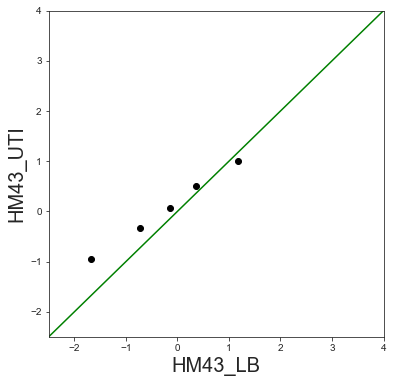

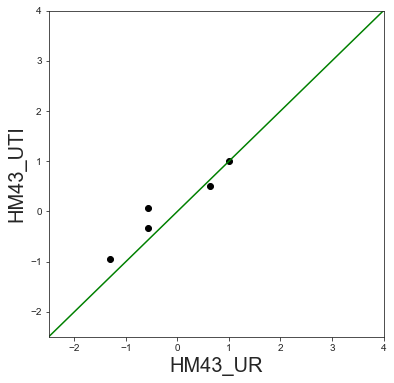

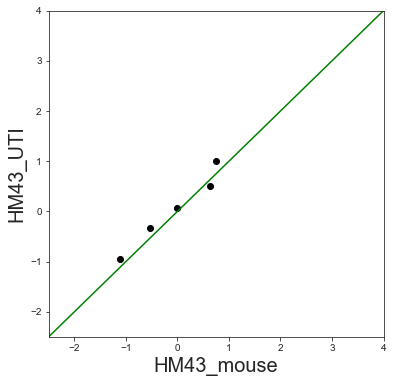

In [167]:
#Efflux
df = gene_sets['efflux pumps']
print(df.corr())
conditions = [("HM43_LB", "HM43_UTI"), ("HM43_UR", "HM43_UTI"), ("HM43_mouse", "HM43_UTI")]

for t in conditions:
    fig = plt.figure(figsize=(6,6))
    plt.scatter( x = t[0], y =t[1], data=df, color = 'black');
    plt.xlabel(t[0], fontsize=20)
    plt.ylabel(t[1],fontsize=20)
    plt.plot([-3, 4], [-3, 4], 'g-')
    plt.xlim(-2.5, 4)
    plt.ylim(-2.5, 4)


             HM43_LB   HM43_UR  HM43_mouse  HM43_UTI
HM43_LB     1.000000  0.636953    0.502040  0.650452
HM43_UR     0.636953  1.000000    0.527939  0.659702
HM43_mouse  0.502040  0.527939    1.000000  0.818227
HM43_UTI    0.650452  0.659702    0.818227  1.000000


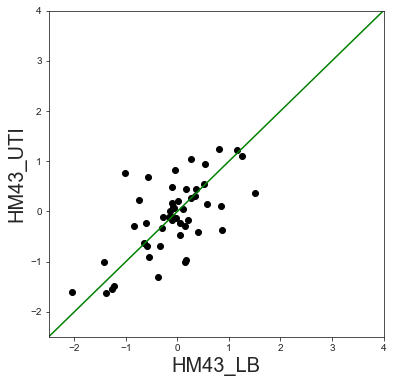

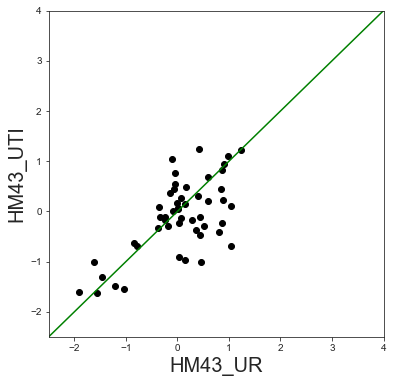

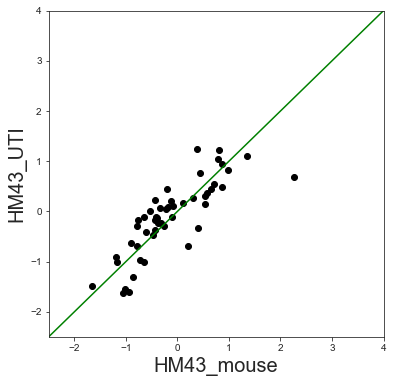

In [166]:
#Transporter
df = expression_sets['transporter']
print(df.corr())
conditions = [("HM43_LB", "HM43_UTI"), ("HM43_UR", "HM43_UTI"), ("HM43_mouse", "HM43_UTI")]
for t in conditions:
    fig = plt.figure(figsize=(6,6))
    plt.scatter( x = t[0], y =t[1], data=df, color = 'black');
    plt.xlabel(t[0], fontsize=20)
    plt.ylabel(t[1],fontsize=20)
    plt.plot([-3, 4], [-3, 4], 'g-')
    plt.xlim(-2.5, 4)
    plt.ylim(-2.5, 4)


             HM43_LB   HM43_UR  HM43_mouse  HM43_UTI
HM43_LB     1.000000  0.194462    0.082297  0.258853
HM43_UR     0.194462  1.000000    0.725806  0.667038
HM43_mouse  0.082297  0.725806    1.000000  0.657311
HM43_UTI    0.258853  0.667038    0.657311  1.000000


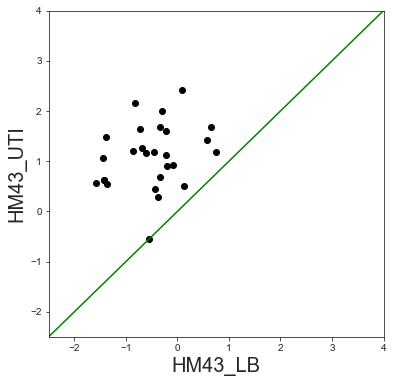

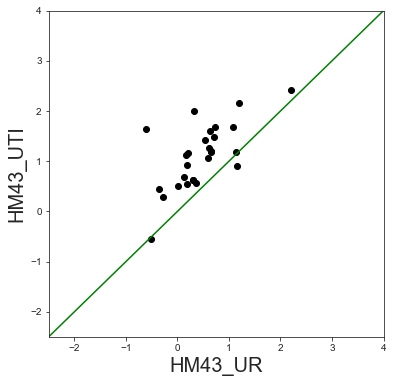

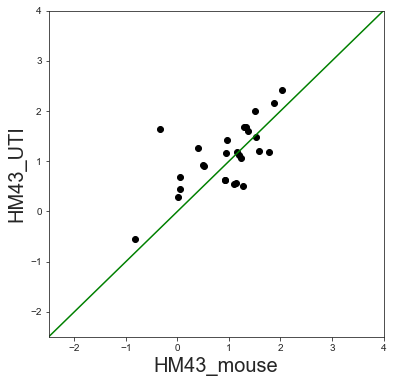

In [165]:
#Iron
df = expression_sets['Iron Acquistion']
print(df.corr())
conditions = [("HM43_LB", "HM43_UTI"), ("HM43_UR", "HM43_UTI"), ("HM43_mouse", "HM43_UTI")]

for t in conditions:
    fig = plt.figure(figsize=(6,6))
    plt.scatter( x = t[0], y =t[1], data=df, color = 'black');
    plt.xlabel(t[0], fontsize=20)
    plt.ylabel(t[1],fontsize=20)
    plt.plot([-3, 4], [-3, 4], 'g-')
    plt.xlim(-2.5, 4)
    plt.ylim(-2.5, 4)


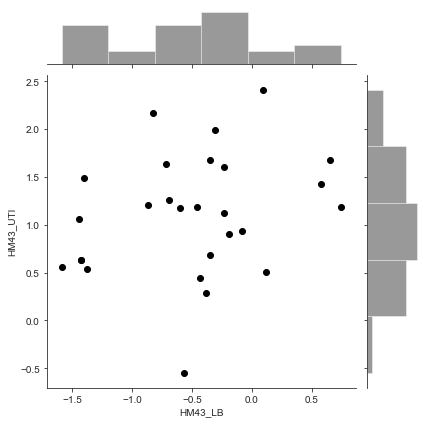

In [64]:
s = sns.jointplot( x = "HM43_LB", y ="HM43_UTI", data=t4, color = 'black',  height=6)

In [139]:
flg = ["PROKKA_04333",  "PROKKA_04335", "PROKKA_00473","PROKKA_00467"]
flg_df = cnts.loc[flg]
flg_df


,HM43_LB,HM43_UR,HM43_mouse,HM43_UTI
PROKKA_04333,-0.527028,-1.642022,-1.909083,-0.622452
PROKKA_04335,-0.184639,-1.162525,-1.093324,0.007981
PROKKA_00473,1.591850,1.026756,-0.205218,0.837610
PROKKA_00467,0.300025,-0.812838,-0.558782,0.472465


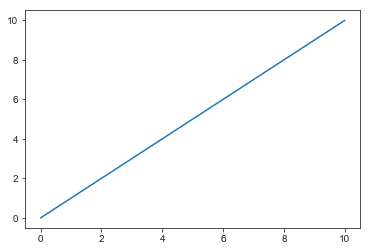

In [163]:
plt.plot([0,10], [0,10], '-')

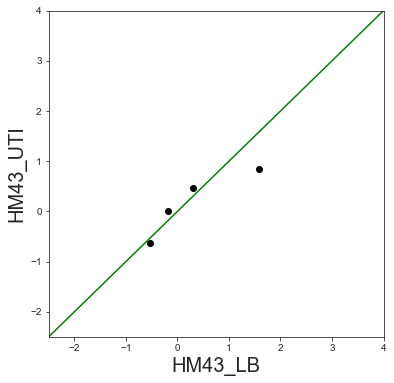

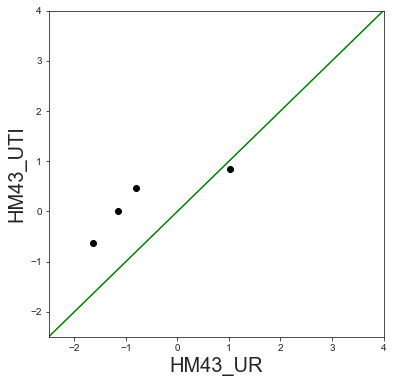

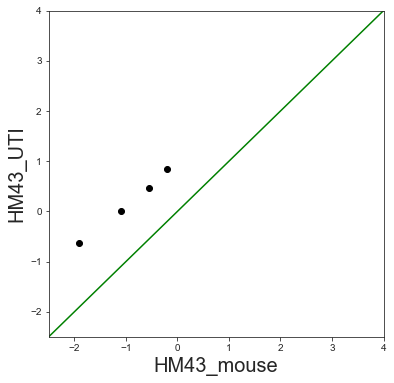

In [168]:
for t in conditions:
    fig = plt.figure(figsize=(6,6))
    plt.scatter( x = t[0], y =t[1], data=flg_df, color = 'black');
    plt.xlabel(t[0], fontsize=20)
    plt.ylabel(t[1],fontsize=20)
    plt.plot([-3, 4], [-3, 4], 'g-')
    plt.xlim(-2.5, 4)
    plt.ylim(-2.5, 4)


In [ ]:
s = sns.jointplot( x = "HM43_LB", y ="HM43_UTI", data=t4, color = 'black',  height=6)

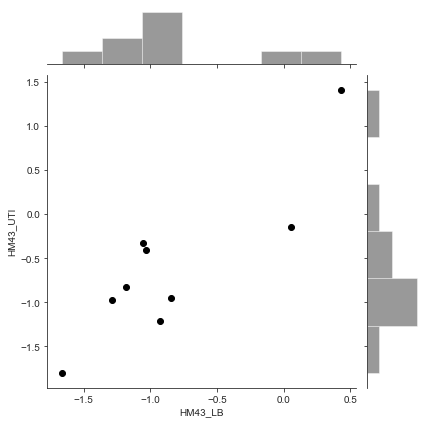

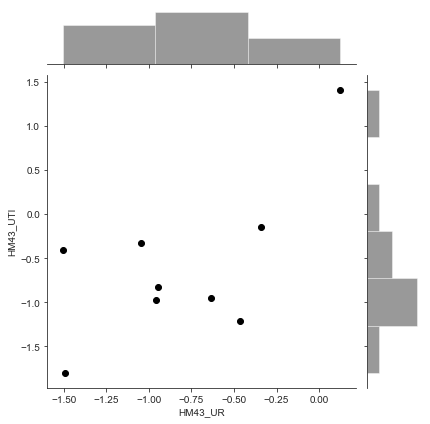

In [98]:
s = sns.jointplot( x = "HM43_UR", y ="HM43_UTI", data=t4, color = 'black',  height=6)

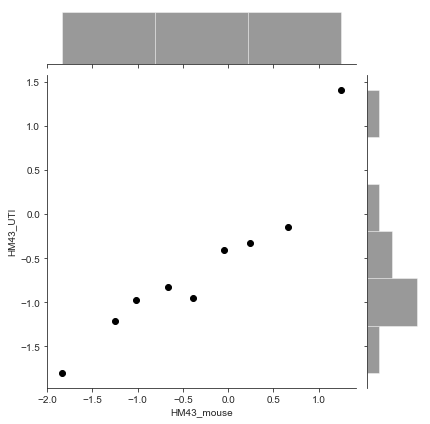

In [99]:
s = sns.jointplot( x = "HM43_mouse", y ="HM43_UTI", data=t4, color = 'black',  height=6)

In [35]:
panHM43_OMCL.head()

,K-12,CFT073,UTI89,UMN026,536
HM43,,,,,
PROKKA_00369,b1190,c1639,UTI89_C1376,ECUMN_1479,ECP_RS06260
PROKKA_00301,b1247,c1711,UTI89_C1445,ECUMN_1544,ECP_RS06575
PROKKA_02506,NaN,NaN,NaN,NaN,NaN
PROKKA_04723,b1571,NaN,NaN,NaN,NaN
PROKKA_03153,b2996,c3733,UTI89_C3418,ECUMN_3480,ECP_RS15710


In [34]:
test3

,HM43
CFT073,
c1639,PROKKA_00369
c1711,PROKKA_00301
NaN,PROKKA_02506
NaN,PROKKA_04723
c3733,PROKKA_03153
NaN,PROKKA_03203
c0558,PROKKA_01071
c0504,PROKKA_01122
NaN,PROKKA_04523


In [28]:
test2 =pd.merge(test, test3, how = 'inner', left_on = 'CFT073', right_index=True)

In [29]:
test2

,Gene,Functional Group,Description,CFT073,UTI89,F11,536,HM43
0,FepA,Iron Acquistion,Catecholate receptor,c0669,NaN,NaN,NaN,PROKKA_00957
3,Fiu,Iron Acquistion,Catecholate receptor,c0890,NaN,NaN,NaN,PROKKA_00725
4,CirA,Iron Acquistion,enterobactin biosynthesis,c2690,NaN,NaN,NaN,PROKKA_04034
5,entB,Iron Acquistion,enterobactin biosynthesis,c0682,NaN,NaN,NaN,PROKKA_00943
6,entC,Iron Acquistion,enterobactin biosynthesis,c0680,NaN,NaN,NaN,PROKKA_00946
7,entD,Iron Acquistion,enterobactin biosynthesis,c0668,NaN,NaN,NaN,PROKKA_00958
8,entE,Iron Acquistion,enterobactin biosynthesis,c2433,NaN,NaN,NaN,PROKKA_04258
9,entF,Iron Acquistion,salmochelin receptor,c0673,NaN,NaN,NaN,PROKKA_00954
14,FitA,Iron Acquistion,Hydroxymate receptor,c3775,NaN,NaN,NaN,PROKKA_03110
20,FyuA,Iron Acquistion,Yersinabactin Receptor,NaN,NaN,NaN,ECP_RS09975,PROKKA_02506


In [338]:
test2 = test.merge(test3, how='inner')

In [331]:
test.shape

(45, 7)

In [335]:
test

,Gene,Functional Group,Description,CFT073,UTI89,F11,536
0,FepA,Iron Acquistion,Catecholate receptor,c0669,NaN,NaN,NaN
1,Iha,Iron Acquistion,Catecholate receptor,c3610,NaN,NaN,NaN
2,IreA,Iron Acquistion,Catecholate receptor,c5174,NaN,NaN,NaN
3,Fiu,Iron Acquistion,Catecholate receptor,c0890,NaN,NaN,NaN
4,CirA,Iron Acquistion,enterobactin biosynthesis,c2690,NaN,NaN,NaN
5,entB,Iron Acquistion,enterobactin biosynthesis,c0682,NaN,NaN,NaN
6,entC,Iron Acquistion,enterobactin biosynthesis,c0680,NaN,NaN,NaN
7,entD,Iron Acquistion,enterobactin biosynthesis,c0668,NaN,NaN,NaN
8,entE,Iron Acquistion,enterobactin biosynthesis,c2433,NaN,NaN,NaN
9,entF,Iron Acquistion,salmochelin receptor,c0673,NaN,NaN,NaN
